# Final Project Code: Credit Spread for a Basket Product

## ~ Prachin Patel

### Import Libraries & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from yahooquery import Ticker
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from scipy import stats
from scipy.optimize import minimize
from scipy.special import gammaln
from scipy.stats import kstest
from scipy.stats import norm, t as t_dist, chi2, qmc
from scipy.stats.qmc import Halton
from scipy.stats.qmc import Sobol
from datetime import datetime
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette('viridis')

### Data Loading, Fetching, Preprocessing & EDA

In [28]:
# Source: https://www.kaggle.com/datasets/debashish311601/credit-default-swap-cds-prices

# Read CDS data
df_cds = pd.read_csv('cds.csv')

# Display first few rows and data types
print(df_cds.head())
print(df_cds.dtypes)

         Date Ticker                   Company     PX1    PX2     PX3     PX4  \
0  2015-01-01      A  Agilent Technologies Inc  14.850  25.05  39.055  73.715   
1  2015-01-02      A  Agilent Technologies Inc  14.855  25.15  39.160  73.600   
2  2015-01-05      A  Agilent Technologies Inc  13.455  24.96  39.310  70.200   
3  2015-01-06      A  Agilent Technologies Inc  15.535  24.88  39.300  72.680   
4  2015-01-07      A  Agilent Technologies Inc  15.215  25.50  40.270  73.880   

     PX5      PX6      PX7      PX8      PX9     PX10  
0  86.30  111.305  125.905  144.300  158.600  168.195  
1  86.40  111.510  126.100  144.375  158.775  168.375  
2  88.26  111.970  125.060  143.165  157.385  166.825  
3  91.10  116.610  130.890  150.365  165.655  175.885  
4  92.50  117.780  131.940  151.145  166.215  176.295  
Date        object
Ticker      object
Company     object
PX1        float64
PX2        float64
PX3        float64
PX4        float64
PX5        float64
PX6        float64
PX7   

In [29]:
# Set the date column as index and convert to datetime
df_cds = df_cds.set_index('Date')
df_cds.index = pd.to_datetime(df_cds.index)

# Drop unnecessary columns i.e. Tenors greater than 5 years
df_cds.drop(columns=['PX6', 'PX7', 'PX8', 'PX9', 'PX10'], inplace=True)

# Rename columns for clarity
df_cds.rename(columns={'PX1': 'Spread_1Y', 'PX2': 'Spread_2Y', 'PX3': 'Spread_3Y', 'PX4': 'Spread_4Y', 'PX5': 'Spread_5Y'}, inplace=True)

# Display the cleaned dataframe
print(df_cds.tail())

           Ticker Company  Spread_1Y  Spread_2Y  Spread_3Y  Spread_4Y  \
Date                                                                    
2021-09-06  ZIGGO   Ziggo    43.1264    87.0118   129.5117   172.7865   
2021-09-07  ZIGGO   Ziggo    43.1224    86.7150   132.9410   176.4412   
2021-09-08  ZIGGO   Ziggo    42.3178    86.5418   131.5519   178.4565   
2021-09-09  ZIGGO   Ziggo    42.8331    86.1851   131.5978   176.8352   
2021-09-10  ZIGGO   Ziggo    46.1870    88.4756   128.3068   178.8222   

            Spread_5Y  
Date                   
2021-09-06   214.8831  
2021-09-07   222.3668  
2021-09-08   223.4681  
2021-09-09   221.5081  
2021-09-10   222.8676  


In [30]:
# List unique companies in the dataset
print(df_cds['Company'].unique())

['Agilent Technologies Inc' 'Anglo American PLC' 'Apple Inc' 'ABB Ltd'
 'AbbVie Inc' 'AmerisourceBergen Corp' 'Abertis Infraestructuras SA'
 'Anheuser Busch InBev SA NV' 'Abbott Laboratories' 'Barrick Gold Corp'
 'Credit Agricole' 'ACEA SpA' 'Accor SA' 'Adecco Group AG'
 'ADLER Real Estate AG' 'Archer-Daniels-Midland Co'
 'Koninklijke Ahold Delhaize NV' 'Automatic Data Processing Inc'
 'adidas AG' 'Aegon NV' 'The AES Corporation' 'Aetna Inc'
 'American Financial Group Inc' 'African Export-Import Bank'
 'Avangrid Inc' 'Agricultural Bank of China Ltd' 'Ageas' 'Air Liquide SA'
 'American International Group Inc' 'Airbus SE' 'Akzo Nobel NV'
 'Allstate Corp' 'Alliander NV' 'Ally Financial Inc' 'Alstom SA'
 'Alpha Bank AE' 'Allianz SE' 'Applied Materials Inc' 'Amgen Inc'
 'Ameriprise Financial Inc' 'American Tower Corp'
 'America Movil SAB de CV' 'Amazon.com Inc' 'AutoNation Inc'
 'AngloGold Ashanti' 'Anthem Inc' 'Australia   New Zealand Banking'
 'Air Products   Chemicals Inc' 'FCC Aqualia 

In [31]:
# Filter data for a specific date
df_cds_specific_date = df_cds.loc['2021-09-10']

# Filter for selected companies for the basket on a specific date
selected_companies = ['Bank of America Corp', 'General Motors Co', 'UnitedHealth Group Inc', 'Verizon Communications Inc', 'Exxon Mobil Corp']
df_cds_basket = df_cds_specific_date[df_cds_specific_date['Company'].isin(selected_companies)]

# Display the filtered dataframe
print(df_cds_basket.head())

           Ticker                     Company  Spread_1Y  Spread_2Y  \
Date                                                                  
2021-09-10    BAC        Bank of America Corp    23.9441    27.0477   
2021-09-10     GM           General Motors Co    37.8650    48.3402   
2021-09-10    UNH      UnitedHealth Group Inc     8.0474    11.2941   
2021-09-10     VZ  Verizon Communications Inc    20.6768    25.9752   
2021-09-10    XOM            Exxon Mobil Corp     6.7868    12.6804   

            Spread_3Y  Spread_4Y  Spread_5Y  
Date                                         
2021-09-10    31.2963    36.3222    41.7542  
2021-09-10    66.4369    79.8594    93.8307  
2021-09-10    17.4187    23.5428    32.7452  
2021-09-10    31.1214    38.6461    46.7277  
2021-09-10    18.3246    24.4631    31.1830  


Plot saved as 'credit_spread_term_structure.png'


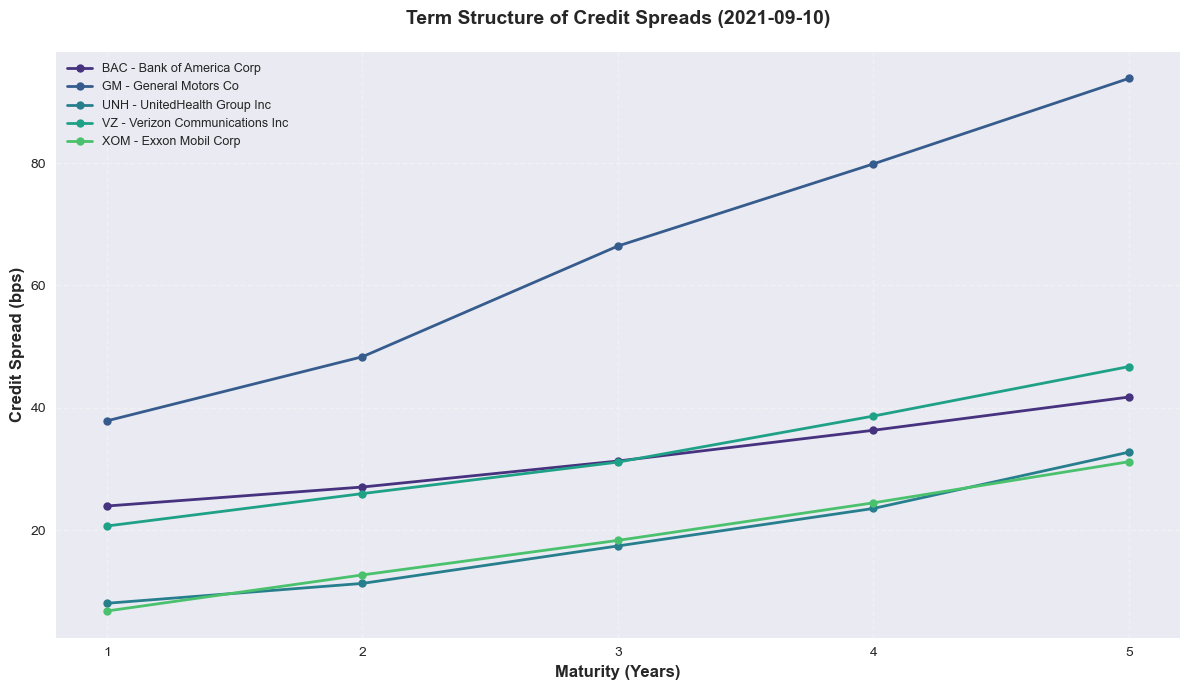

In [32]:
# Define the maturity columns and their corresponding years
spread_columns = ['Spread_1Y', 'Spread_2Y', 'Spread_3Y', 'Spread_4Y', 'Spread_5Y']
maturities = [1, 2, 3, 4, 5]  # Years

# Create the plot
plt.figure(figsize=(12, 7))

# Plot each company's term structure
for idx, row in df_cds_basket.iterrows():
    ticker = row['Ticker']
    company = row['Company']
    spreads = [row[col] for col in spread_columns]
    
    plt.plot(maturities, spreads, marker='o', linewidth=2, 
             label=f"{ticker} - {company}", markersize=6)

# Customize the plot
plt.xlabel('Maturity (Years)', fontsize=12, fontweight='bold')
plt.ylabel('Credit Spread (bps)', fontsize=12, fontweight='bold')
plt.title('Term Structure of Credit Spreads (2021-09-10)', 
          fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(maturities)
plt.tight_layout()

# Save the plot
plt.savefig('credit_spread_term_structure.png', dpi=300)
print("Plot saved as 'credit_spread_term_structure.png'")

plt.show()

In [33]:
# Define the tickers
tickers = ['BAC', 'GM', 'UNH', 'VZ', 'XOM']

# Define the date range
start_date = '2015-01-01'
end_date = '2021-09-11'

# Create Ticker object for all tickers at once
stocks = Ticker(tickers)

# Get historical data
try:
    history = stocks.history(start=start_date, end=end_date)
    
    # Reshape data: yahooquery returns multi-index DataFrame
    if isinstance(history.index, pd.MultiIndex):
        # Reset index to convert multi-index to columns
        history_reset = history.reset_index()
        
        # Pivot to get tickers as columns
        adj_close = history_reset.pivot(index='date', columns='symbol', values='adjclose')
        
        print(f"✓ Successfully downloaded data for {len(adj_close.columns)} tickers")
        print(f"Date range: {adj_close.index.min()} to {adj_close.index.max()}")
        print("="*60)
        
        print("\nAdjusted Close Prices (First 10 rows):")
        print(adj_close.head(10))
        
        # Save to CSV
        adj_close.to_csv('historical_equity_data.csv')
        print("\n✓ Data saved to 'historical_equity_data.csv'")
        
    else:
        print("Unexpected data format. Here's what we got:")
        print(history.head())
        
except Exception as e:
    print(f"✗ Error: {str(e)}")

✓ Successfully downloaded data for 5 tickers
Date range: 2015-01-02 to 2021-09-10

Adjusted Close Prices (First 10 rows):
symbol            BAC         GM        UNH         VZ        XOM
date                                                             
2015-01-02  14.203646  26.899031  84.480484  26.573200  57.916908
2015-01-05  13.791024  26.505280  83.088966  26.352509  56.332191
2015-01-06  13.378405  26.906761  82.921288  26.618469  56.032707
2015-01-07  13.441887  27.671110  83.767960  26.446695  56.600468
2015-01-08  13.719612  27.949055  87.766502  27.013531  57.542583
2015-01-09  13.473624  27.478096  86.944962  26.773066  57.461464
2015-01-12  13.235572  27.671110  85.964195  26.956276  56.357162
2015-01-13  13.053067  27.215590  86.400101  27.013531  56.151268
2015-01-14  12.727735  26.482121  86.618057  26.893299  55.989052
2015-01-15  12.061194  25.810411  87.565315  26.967733  55.502399

✓ Data saved to 'historical_equity_data.csv'


In [34]:
# Load the saved equity data
df_equity = pd.read_csv('historical_equity_data.csv', index_col='date', parse_dates=True)

# Rename columns and index for clarity
df_equity.index.name = "Date"

# Basic info
print(f'Head: {df_equity.head()}')
print(f'Columns: {df_equity.columns}')
print(f'Shape: {df_equity.shape}')
print(f'Data date range from: {df_equity.index.min()} to {df_equity.index.max()}')
print(df_equity.describe())

# Get unique dates from the index
unique_days = df_equity.index.normalize().unique()

# Count them
num_unique_days = len(unique_days)
print(f"Number of unique days: {num_unique_days}")

# Check nan values
print("Nan values per column:")
print(df_equity.isnull().sum())

# Check duplicates
duplicate_rows = df_equity.reset_index().duplicated().sum()
print(f"Number of completely duplicate rows (including time): {duplicate_rows}")

# Count zeros in each column
zero_counts = (df_equity == 0).sum()
print("Count of zeros in each column:")
print(zero_counts)

Head:                   BAC         GM        UNH         VZ        XOM
Date                                                             
2015-01-02  14.203646  26.899031  84.480484  26.573200  57.916908
2015-01-05  13.791024  26.505280  83.088966  26.352509  56.332191
2015-01-06  13.378405  26.906761  82.921288  26.618469  56.032707
2015-01-07  13.441887  27.671110  83.767960  26.446695  56.600468
2015-01-08  13.719612  27.949055  87.766502  27.013531  57.542583
Columns: Index(['BAC', 'GM', 'UNH', 'VZ', 'XOM'], dtype='object')
Shape: (1685, 5)
Data date range from: 2015-01-02 00:00:00 to 2021-09-10 00:00:00
               BAC           GM          UNH           VZ          XOM
count  1685.000000  1685.000000  1685.000000  1685.000000  1685.000000
mean     21.322305    32.888342   200.756810    35.382087    51.335625
std       6.964633     8.454939    81.779825     5.877846     8.416931
min       8.963641    16.209179    82.921288    25.097652    24.145128
25%      13.963467    27.0887

In [35]:
# 1. Resample to weekly frequency (using last price of each week)
equity_weekly_prices = df_equity.resample('W').last()

# 2. Compute weekly log returns
equity_weekly_log_returns = np.log(equity_weekly_prices / equity_weekly_prices.shift(1)).dropna()

print(f'Weekly Prices Head:\n{equity_weekly_prices.head()}')
print(f'Weekly Returns Head:\n{equity_weekly_log_returns.head()}')

Weekly Prices Head:
                  BAC         GM        UNH         VZ        XOM
Date                                                             
2015-01-04  14.203646  26.899031  84.480484  26.573200  57.916908
2015-01-11  13.473624  27.478096  86.944962  26.773066  57.461464
2015-01-18  12.204026  26.003433  88.663452  27.477316  56.850044
2015-01-25  12.481750  26.057474  93.885803  26.996361  56.706524
2015-02-01  12.021523  25.185036  89.065788  26.171860  54.541584
Weekly Returns Head:
                 BAC        GM       UNH        VZ       XOM
Date                                                        
2015-01-11 -0.052765  0.021299  0.028755  0.007493 -0.007895
2015-01-18 -0.098968 -0.055161  0.019572  0.025964 -0.010698
2015-01-25  0.022502  0.002076  0.057231 -0.017659 -0.002528
2015-02-01 -0.037569 -0.034055 -0.052704 -0.031017 -0.038926
2015-02-08  0.084753  0.098593  0.012626  0.076216  0.053114


In [36]:
# Source: https://home.treasury.gov/resource-center/data-chart-center/interest-rates/daily-treasury-rate-archives/par-yield-curve-rates-2020-2022.csv

# Load interest rate data
df_ir_hist = pd.read_csv('par-yield-curve-rates-2020-2022.csv')

df_ir_hist = df_ir_hist.set_index('Date')
df_ir_hist.index = pd.to_datetime(df_ir_hist.index)

# Filter for rates on specific date
df_rates = df_ir_hist.loc['2021-09-10']

# Transpose to have maturities as columns
df_rates = df_rates.to_frame().T

# Drop unnecessary columns
df_rates.drop(columns=['1 Mo', '2 Mo', '3 Mo', '4 Mo', '6 Mo', '7 Yr', '10 Yr', '20 Yr', '30 Yr'], inplace=True)

# Rename columns for clarity
df_rates.rename(columns={'1 Yr': 'Yield_1Y', '2 Yr': 'Yield_2Y', '3 Yr': 'Yield_3Y', '5 Yr': 'Yield_5Y'}, inplace=True)

# Interpolate 4Y rate
df_rates['Yield_4Y'] = df_rates['Yield_3Y'] + ((df_rates['Yield_5Y'] - df_rates['Yield_3Y']) / 2)

# Reorder columns
df_rates = df_rates.reindex(columns=['Yield_1Y', 'Yield_2Y', 'Yield_3Y', 'Yield_4Y', 'Yield_5Y'])

print(df_rates)

            Yield_1Y  Yield_2Y  Yield_3Y  Yield_4Y  Yield_5Y
2021-09-10      0.08      0.23      0.45     0.635      0.82


Discount Factors:
   Tenor    Yield  DiscountFactor
0      1  0.00080        0.999200
1      2  0.00230        0.995411
2      3  0.00450        0.986591
3      4  0.00635        0.974920
4      5  0.00820        0.959829


Plot saved as 'yield_and_discount_factor_curve.png'


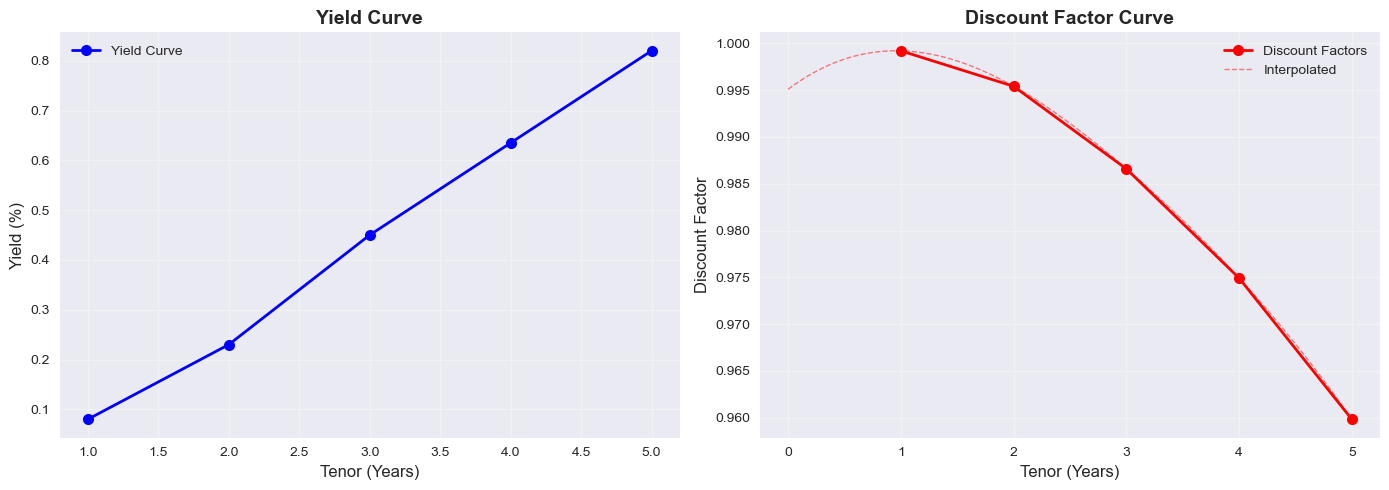

In [37]:
# Extract yields and convert to decimal (they appear to be in percentage)
yields = df_rates.iloc[0].values / 100  # Convert to decimal
tenors = np.array([1, 2, 3, 4, 5])  # Years

# Calculate discount factors: DF(t) = 1 / (1 + r*t) for simple rates
# Or use DF(t) = exp(-r*t) for continuous compounding
# Here using continuous compounding as is standard in derivatives pricing
discount_factors = np.exp(-yields * tenors)

# Store discount factors in a DataFrame for easy access
discount_factor = pd.DataFrame({
    'Tenor': tenors,
    'Yield': yields,
    'DiscountFactor': discount_factors
})

# Print the discount factors
print("Discount Factors:")
print(discount_factor)
print("\n")

# Create interpolation function for discount factors at any tenor
# This will be useful for pricing CDS with non-standard payment dates
df_interp = interp1d(tenors, discount_factors, kind='cubic', 
                      fill_value='extrapolate')

# Plot the discount curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Yield Curve
ax1.plot(tenors, yields * 100, 'bo-', linewidth=2, markersize=8, label='Yield Curve')
ax1.set_xlabel('Tenor (Years)', fontsize=12)
ax1.set_ylabel('Yield (%)', fontsize=12)
ax1.set_title('Yield Curve', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Discount Factor Curve
ax2.plot(tenors, discount_factors, 'ro-', linewidth=2, markersize=8, label='Discount Factors')
ax2.set_xlabel('Tenor (Years)', fontsize=12)
ax2.set_ylabel('Discount Factor', fontsize=12)
ax2.set_title('Discount Factor Curve', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Add a smooth interpolated curve
tenors_fine = np.linspace(0, 5, 100)
df_fine = df_interp(tenors_fine)
ax2.plot(tenors_fine, df_fine, 'r--', alpha=0.5, linewidth=1, label='Interpolated')
ax2.legend()

plt.tight_layout()

# Save the plot
plt.savefig('yield_and_discount_factor_curve.png', dpi=300)
print("Plot saved as 'yield_and_discount_factor_curve.png'")

plt.show()

# Additional: Create a function to get discount factor at any tenor
def get_discount_factor(t):
    """
    Get discount factor at tenor t using interpolation
    """
    return df_interp(t)

### Bootstrapping Implied Default Probabilities from CDS Spreads & Converting them to Hazard Rates


BOOTSTRAPPING IMPLIED DEFAULT PROBABILITIES FROM CDS SPREADS & CONVERTING TO HAZARD RATES

   Ticker                     Company  Tenor  CDS_Spread_bps  Hazard_Rate  \
0     BAC        Bank of America Corp      1         23.9441     0.003983   
1     BAC        Bank of America Corp      2         27.0477     0.005017   
2     BAC        Bank of America Corp      3         31.2963     0.006639   
3     BAC        Bank of America Corp      4         36.3222     0.008616   
4     BAC        Bank of America Corp      5         41.7542     0.010715   
5      GM           General Motors Co      1         37.8650     0.006291   
6      GM           General Motors Co      2         48.3402     0.009778   
7      GM           General Motors Co      3         66.4369     0.017159   
8      GM           General Motors Co      4         79.8594     0.020189   
9      GM           General Motors Co      5         93.8307     0.025422   
10    UNH      UnitedHealth Group Inc      1          8.0474 

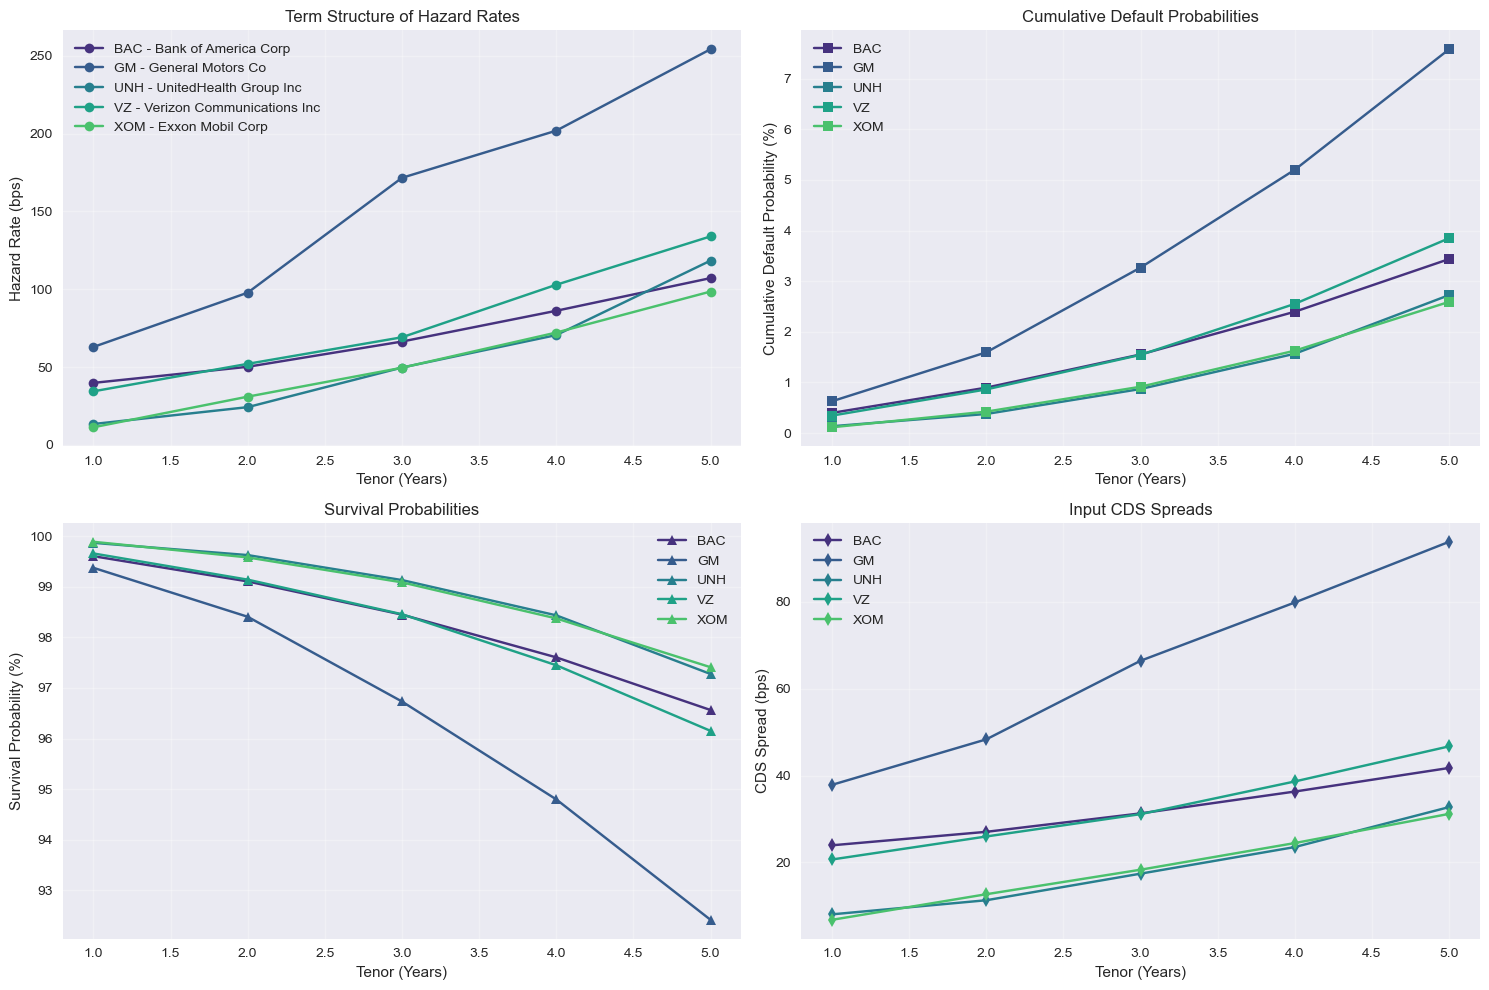

In [38]:
class CDSBootstrap:
    """
    Bootstrap implied default probabilities and hazard rates from CDS spreads.
    """
    
    def __init__(self, recovery_rate=0.4):
        """
        Initialize the bootstrap calculator.
        """
        self.recovery_rate = recovery_rate
        self.loss_given_default = 1 - recovery_rate
        
    def bootstrap_hazard_rates(self, cds_spreads, tenors, discount_factors):
        """
        Bootstrap hazard rates from CDS spreads using iterative approach.
        """
        cds_spreads = np.array(cds_spreads) / 10000  # Convert bps to decimal
        tenors = np.array(tenors)
        discount_factors = np.array(discount_factors)
        
        n = len(tenors)
        hazard_rates = np.zeros(n)
        survival_probs = np.zeros(n)
        default_probs = np.zeros(n)
        
        # Bootstrap each tenor sequentially
        for i in range(n):
            if i == 0:
                # First period: solve directly
                hazard_rates[i] = self._solve_first_period(
                    cds_spreads[i], tenors[i], discount_factors[i]
                )
            else:
                # Subsequent periods: solve given previous hazard rates
                hazard_rates[i] = self._solve_subsequent_period(
                    cds_spreads[i], tenors[:i+1], discount_factors[:i+1], 
                    hazard_rates[:i+1]
                )
            
            # Calculate survival probability: S(t) = exp(-λ*t) for piecewise constant hazard
            survival_probs[i] = np.exp(-np.sum(hazard_rates[:i+1] * np.diff(np.concatenate([[0], tenors[:i+1]]))))
            default_probs[i] = 1 - survival_probs[i]
        
        return {
            'hazard_rates': hazard_rates,
            'survival_probs': survival_probs,
            'default_probs': default_probs,
            'tenors': tenors
        }
    
    def _solve_first_period(self, spread, tenor, discount_factor):
        """Solve for hazard rate in the first period."""
        def equation(lambda_rate):
            # Survival probability
            surv_prob = np.exp(-lambda_rate * tenor)
            
            # Premium leg (approximate with single payment at tenor)
            premium_leg = spread * tenor * discount_factor * surv_prob
            
            # Default leg
            default_leg = self.loss_given_default * discount_factor * (1 - surv_prob)
            
            return premium_leg - default_leg
        
        # Solve for hazard rate
        lambda_initial = spread / self.loss_given_default  # Initial guess
        lambda_rate = fsolve(equation, lambda_initial)[0]
        
        return max(lambda_rate, 1e-6)  # Ensure positive
    
    def _solve_subsequent_period(self, spread, tenors, discount_factors, hazard_rates):
        """Solve for hazard rate in subsequent periods given previous rates."""
        def equation(lambda_new):
            current_hazard = hazard_rates.copy()
            current_hazard[-1] = lambda_new  # Update the current period
            
            # Calculate premium and default legs with risky annuity
            premium_leg = self._calculate_premium_leg(
                spread, tenors, discount_factors, current_hazard
            )
            default_leg = self._calculate_default_leg(
                tenors, discount_factors, current_hazard
            )
            
            return premium_leg - default_leg
        
        # Initial guess
        lambda_initial = hazard_rates[-2] if len(hazard_rates) > 1 else spread / self.loss_given_default
        lambda_new = fsolve(equation, lambda_initial)[0]
        
        return max(lambda_new, 1e-6)
    
    def _calculate_premium_leg(self, spread, tenors, discount_factors, hazard_rates):
        """Calculate the present value of premium leg (risky annuity)."""
        premium_leg = 0
        
        for i in range(len(tenors)):
            dt = tenors[i] - (tenors[i-1] if i > 0 else 0)
            
            # Survival probability at time t
            cum_hazard = np.sum(hazard_rates[:i+1] * np.diff(np.concatenate([[0], tenors[:i+1]])))
            surv_prob = np.exp(-cum_hazard)
            
            # Add premium payment (assuming annual payments)
            premium_leg += spread * dt * discount_factors[i] * surv_prob
        
        return premium_leg
    
    def _calculate_default_leg(self, tenors, discount_factors, hazard_rates):
        """Calculate the present value of default leg (protection payment)."""
        default_leg = 0
        
        for i in range(len(tenors)):
            # Survival probability at start of period
            if i == 0:
                surv_prob_start = 1.0
            else:
                cum_hazard_start = np.sum(hazard_rates[:i] * np.diff(np.concatenate([[0], tenors[:i]])))
                surv_prob_start = np.exp(-cum_hazard_start)
            
            # Survival probability at end of period
            cum_hazard_end = np.sum(hazard_rates[:i+1] * np.diff(np.concatenate([[0], tenors[:i+1]])))
            surv_prob_end = np.exp(-cum_hazard_end)
            
            # Default probability in this period
            default_prob_period = surv_prob_start - surv_prob_end
            
            # Add to default leg (discounted)
            default_leg += self.loss_given_default * discount_factors[i] * default_prob_period
        
        return default_leg


def process_cds_basket(df_cds_basket, discount_factors_df, recovery_rate=0.4):
    """
    Process the entire CDS basket and bootstrap hazard rates for all names.
    """
    bootstrap = CDSBootstrap(recovery_rate=recovery_rate)
    
    # Extract tenors from discount factors
    tenors = discount_factors_df['Tenor'].values
    discount_factors = discount_factors_df['DiscountFactor'].values
    
    results = {}
    
    for idx, row in df_cds_basket.iterrows():
        ticker = row['Ticker']
        company = row['Company']
        
        # Extract CDS spreads for all tenors
        cds_spreads = [
            row['Spread_1Y'],
            row['Spread_2Y'],
            row['Spread_3Y'],
            row['Spread_4Y'],
            row['Spread_5Y']
        ]
        
        # Bootstrap hazard rates
        result = bootstrap.bootstrap_hazard_rates(cds_spreads, tenors, discount_factors)
        
        results[ticker] = {
            'company': company,
            'cds_spreads_bps': cds_spreads,
            'hazard_rates': result['hazard_rates'],
            'survival_probs': result['survival_probs'],
            'default_probs': result['default_probs'],
            'tenors': result['tenors']
        }
    
    return results


def visualize_results(results):
    """
    Visualize the bootstrapped hazard rates and default probabilities.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Hazard Rates
    ax1 = axes[0, 0]
    for ticker, data in results.items():
        ax1.plot(data['tenors'], data['hazard_rates'] * 10000, 
                marker='o', label=f"{ticker} - {data['company']}")
    ax1.set_xlabel('Tenor (Years)')
    ax1.set_ylabel('Hazard Rate (bps)')
    ax1.set_title('Term Structure of Hazard Rates')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Cumulative Default Probabilities
    ax2 = axes[0, 1]
    for ticker, data in results.items():
        ax2.plot(data['tenors'], data['default_probs'] * 100, 
                marker='s', label=f"{ticker}")
    ax2.set_xlabel('Tenor (Years)')
    ax2.set_ylabel('Cumulative Default Probability (%)')
    ax2.set_title('Cumulative Default Probabilities')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Survival Probabilities
    ax3 = axes[1, 0]
    for ticker, data in results.items():
        ax3.plot(data['tenors'], data['survival_probs'] * 100, 
                marker='^', label=f"{ticker}")
    ax3.set_xlabel('Tenor (Years)')
    ax3.set_ylabel('Survival Probability (%)')
    ax3.set_title('Survival Probabilities')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: CDS Spreads
    ax4 = axes[1, 1]
    for ticker, data in results.items():
        ax4.plot(data['tenors'], data['cds_spreads_bps'], 
                marker='d', label=f"{ticker}")
    ax4.set_xlabel('Tenor (Years)')
    ax4.set_ylabel('CDS Spread (bps)')
    ax4.set_title('Input CDS Spreads')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()

    # Save the figure
    plt.savefig('cds_bootstrapping_results.png', dpi=300)
    print("Plot saved as 'cds_bootstrapping_results.png'")

    plt.show()
    
    return fig


def create_summary_dataframe(results):
    """
    Create a summary DataFrame with all bootstrapped results.
    """
    summary_data = []
    
    for ticker, data in results.items():
        for i, tenor in enumerate(data['tenors']):
            summary_data.append({
                'Ticker': ticker,
                'Company': data['company'],
                'Tenor': tenor,
                'CDS_Spread_bps': data['cds_spreads_bps'][i],
                'Hazard_Rate': data['hazard_rates'][i],
                'Hazard_Rate_bps': data['hazard_rates'][i] * 10000,
                'Survival_Prob': data['survival_probs'][i],
                'Default_Prob': data['default_probs'][i]
            })
    
    return pd.DataFrame(summary_data)


# Example usage:
if __name__ == "__main__":
    print("\n" + "="*100)
    print("BOOTSTRAPPING IMPLIED DEFAULT PROBABILITIES FROM CDS SPREADS & CONVERTING TO HAZARD RATES")
    print("="*100 + "\n")
    results_bootstrap = process_cds_basket(df_cds_basket, discount_factor)
    df_bootstrap = create_summary_dataframe(results_bootstrap)
    print(df_bootstrap)
    visualize_results(results_bootstrap)
    pass

### Estimate Default Correlation Matrices & Calibrating Gaussian & t-Copula


CORRELATION ESTIMATION AND COPULA CALIBRATION

GAUSSIAN COPULA VALIDATION
Log-Likelihood: 214.59
Number of parameters: 10
AIC: -409.18


CALIBRATING T-COPULA (Estimating Degrees of Freedom)
df =  5: Log-Likelihood = 242.90
df = 10: Log-Likelihood = 238.73
df = 15: Log-Likelihood = 234.20
df = 20: Log-Likelihood = 231.18
df = 25: Log-Likelihood = 229.08
df = 30: Log-Likelihood = 227.55

Grid Optimal df: 6 (LL=242.95)
Refined Optimal Degrees of Freedom: 5.49
Refined Maximum Log-Likelihood: 243.10
AIC: -464.20


COPULA COMPARISON SUMMARY

Gaussian Copula (Pearson Corr):
  Log-Likelihood: 214.59
  AIC: -409.18

t-Copula (Spearman Corr, df=5.491517078845436):
  Log-Likelihood: 243.10
  AIC: -464.20

t-Copula (Pearson Corr, df=5.491517078845436):
  Log-Likelihood: 236.38
  AIC: -450.76

Best Model (Lowest AIC): t-Spearman (AIC=-464.20)


Plot saved as 'correlation_matrices.png'


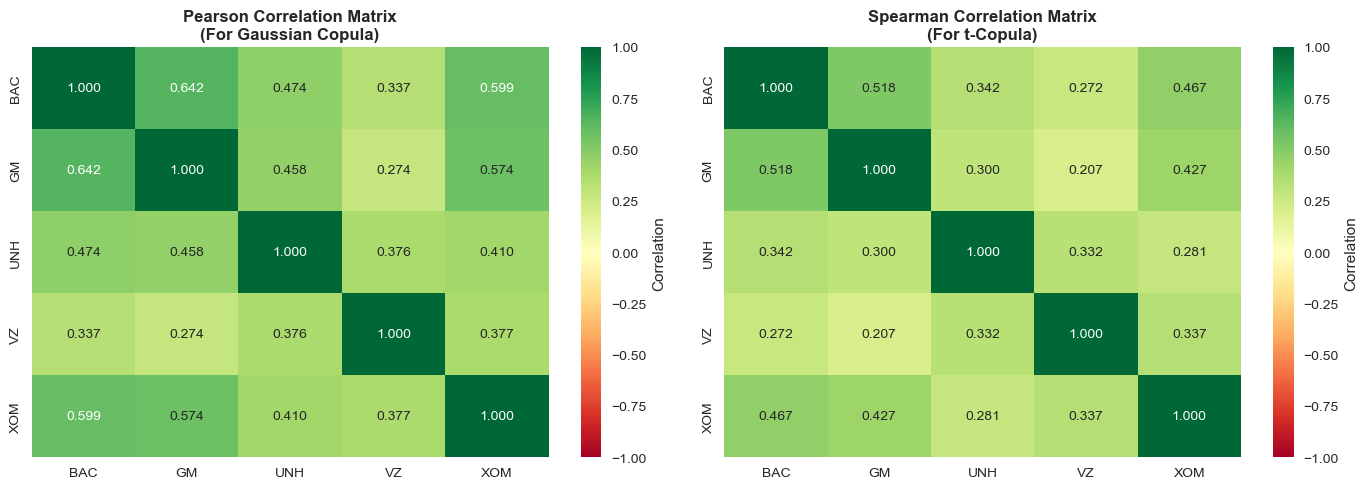

Plot saved as 't_copula_calibration.png'


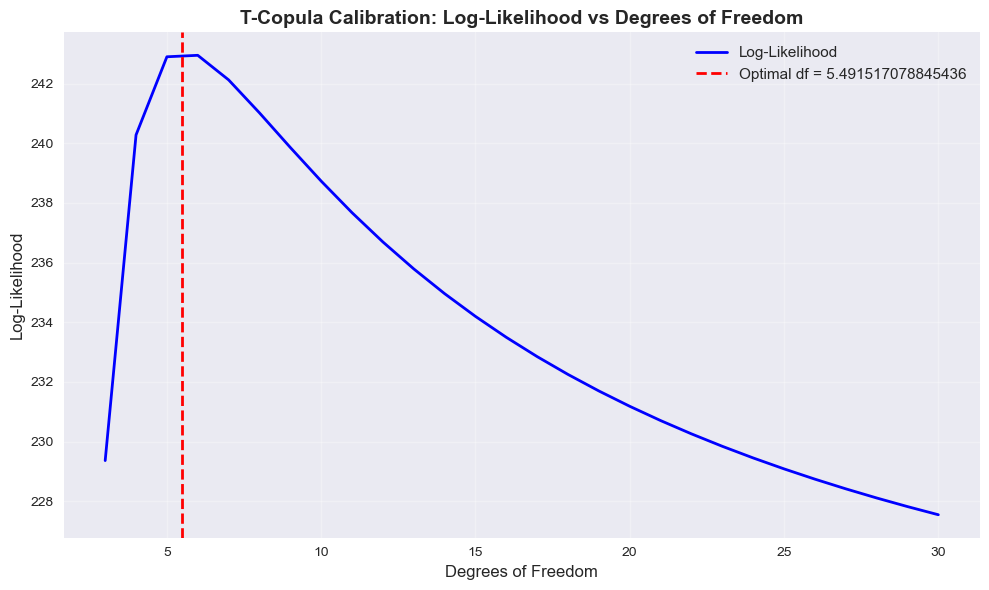

BAC: KS stat=0.0014, p-value=1.0000 (uniform if p>0.05)
GM: KS stat=0.0014, p-value=1.0000 (uniform if p>0.05)
UNH: KS stat=0.0014, p-value=1.0000 (uniform if p>0.05)
VZ: KS stat=0.0014, p-value=1.0000 (uniform if p>0.05)
XOM: KS stat=0.0014, p-value=1.0000 (uniform if p>0.05)
Plot saved as "uniformity_check.png"


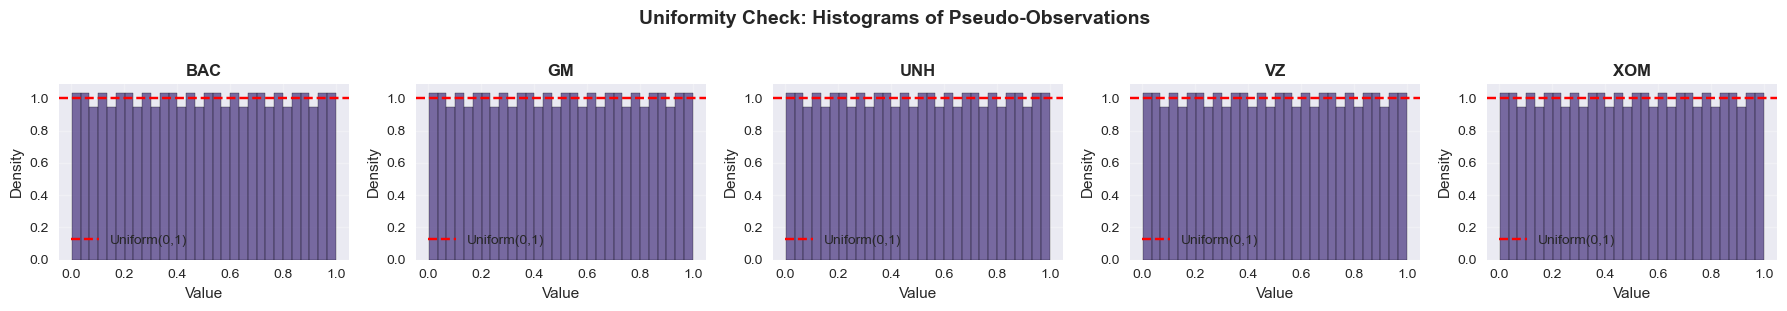

Plot saved as "copula_dependence.png"


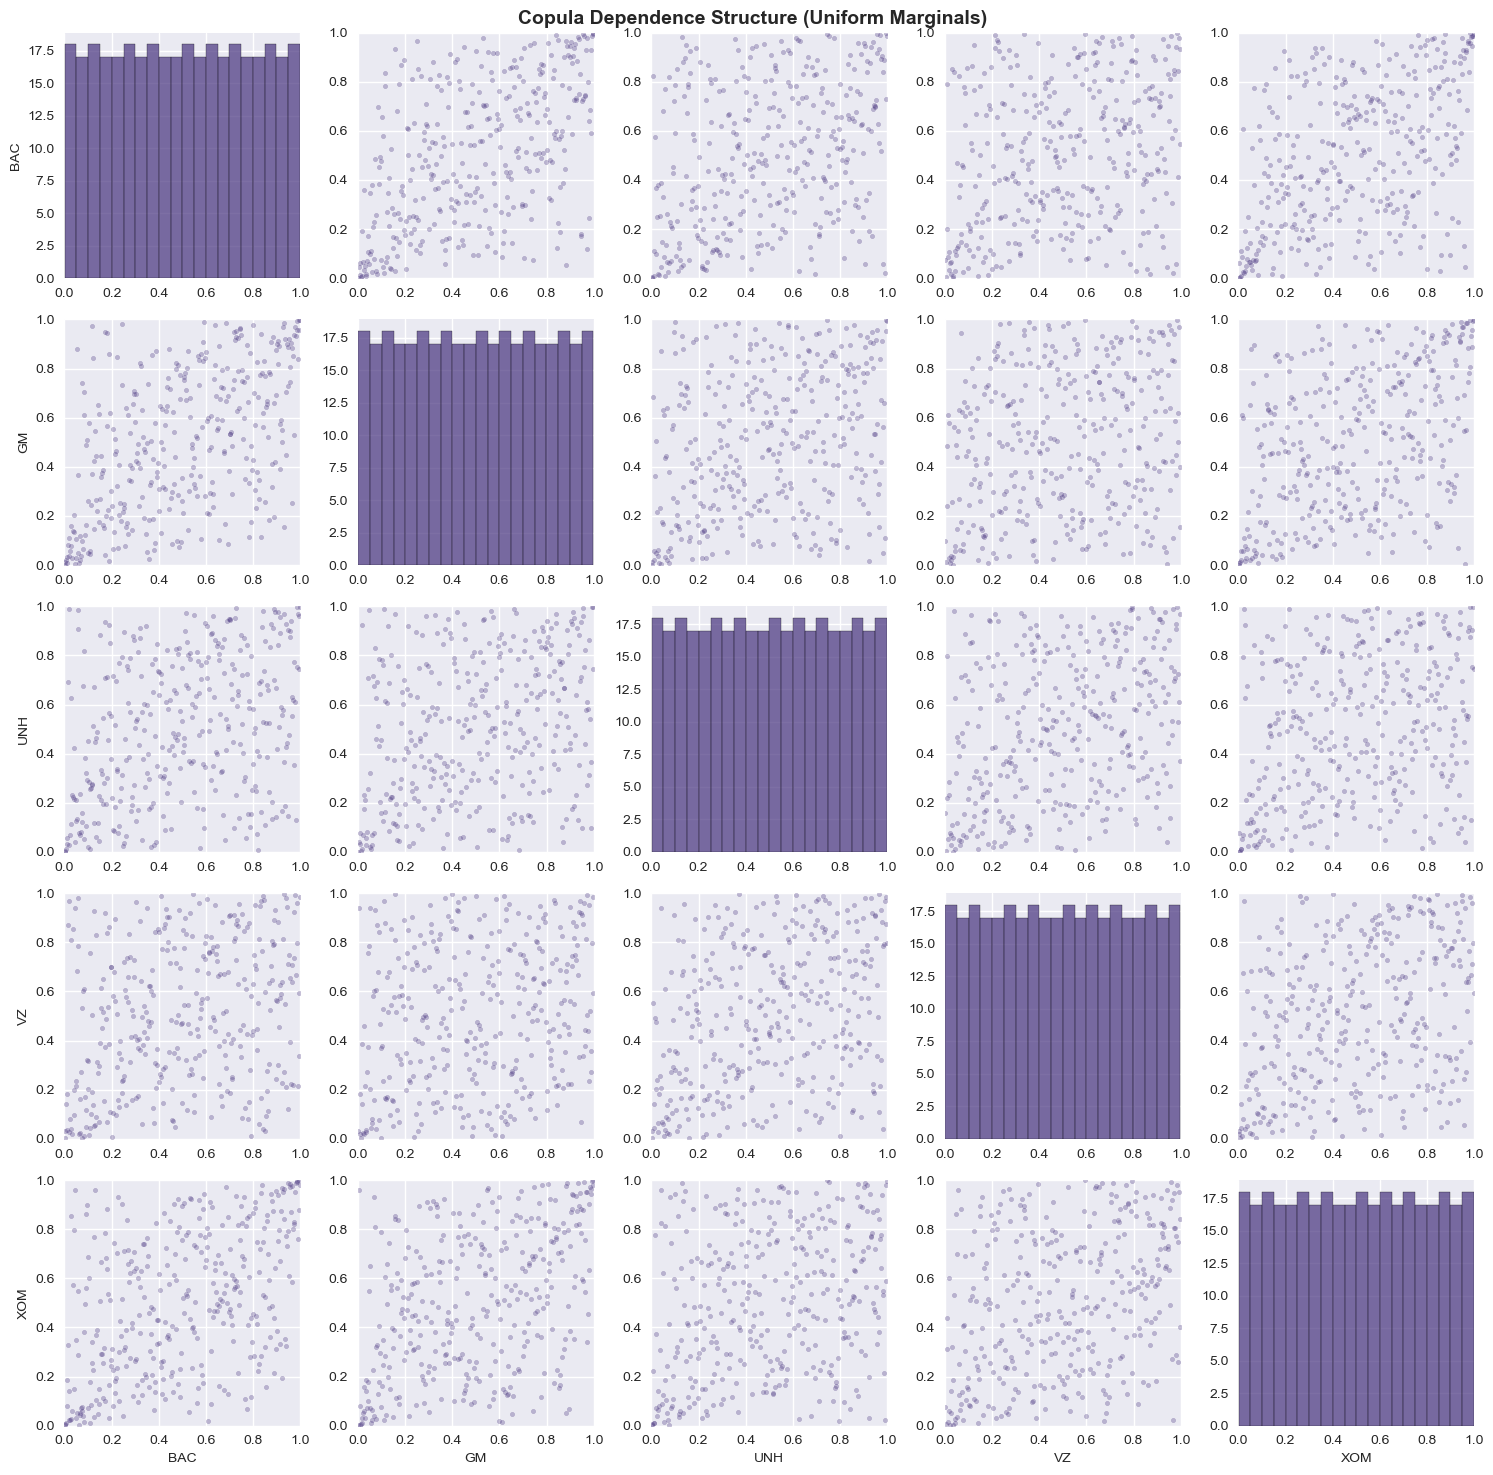

Plot saved as "compare_copula_samples.png"


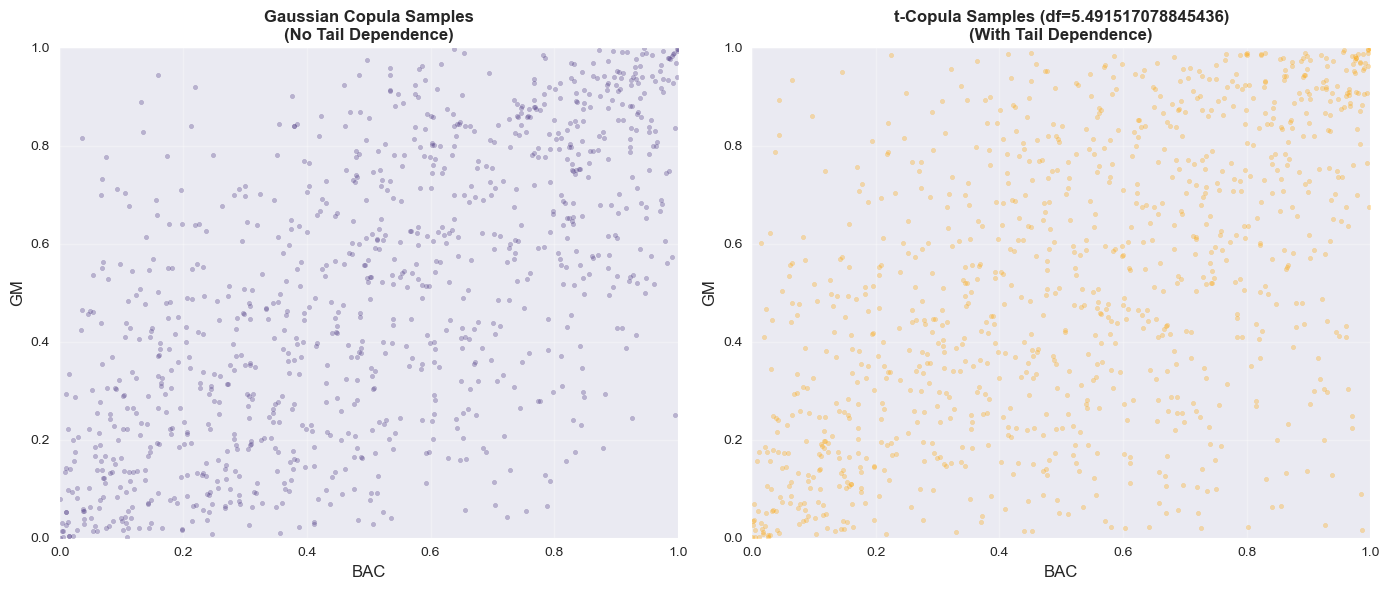

In [39]:
def estimate_correlation_matrices(equity_weekly_log_returns):
    """
    Estimate both Pearson (linear) and Spearman (rank) correlation matrices.
    
    Pearson: Measures linear correlation - suitable for Gaussian copula
    Spearman: Measures rank correlation - more robust, suitable for t-copula
    """
    
    # Pearson (Linear) Correlation
    pearson_corr = equity_weekly_log_returns.corr(method='pearson')
    
    # Spearman (Rank) Correlation
    spearman_corr = equity_weekly_log_returns.corr(method='spearman')
    
    return pearson_corr, spearman_corr

def returns_to_uniform(equity_weekly_log_returns):
    """
    Transform returns to uniform [0,1] using empirical CDF (rank transformation).
    This is crucial for copula fitting - copulas work on uniform marginals.
    """
    n = len(equity_weekly_log_returns)
    uniform_data = pd.DataFrame(index=equity_weekly_log_returns.index,
                                columns=equity_weekly_log_returns.columns)
    
    for col in equity_weekly_log_returns.columns:
        # Rank-based transformation: (rank - 0.5) / n
        # Subtracting 0.5 prevents values exactly at 0 or 1
        ranks = equity_weekly_log_returns[col].rank()
        uniform_data[col] = (ranks - 0.5) / n
        
        # Stricter clip to avoid ppf warnings
        uniform_data[col] = np.clip(uniform_data[col], 1e-6, 1 - 1e-6)
    
    return uniform_data

def gaussian_copula_log_likelihood(uniform_data, correlation_matrix):
    """
    Compute log-likelihood for Gaussian copula.
    Used for validation and comparison with t-copula.
    
    Gaussian copula only needs correlation matrix - no df parameter.
    """
    
    n_obs, n_vars = uniform_data.shape
    
    # Transform uniform data to standard normal quantiles
    normal_quantiles = stats.norm.ppf(uniform_data.values)
    
    # Handle extreme values
    normal_quantiles = np.clip(normal_quantiles, -8, 8)
    
    # Compute log-likelihood
    log_lik = 0
    
    try:
        corr_inv = np.linalg.inv(correlation_matrix)
        corr_det = np.linalg.det(correlation_matrix)
        
        for i in range(n_obs):
            x = normal_quantiles[i, :]
            
            # Quadratic form: x' * inv(Corr) * x
            quad_form = x @ corr_inv @ x
            
            # Gaussian copula log-density
            c_density = (
                -0.5 * np.log(corr_det)
                - 0.5 * quad_form
                + 0.5 * np.sum(x**2)  # Add back marginal densities
            )
            
            log_lik += c_density
            
    except (np.linalg.LinAlgError, ValueError):
        return -np.inf
    
    return log_lik

def validate_gaussian_copula(uniform_data, correlation_matrix):
    """
    Validate Gaussian copula fit.
    """
    
    print("="*50)
    print("GAUSSIAN COPULA VALIDATION")
    print("="*50)
    
    # Compute log-likelihood
    log_lik = gaussian_copula_log_likelihood(uniform_data, correlation_matrix.values)
    
    print(f"Log-Likelihood: {log_lik:.2f}")
    print(f"Number of parameters: {correlation_matrix.shape[0] * (correlation_matrix.shape[0] - 1) // 2}")
    
    # AIC = -2*log_lik + 2*k
    n_params = correlation_matrix.shape[0] * (correlation_matrix.shape[0] - 1) // 2
    aic = -2 * log_lik + 2 * n_params
    print(f"AIC: {aic:.2f}")
    
    print("="*50)
    print("\n")
    
    return log_lik

def t_copula_log_likelihood(df, uniform_data, correlation_matrix):
    """
    Log-likelihood function for t-copula.
    We maximize this to find optimal degrees of freedom parameter.
    """
    n_obs, n_vars = uniform_data.shape
    
    # Transform uniform data to t-distribution quantiles
    t_quantiles = stats.t.ppf(uniform_data.values, df=df)  # Convert to array first
    
    # Handle infinite values (can occur at extreme quantiles)
    t_quantiles = np.clip(t_quantiles, -10, 10)
    
    if np.any(np.isnan(t_quantiles)):
        return -np.inf
    
    # Compute log-likelihood
    log_lik = 0
    
    try:
        # Multivariate t-distribution density
        corr_inv = np.linalg.inv(correlation_matrix)
        corr_det = np.linalg.det(correlation_matrix)
        
        if corr_det <= 0:
            return -np.inf
        
        # Precompute marginal log-densities (vectorized for efficiency)
        t_pdfs = stats.t.pdf(t_quantiles, df=df)
        log_marginals = np.log(np.maximum(t_pdfs, 1e-10))  # Safe log: clip tiny pdfs to epsilon
        
        for i in range(n_obs):
            x = t_quantiles[i, :]  # Now it's already a numpy array
            
            # Quadratic form: x' * inv(Corr) * x
            quad_form = x @ corr_inv @ x
            
            # Multivariate t copula log-density
            # Use gammaln instead of np.log(stats.gamma())
            c_density = (
                gammaln((df + n_vars) / 2)  # log(Gamma(a)) using gammaln
                - gammaln(df / 2)           # log(Gamma(b)) using gammaln
                - (n_vars / 2) * np.log(df * np.pi)
                - 0.5 * np.log(corr_det)
                - ((df + n_vars) / 2) * np.log(1 + quad_form / df)
            )
            
            # Subtract marginal t-densities (sum over vars)
            c_density -= np.sum(log_marginals[i, :])
            
            log_lik += c_density
            
    except (np.linalg.LinAlgError, ValueError, RuntimeWarning):
        return -np.inf
    
    return log_lik

def calibrate_t_copula(uniform_data, correlation_matrix):
    """
    Calibrate t-copula by finding optimal degrees of freedom parameter.
    Search range: 3 to 30 degrees of freedom (grid), then refine with optimizer.
    """
    
    print("="*50)
    print("CALIBRATING T-COPULA (Estimating Degrees of Freedom)")
    print("="*50)
    
    # Grid search for initial estimate
    df_range = np.arange(3, 31, 1)
    log_liks = []
    
    for df in df_range:
        ll = t_copula_log_likelihood(df, uniform_data, correlation_matrix.values)
        log_liks.append(ll)
        if df % 5 == 0:
            print(f"df = {df:2.0f}: Log-Likelihood = {ll:.2f}")
    
    # Find optimal from grid
    optimal_idx = np.argmax(log_liks)
    df_init = df_range[optimal_idx]
    optimal_ll_grid = log_liks[optimal_idx]
    
    # Refine with optimizer: minimize -LL
    def neg_ll(df_scalar):
        return -t_copula_log_likelihood(df_scalar[0], uniform_data, correlation_matrix.values)
    
    res = minimize(neg_ll, x0=[df_init], bounds=[(3, 100)], method='L-BFGS-B')
    optimal_df = res.x[0]
    optimal_ll = -res.fun
    
    # Check if near-Gaussian
    if optimal_df > 50:
        print("Warning: High df (>50) suggests Gaussian-like dependence.")
    
    # AIC for t-copula
    n_params = correlation_matrix.shape[0] * (correlation_matrix.shape[0] - 1) // 2 + 1  # +1 for df
    aic = -2 * optimal_ll + 2 * n_params
    
    print(f"\nGrid Optimal df: {df_init} (LL={optimal_ll_grid:.2f})")
    print(f"Refined Optimal Degrees of Freedom: {optimal_df:.2f}")
    print(f"Refined Maximum Log-Likelihood: {optimal_ll:.2f}")
    print(f"AIC: {aic:.2f}")
    print("="*50)
    print("\n")
    
    return optimal_df, log_liks, df_range

def sample_gaussian_copula(correlation_matrix, n_samples=1000):
    """
    Sample from Gaussian copula.
    
    Process:
    1. Sample from multivariate normal with given correlation
    2. Transform to uniform using standard normal CDF
    """
    
    n_vars = correlation_matrix.shape[0]
    
    # Sample from multivariate normal
    mean = np.zeros(n_vars)
    mvn_samples = np.random.multivariate_normal(mean, correlation_matrix, size=n_samples)
    
    # Transform to uniform
    uniform_samples = stats.norm.cdf(mvn_samples)
    
    return uniform_samples

def sample_t_copula(correlation_matrix, df, n_samples=1000):
    """
    Sample from t-copula.
    
    Process:
    1. Sample from multivariate t-distribution
    2. Transform to uniform using t-distribution CDF
    """
    
    n_vars = correlation_matrix.shape[0]
    
    # Sample from multivariate t-distribution
    # Method: Z ~ N(0, Corr), S ~ chi^2(df), then X = Z / sqrt(S/df)
    
    mean = np.zeros(n_vars)
    mvn_samples = np.random.multivariate_normal(mean, correlation_matrix, size=n_samples)
    
    # Sample chi-squared and scale
    chi2_samples = np.random.chisquare(df, size=n_samples)
    scale = np.sqrt(chi2_samples / df)
    
    # Create t-distributed samples
    mvt_samples = mvn_samples / scale[:, np.newaxis]
    
    # Transform to uniform
    uniform_samples = stats.t.cdf(mvt_samples, df=df)
    
    return uniform_samples

def compare_copulae(uniform_data, pearson_corr, spearman_corr, t_df):
    """
    Compare Gaussian and t-copula fits, testing t with both corr types.
    """
    
    print("="*50)
    print("COPULA COMPARISON SUMMARY")
    print("="*50)
    
    # Gaussian copula (Pearson)
    gaussian_ll = gaussian_copula_log_likelihood(uniform_data, pearson_corr.values)
    n_params_gaussian = pearson_corr.shape[0] * (pearson_corr.shape[0] - 1) // 2
    aic_gaussian = -2 * gaussian_ll + 2 * n_params_gaussian
    
    # t-copula with Spearman
    t_ll_spear = t_copula_log_likelihood(t_df, uniform_data, spearman_corr.values)
    aic_t_spear = -2 * t_ll_spear + 2 * (n_params_gaussian + 1)
    
    # t-copula with Pearson (test for comparison)
    t_ll_pear = t_copula_log_likelihood(t_df, uniform_data, pearson_corr.values)
    aic_t_pear = -2 * t_ll_pear + 2 * (n_params_gaussian + 1)
    
    print(f"\nGaussian Copula (Pearson Corr):")
    print(f"  Log-Likelihood: {gaussian_ll:.2f}")
    print(f"  AIC: {aic_gaussian:.2f}")
    
    print(f"\nt-Copula (Spearman Corr, df={t_df}):")
    print(f"  Log-Likelihood: {t_ll_spear:.2f}")
    print(f"  AIC: {aic_t_spear:.2f}")
    
    print(f"\nt-Copula (Pearson Corr, df={t_df}):")
    print(f"  Log-Likelihood: {t_ll_pear:.2f}")
    print(f"  AIC: {aic_t_pear:.2f}")
    
    # Best overall
    aics = {'Gaussian': aic_gaussian, 't-Spearman': aic_t_spear, 't-Pearson': aic_t_pear}
    best_model = min(aics, key=aics.get)
    print(f"\nBest Model (Lowest AIC): {best_model} (AIC={aics[best_model]:.2f})")
    
    print("="*50)
    print("\n")
    
    return {
        'gaussian_ll': gaussian_ll, 'gaussian_aic': aic_gaussian,
        't_ll_spear': t_ll_spear, 't_aic_spear': aic_t_spear,
        't_ll_pear': t_ll_pear, 't_aic_pear': aic_t_pear,
        't_df': t_df, 'best': best_model
    }

def plot_correlation_matrices(pearson_corr, spearman_corr):
    """
    Visualize both correlation matrices as heatmaps.
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Pearson correlation
    sns.heatmap(pearson_corr, annot=True, fmt='.3f', cmap='RdYlGn', 
                center=0, vmin=-1, vmax=1, ax=axes[0], 
                cbar_kws={'label': 'Correlation'})
    axes[0].set_title('Pearson Correlation Matrix\n(For Gaussian Copula)', 
                     fontsize=12, fontweight='bold')
    
    # Spearman correlation
    sns.heatmap(spearman_corr, annot=True, fmt='.3f', cmap='RdYlGn', 
                center=0, vmin=-1, vmax=1, ax=axes[1],
                cbar_kws={'label': 'Correlation'})
    axes[1].set_title('Spearman Correlation Matrix\n(For t-Copula)', 
                     fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    
    # Save the plot
    plt.savefig('correlation_matrices.png', dpi=300)
    print("Plot saved as 'correlation_matrices.png'")

    plt.show()

def plot_t_copula_calibration(df_range, log_liks, optimal_df):
    """
    Plot log-likelihood vs degrees of freedom to visualize calibration.
    """
    
    plt.figure(figsize=(10, 6))
    plt.plot(df_range, log_liks, 'b-', linewidth=2, label='Log-Likelihood')
    plt.axvline(optimal_df, color='r', linestyle='--', linewidth=2, 
                label=f'Optimal df = {optimal_df}')
    plt.xlabel('Degrees of Freedom', fontsize=12)
    plt.ylabel('Log-Likelihood', fontsize=12)
    plt.title('T-Copula Calibration: Log-Likelihood vs Degrees of Freedom', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()

    # Save the plot
    plt.savefig('t_copula_calibration.png', dpi=300)
    print("Plot saved as 't_copula_calibration.png'")

    plt.show()

def check_uniformity(uniform_data):
    """
    Validate that transformed data is approximately uniform.
    This is essential for copula fitting.
    """
    fig, axes = plt.subplots(1, 5, figsize=(18, 3))
    
    ks_results = {}
    for i, col in enumerate(uniform_data.columns):
        axes[i].hist(uniform_data[col], bins=30, density=True,
                     alpha=0.7, edgecolor='black')
        axes[i].axhline(y=1.0, color='r', linestyle='--',
                        label='Uniform(0,1)')
        axes[i].set_title(f'{col}', fontweight='bold')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Density')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # KS test
        ks_stat, p_value = kstest(uniform_data[col], 'uniform')
        ks_results[col] = {'statistic': ks_stat, 'p_value': p_value}
        print(f"{col}: KS stat={ks_stat:.4f}, p-value={p_value:.4f} (uniform if p>0.05)")
    
    plt.suptitle('Uniformity Check: Histograms of Pseudo-Observations',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()

    # Save the plot
    plt.savefig('uniformity_check.png', dpi=300)
    print('Plot saved as "uniformity_check.png"')
    
    plt.show()
    
    return ks_results  # For logging

def plot_copula_dependence(uniform_data):
    """
    Visualize pairwise dependence structure in copula space.
    """
    
    # Create pairwise scatter plots
    companies = uniform_data.columns.tolist()
    n_pairs = len(companies)
    
    fig, axes = plt.subplots(n_pairs, n_pairs, figsize=(15, 15))
    
    for i in range(n_pairs):
        for j in range(n_pairs):
            if i == j:
                # Diagonal: histograms
                axes[i, j].hist(uniform_data.iloc[:, i], bins=20, 
                              alpha=0.7, edgecolor='black')
                axes[i, j].set_xlim([0, 1])
            else:
                # Off-diagonal: scatter plots
                axes[i, j].scatter(uniform_data.iloc[:, j], 
                                 uniform_data.iloc[:, i], 
                                 alpha=0.3, s=10)
                axes[i, j].set_xlim([0, 1])
                axes[i, j].set_ylim([0, 1])
            
            # Labels
            if j == 0:
                axes[i, j].set_ylabel(companies[i], fontsize=10)
            if i == n_pairs - 1:
                axes[i, j].set_xlabel(companies[j], fontsize=10)
    
    plt.suptitle('Copula Dependence Structure (Uniform Marginals)', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()

    # Save the plot
    plt.savefig('copula_dependence.png', dpi=300)
    print('Plot saved as "copula_dependence.png"')

    plt.show()

def compare_copula_samples(pearson_corr, spearman_corr, t_df, n_samples=1000):
    """
    Generate and compare samples from both copulae.
    """
    
    # Generate samples
    gaussian_samples = sample_gaussian_copula(pearson_corr.values, n_samples)
    t_samples = sample_t_copula(spearman_corr.values, t_df, n_samples)
    
    # Plot first two dimensions for comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Gaussian copula samples
    axes[0].scatter(gaussian_samples[:, 0], gaussian_samples[:, 1], 
                   alpha=0.3, s=10)
    axes[0].set_xlim([0, 1])
    axes[0].set_ylim([0, 1])
    axes[0].set_xlabel(f'{pearson_corr.columns[0]}', fontsize=12)
    axes[0].set_ylabel(f'{pearson_corr.columns[1]}', fontsize=12)
    axes[0].set_title('Gaussian Copula Samples\n(No Tail Dependence)', 
                     fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # t-copula samples
    axes[1].scatter(t_samples[:, 0], t_samples[:, 1], 
                   alpha=0.3, s=10, color='orange')
    axes[1].set_xlim([0, 1])
    axes[1].set_ylim([0, 1])
    axes[1].set_xlabel(f'{spearman_corr.columns[0]}', fontsize=12)
    axes[1].set_ylabel(f'{spearman_corr.columns[1]}', fontsize=12)
    axes[1].set_title(f't-Copula Samples (df={t_df})\n(With Tail Dependence)', 
                     fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()

    # Save the plot
    plt.savefig('compare_copula_samples.png', dpi=300)
    print('Plot saved as "compare_copula_samples.png"')

    plt.show()

def main(equity_weekly_log_returns):
    """
    Main function to execute all steps
    """
    
    print("\n" + "="*50)
    print("CORRELATION ESTIMATION AND COPULA CALIBRATION")
    print("="*50 + "\n")

    # Set random seed for reproducibility
    np.random.seed(42)

    # Handle numerical warnings from extreme quantiles
    np.seterr(all='warn')  # Keep warnings visible but handle them
    
    # Step 1: Estimate correlation matrices
    pearson_corr, spearman_corr = estimate_correlation_matrices(equity_weekly_log_returns)
    
    # Step 2: Convert to uniform variables
    uniform_data = returns_to_uniform(equity_weekly_log_returns)
    
    # Step 3: Validate Gaussian copula
    gaussian_ll = validate_gaussian_copula(uniform_data, pearson_corr)
    
    # Step 4: Calibrate t-copula
    optimal_df, log_liks, df_range = calibrate_t_copula(uniform_data, spearman_corr)
    
    # Step 5: Compare both copulae
    comparison = compare_copulae(uniform_data, pearson_corr, spearman_corr, optimal_df)
    
    # Step 6: Visualizations
    plot_correlation_matrices(pearson_corr, spearman_corr)
    plot_t_copula_calibration(df_range, log_liks, optimal_df)
    check_uniformity(uniform_data)
    plot_copula_dependence(uniform_data)
    compare_copula_samples(pearson_corr, spearman_corr, optimal_df, n_samples=1000)
    
    # Return calibrated parameters
    results = {
        'pearson_correlation': pearson_corr,
        'spearman_correlation': spearman_corr,
        'uniform_data': uniform_data,
        't_copula_df': optimal_df,
        'gaussian_log_likelihood': gaussian_ll,
        't_log_likelihood': comparison['t_ll_spear'],
        'comparison': comparison,
        'log_likelihoods': log_liks,
        'df_range': df_range
    }
    
    return results


if __name__ == "__main__":
    results_calibration = main(equity_weekly_log_returns)

### Calculating the Fair Spread for the Basket CDS


Running GAUSSIAN Copula Simulation
Number of simulations: 100,000
Reference names: 5
Maturity: 5.0 years
Recovery rate: 40.0%
Using low-discrepancy (Sobol) sequences

Generating correlated uniform variables...
  Generated uniform samples shape: (100000, 5)
  Uniform samples range: [0.0000, 1.0000]

Converting uniforms to default times...
  Default times shape: (100000, 5)
  Default times range: [0.0002, 1239.9260] years

Calculating premium and default legs...

Calculating fair spreads...

FAIR SPREADS (basis points)
1th-to-default:   184.87 bps
2th-to-default:    48.97 bps
3th-to-default:    14.56 bps
4th-to-default:     3.71 bps
5th-to-default:     0.57 bps


Running T Copula Simulation
Number of simulations: 100,000
Reference names: 5
Maturity: 5.0 years
Recovery rate: 40.0%
Using low-discrepancy (Sobol) sequences

Generating correlated uniform variables...
  Using Sobol sequences for all 6 dimensions (full variance reduction)
  Generated uniform samples shape: (100000, 5)
  Unifor

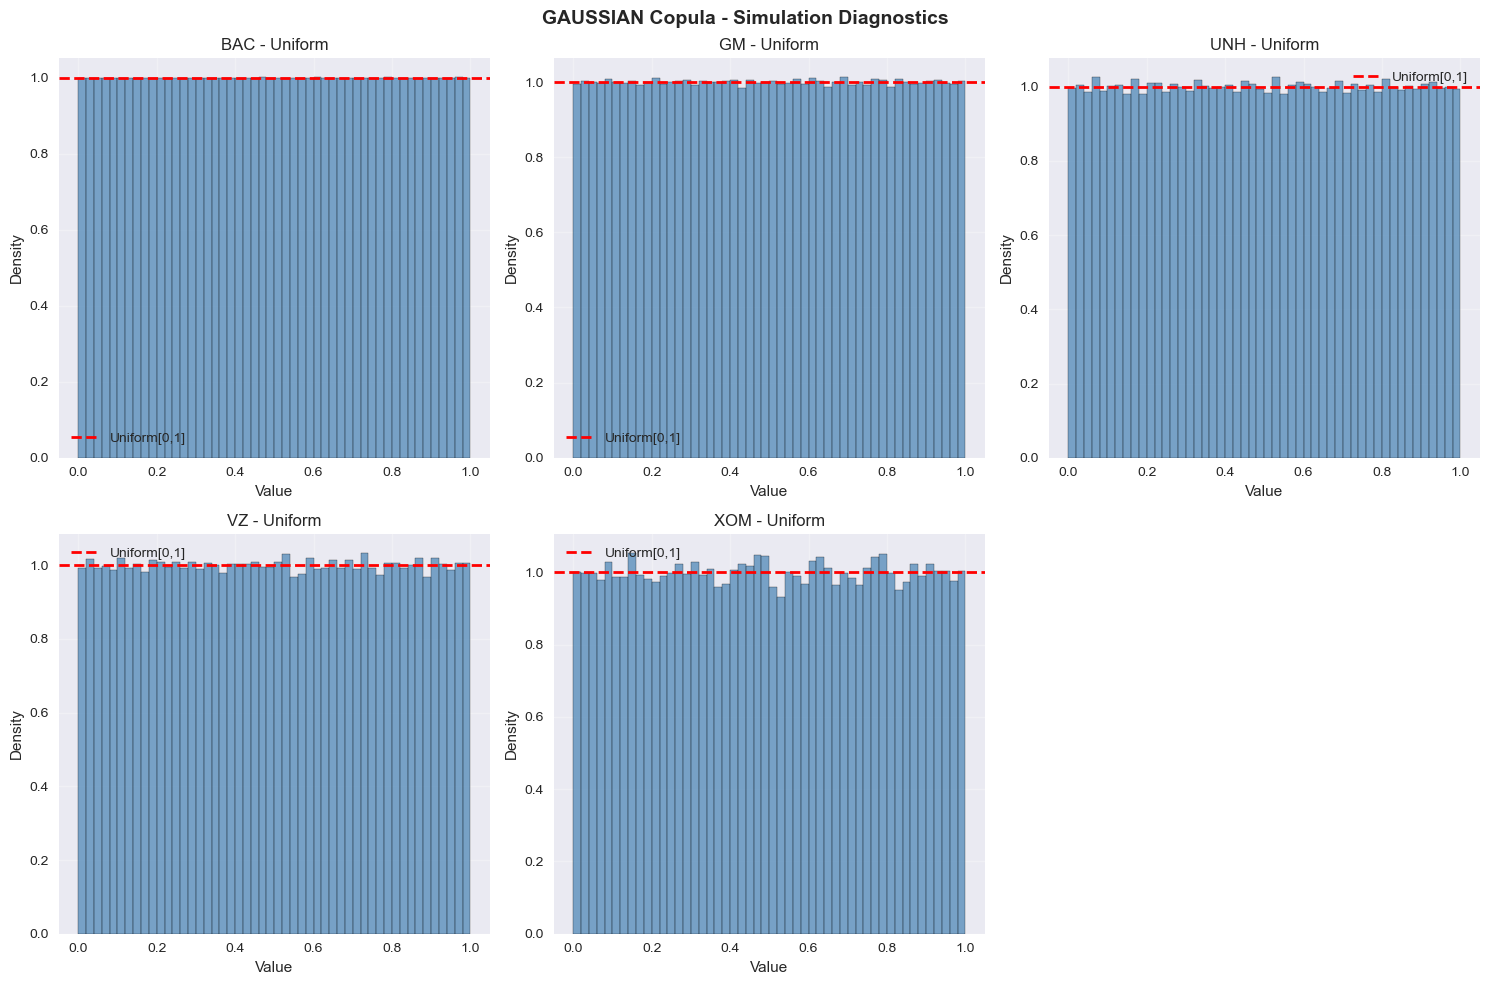

Plot saved as 'gaussian_copula_default_times.png'


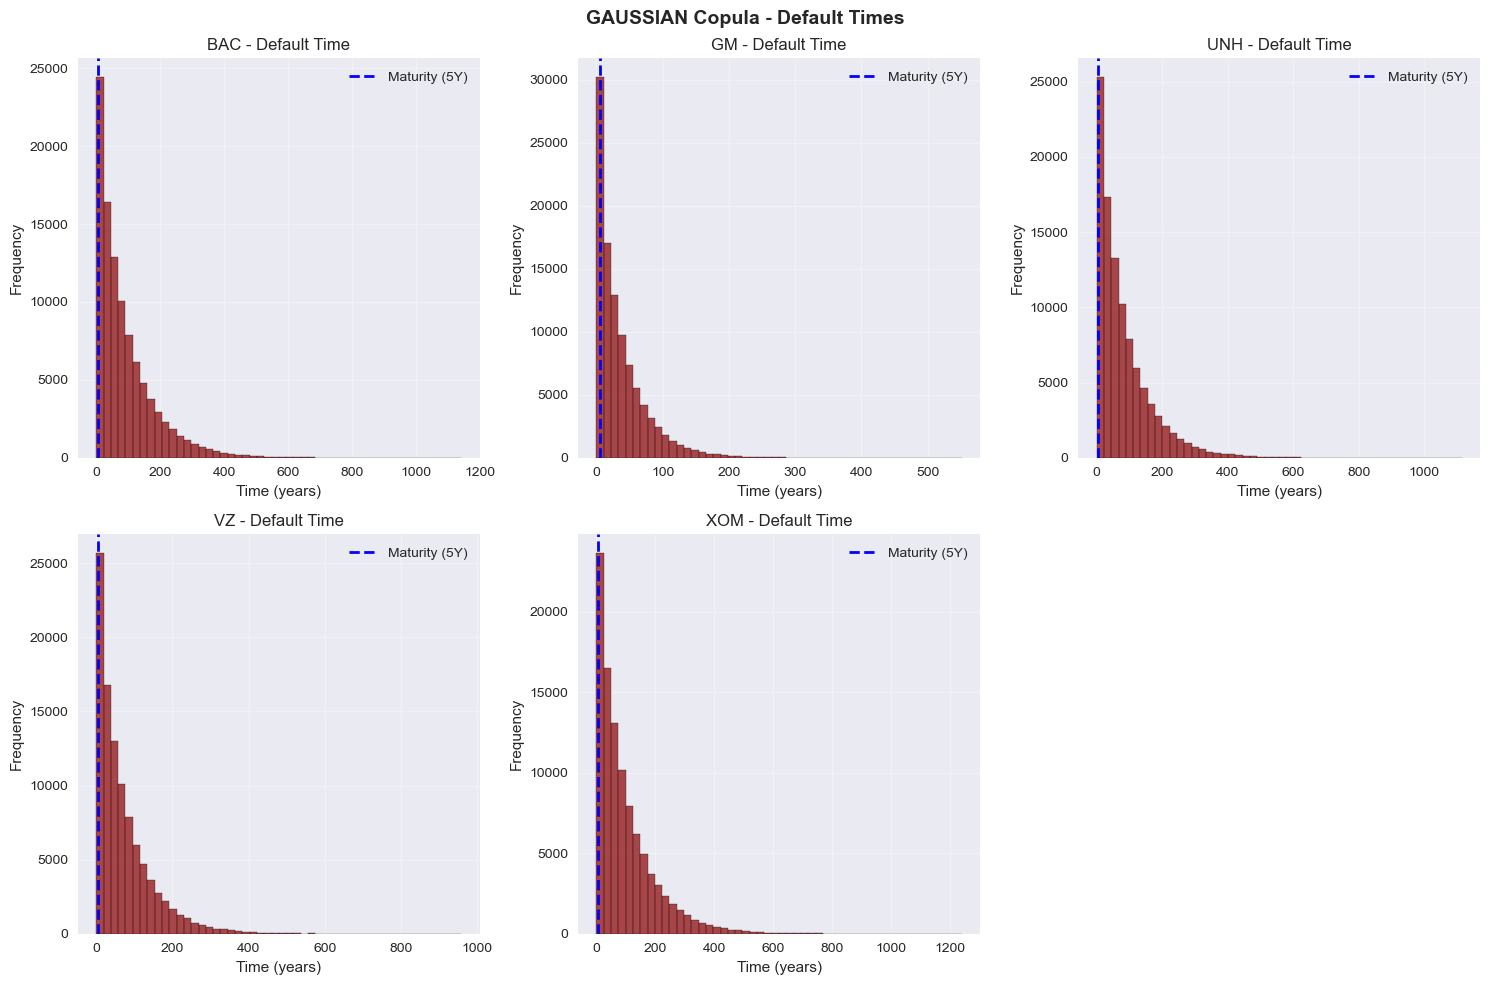

Plot saved as 't_copula_simulation_diagnostics.png'


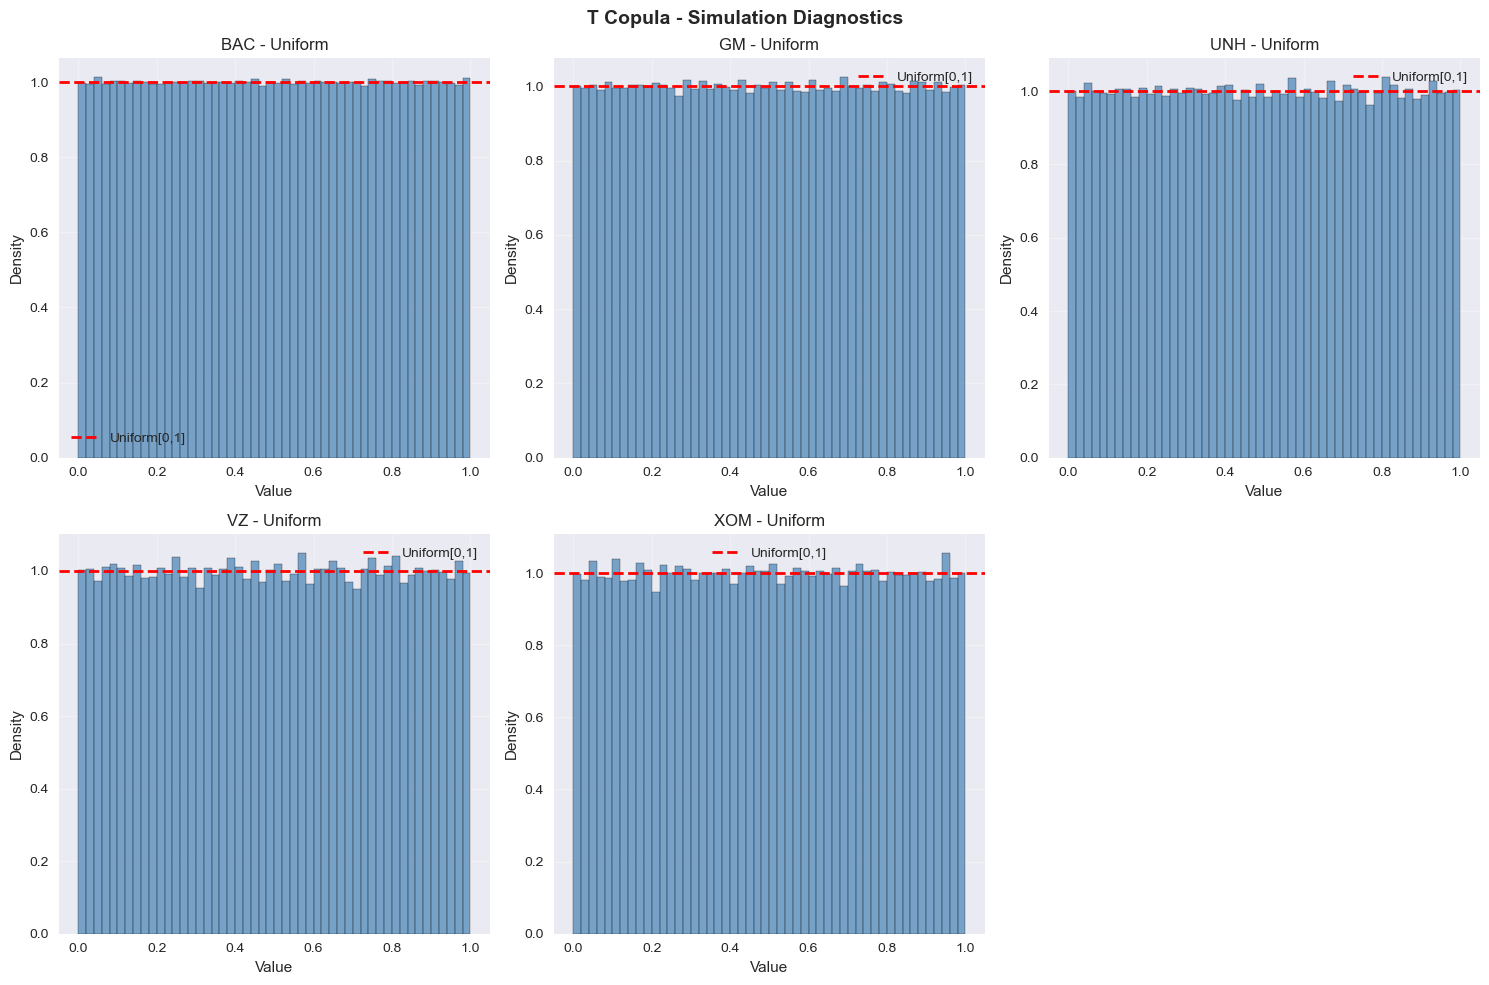

Plot saved as 't_copula_default_times.png'


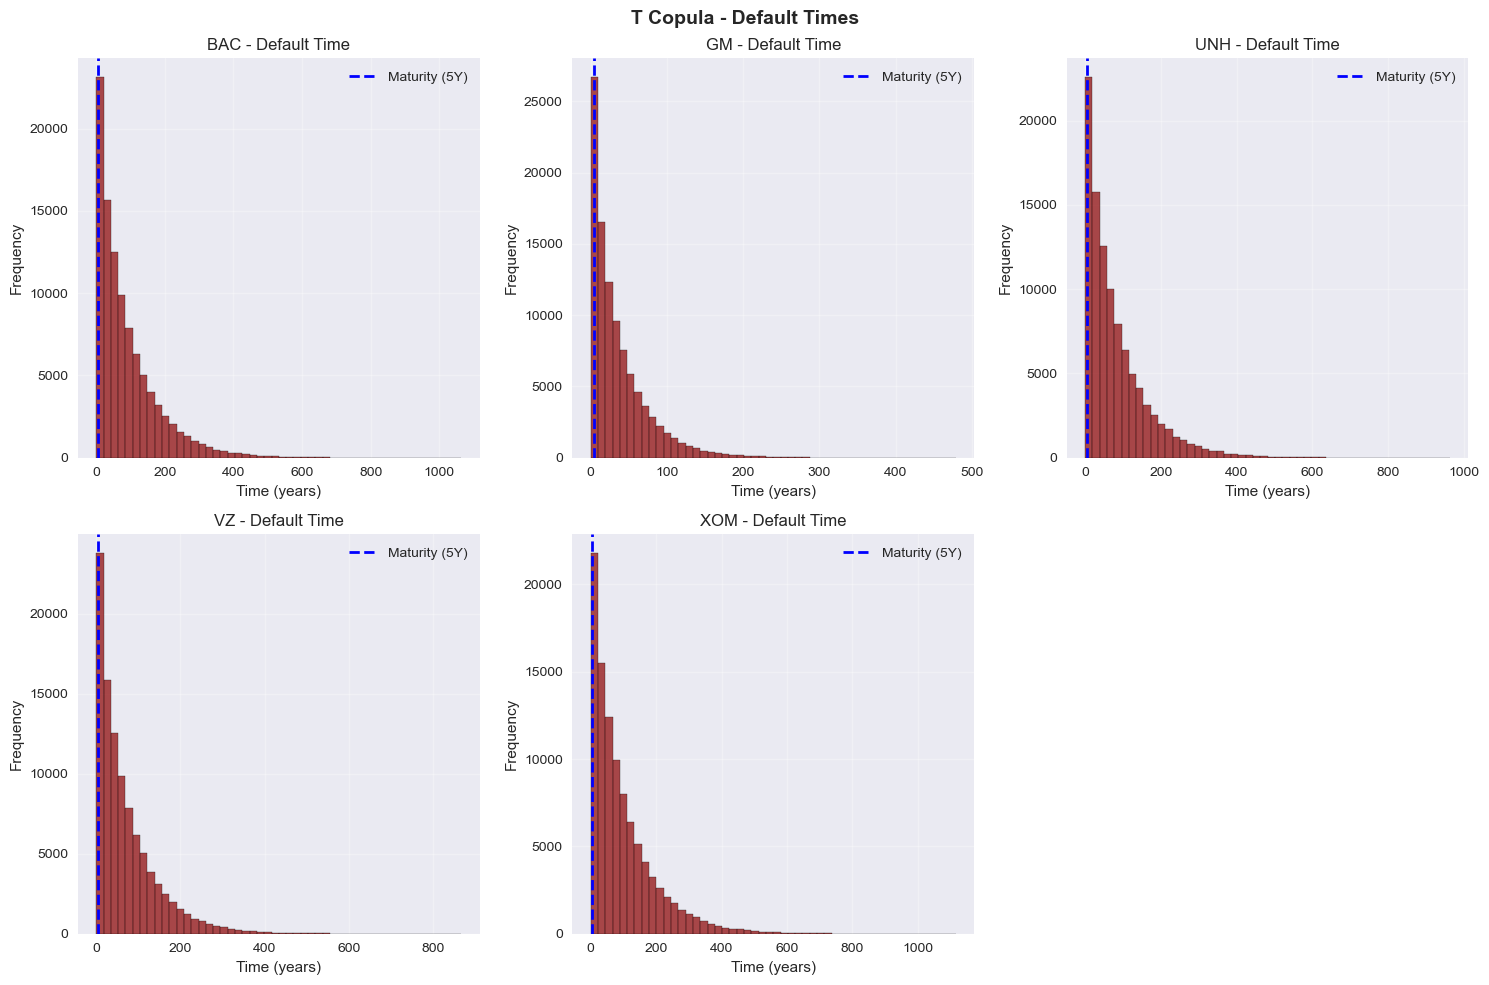

In [40]:
class BasketCDSPricer:
    """
    Monte Carlo pricer for k-th to default Basket CDS
    """
    
    def __init__(self, df_bootstrap, discount_factors, recovery_rate=0.4):
        """
        Initialize the pricer
        """
        self.df_bootstrap = df_bootstrap
        self.discount_factors = discount_factors
        self.recovery_rate = recovery_rate
        self.tickers = df_bootstrap['Ticker'].unique()
        self.n_names = len(self.tickers)
        
        # Create hazard rate interpolators for each name
        self.hazard_interpolators = self._create_hazard_interpolators()
        
        # Create discount factor interpolator
        self.discount_interpolator = interp1d(
            discount_factors['Tenor'].values,
            discount_factors['DiscountFactor'].values,
            kind='linear',
            fill_value='extrapolate'
        )
    
    def _create_hazard_interpolators(self):
        """Create piecewise constant hazard rate functions for each name"""
        interpolators = {}
        
        for ticker in self.tickers:
            ticker_data = self.df_bootstrap[self.df_bootstrap['Ticker'] == ticker].sort_values('Tenor')
            tenors = ticker_data['Tenor'].values
            hazard_rates = ticker_data['Hazard_Rate'].values
            
            # Piecewise constant hazard rates
            interpolators[ticker] = {
                'tenors': np.concatenate([[0], tenors]),
                'hazard_rates': hazard_rates
            }
        
        return interpolators
    
    def generate_correlated_uniforms_gaussian(self, correlation_matrix, n_simulations, 
                                               use_quasi_random=False, seed=42):
        """
        Generate correlated uniform random variables using Gaussian copula
        """
        np.random.seed(seed)
        
        # Cholesky decomposition of correlation matrix
        try:
            L = np.linalg.cholesky(correlation_matrix)
        except np.linalg.LinAlgError:
            # If not positive definite, use nearest positive definite matrix
            correlation_matrix = self._nearest_positive_definite(correlation_matrix)
            L = np.linalg.cholesky(correlation_matrix)
        
        if use_quasi_random:
            # Use Sobol sequence (requires scipy >= 1.7)
            try:
                sobol = Sobol(d=self.n_names, scramble=True, seed=seed)
                standard_normals = norm.ppf(sobol.random(n_simulations))
            except ImportError:
                print("Sobol sequence not available, using pseudo-random")
                standard_normals = np.random.standard_normal((n_simulations, self.n_names))
        else:
            # Standard pseudo-random normal variables
            standard_normals = np.random.standard_normal((n_simulations, self.n_names))
        
        # Apply correlation structure: Z = L @ eps
        correlated_normals = standard_normals @ L.T
        
        # Transform to uniform using standard normal CDF
        uniform_samples = norm.cdf(correlated_normals)
        
        return uniform_samples
    
    def generate_correlated_uniforms_t(self, correlation_matrix, df, n_simulations,
                                       use_quasi_random=False, seed=42):
        """
        Generate correlated uniform random variables using t-copula
        """
        np.random.seed(seed)
        
        # Cholesky decomposition
        try:
            L = np.linalg.cholesky(correlation_matrix)
        except np.linalg.LinAlgError:
            correlation_matrix = self._nearest_positive_definite(correlation_matrix)
            L = np.linalg.cholesky(correlation_matrix)
        
        if use_quasi_random:
            try:
                # Generate Sobol sequence with n_names+1 dimensions
                # First n_names for correlated normals, last dimension for chi-square
                sobol = Sobol(d=self.n_names + 1, scramble=True, seed=seed)
                quasi_samples = sobol.random(n_simulations)
                
                # First n_names dimensions: transform to standard normals
                standard_normals = norm.ppf(quasi_samples[:, :self.n_names])
                
                # FIXED: Last dimension for chi-square using inverse CDF (not pseudo-random)
                # Transform uniform to chi-square via inverse CDF
                chi2_samples = chi2.ppf(quasi_samples[:, self.n_names], df)
                
                # Handle edge cases where ppf might return inf or nan
                chi2_samples = np.clip(chi2_samples, 1e-10, 1e10)
                
                print(f"  Using Sobol sequences for all {self.n_names + 1} dimensions (full variance reduction)")
                
            except ImportError:
                print("  Sobol sequence not available, using pseudo-random")
                standard_normals = np.random.standard_normal((n_simulations, self.n_names))
                chi2_samples = np.random.chisquare(df, n_simulations)
        else:
            # Pseudo-random generation
            standard_normals = np.random.standard_normal((n_simulations, self.n_names))
            chi2_samples = np.random.chisquare(df, n_simulations)
        
        # Apply correlation structure: Z = L @ eps
        correlated_normals = standard_normals @ L.T
        
        # Transform to t-distributed: X = Z / sqrt(S/df)
        # This creates the heavy-tailed dependence structure
        correlated_t = correlated_normals / np.sqrt(chi2_samples / df)[:, np.newaxis]
        
        # Transform to uniform using t-distribution CDF
        uniform_samples = t_dist.cdf(correlated_t, df=df)
        
        return uniform_samples
    
    def uniform_to_default_time(self, uniform_samples):
        """
        Convert uniform random variables to default times using hazard rates
        
        Theory: U ~ Uniform(0,1), τ ~ F where F(τ) = 1 - S(τ)
        Therefore: S(τ) = 1 - U, solve exp(-H(τ)) = 1 - U
        """
        n_simulations = uniform_samples.shape[0]
        default_times = np.zeros((n_simulations, self.n_names))
        
        for i, ticker in enumerate(self.tickers):
            hazard_data = self.hazard_interpolators[ticker]
            tenors = hazard_data['tenors']
            hazard_rates = hazard_data['hazard_rates']
            
            # For each simulation, find default time
            for sim in range(n_simulations):
                u = uniform_samples[sim, i]
                
                # CRITICAL FIX: Survival probability S(τ) = 1 - U
                # Small U → high survival → late default
                # Large U → low survival → early default
                target_survival = 1 - u
                
                # Handle edge cases
                if target_survival >= 1.0:
                    # U ≈ 0, no default (or very late)
                    default_times[sim, i] = 100.0
                    continue
                if target_survival <= 0.0:
                    # U ≈ 1, immediate default
                    default_times[sim, i] = 1e-6
                    continue
                
                # Piecewise constant hazard: cumulative hazard is piecewise linear
                cumulative_hazard = 0
                default_time = 0
                found_default = False
                
                for j in range(len(hazard_rates)):
                    tenor_start = tenors[j]
                    tenor_end = tenors[j + 1] if j < len(hazard_rates) - 1 else 10.0
                    hazard = hazard_rates[j]
                    
                    # Cumulative hazard at end of this period
                    period_cumulative = cumulative_hazard + hazard * (tenor_end - tenor_start)
                    survival_at_end = np.exp(-period_cumulative)
                    
                    # Check if default occurs in this period
                    # (survival drops below target in this interval)
                    if survival_at_end <= target_survival:
                        # Solve: exp(-(cumulative_hazard + hazard * dt)) = target_survival
                        # -(cumulative_hazard + hazard * dt) = log(target_survival)
                        # dt = -(log(target_survival) + cumulative_hazard) / hazard
                        
                        if hazard > 1e-10:
                            dt = -(np.log(target_survival) + cumulative_hazard) / hazard
                            default_time = tenor_start + dt
                        else:
                            # Hazard rate is zero, survival doesn't change
                            default_time = tenor_end
                        
                        found_default = True
                        break
                    
                    cumulative_hazard = period_cumulative
                
                if not found_default:
                    # Default occurs beyond last tenor
                    # Extrapolate using last hazard rate
                    if hazard_rates[-1] > 1e-10:
                        dt = -(np.log(target_survival) + cumulative_hazard) / hazard_rates[-1]
                        default_time = tenors[-1] + dt
                    else:
                        # No hazard, no default
                        default_time = 100.0
                
                default_times[sim, i] = default_time
        
        return default_times
    
    def calculate_basket_cds_legs(self, default_times, maturity=5.0, 
                                   payment_frequency=0.5):
        """
        Calculate premium and default legs for all k-th to default instruments
        """
        n_simulations = default_times.shape[0]
        
        # Payment schedule
        payment_dates = np.arange(payment_frequency, maturity + payment_frequency, 
                                   payment_frequency)
        
        # Sort default times for each simulation to find k-th defaults
        sorted_defaults = np.sort(default_times, axis=1)
        
        # Initialize storage for all k-th to default
        results = {}
        
        for k in range(1, self.n_names + 1):
            kth_default_times = sorted_defaults[:, k - 1]
            
            premium_leg = np.zeros(n_simulations)
            default_leg = np.zeros(n_simulations)
            
            for sim in range(n_simulations):
                tau_k = kth_default_times[sim]
                
                # Premium leg: sum of discounted premium payments until default or maturity
                for t in payment_dates:
                    if t <= min(tau_k, maturity):
                        df = self.discount_interpolator(t)
                        # Premium payment (spread is unknown, normalized to 1 bp)
                        premium_leg[sim] += df * payment_frequency
                
                # Add accrued premium if default occurs between payment dates
                if tau_k < maturity:
                    # Find last payment date before default
                    last_payment = payment_dates[payment_dates < tau_k]
                    if len(last_payment) > 0:
                        last_payment = last_payment[-1]
                    else:
                        last_payment = 0
                    
                    accrued_time = tau_k - last_payment
                    df = self.discount_interpolator(tau_k)
                    premium_leg[sim] += df * accrued_time
                
                # Default leg: loss given default if default occurs before maturity
                if tau_k < maturity:
                    df = self.discount_interpolator(tau_k)
                    lgd = 1.0 - self.recovery_rate  # Loss Given Default
                    default_leg[sim] = df * lgd
            
            results[f'{k}th_to_default'] = {
                'premium_leg': premium_leg,
                'default_leg': default_leg,
                'default_times': kth_default_times
            }
        
        return results
    
    def calculate_fair_spreads(self, basket_results):
        """
        Calculate fair spread for each k-th to default instrument
        
        Fair Spread = E[Default Leg] / E[Premium Leg]
        """
        spreads = {}
        
        for k in range(1, self.n_names + 1):
            key = f'{k}th_to_default'
            premium_leg = basket_results[key]['premium_leg']
            default_leg = basket_results[key]['default_leg']
            
            # Average across simulations
            avg_premium = np.mean(premium_leg)
            avg_default = np.mean(default_leg)
            
            # Fair spread in basis points
            if avg_premium > 0:
                fair_spread = (avg_default / avg_premium) * 10000
            else:
                fair_spread = np.nan
            
            spreads[key] = {
                'fair_spread_bps': fair_spread,
                'avg_premium_leg': avg_premium,
                'avg_default_leg': avg_default,
                'std_premium_leg': np.std(premium_leg),
                'std_default_leg': np.std(default_leg)
            }
        
        return spreads
    
    def run_simulation(self, correlation_matrix, n_simulations=10000, 
                      copula_type='gaussian', t_df=None, use_quasi_random=False,
                      maturity=5.0, seed=42):
        """
        Run complete Monte Carlo simulation
        """
        print(f"\n{'='*60}")
        print(f"Running {copula_type.upper()} Copula Simulation")
        print(f"{'='*60}")
        print(f"Number of simulations: {n_simulations:,}")
        print(f"Reference names: {self.n_names}")
        print(f"Maturity: {maturity} years")
        print(f"Recovery rate: {self.recovery_rate*100:.1f}%")
        if use_quasi_random:
            print("Using low-discrepancy (Sobol) sequences")
        print(f"{'='*60}\n")
        
        # Generate correlated uniforms
        print("Generating correlated uniform variables...")
        if copula_type.lower() == 'gaussian':
            uniform_samples = self.generate_correlated_uniforms_gaussian(
                correlation_matrix, n_simulations, use_quasi_random, seed
            )
        elif copula_type.lower() == 't':
            if t_df is None:
                raise ValueError("Degrees of freedom must be specified for t-copula")
            uniform_samples = self.generate_correlated_uniforms_t(
                correlation_matrix, t_df, n_simulations, use_quasi_random, seed
            )
        else:
            raise ValueError("copula_type must be 'gaussian' or 't'")
        
        print(f"  Generated uniform samples shape: {uniform_samples.shape}")
        print(f"  Uniform samples range: [{uniform_samples.min():.4f}, {uniform_samples.max():.4f}]")
        
        # Convert to default times
        print("\nConverting uniforms to default times...")
        default_times = self.uniform_to_default_time(uniform_samples)
        print(f"  Default times shape: {default_times.shape}")
        print(f"  Default times range: [{default_times.min():.4f}, {default_times.max():.4f}] years")
        
        # Calculate premium and default legs
        print("\nCalculating premium and default legs...")
        basket_results = self.calculate_basket_cds_legs(default_times, maturity)
        
        # Calculate fair spreads
        print("\nCalculating fair spreads...")
        spreads = self.calculate_fair_spreads(basket_results)
        
        # Print results
        print(f"\n{'='*60}")
        print("FAIR SPREADS (basis points)")
        print(f"{'='*60}")
        for k in range(1, self.n_names + 1):
            key = f'{k}th_to_default'
            spread = spreads[key]['fair_spread_bps']
            print(f"{k}th-to-default: {spread:8.2f} bps")
        print(f"{'='*60}\n")
        
        return {
            'uniform_samples': uniform_samples,
            'default_times': default_times,
            'basket_results': basket_results,
            'spreads': spreads,
            'correlation_matrix': correlation_matrix,
            'copula_type': copula_type,
            't_df': t_df if copula_type == 't' else None,
            'n_simulations': n_simulations
        }
    
    @staticmethod
    def _nearest_positive_definite(A):
        """Find the nearest positive definite matrix"""
        B = (A + A.T) / 2
        _, s, V = np.linalg.svd(B)
        H = V.T @ np.diag(s) @ V
        A2 = (B + H) / 2
        A3 = (A2 + A2.T) / 2
        
        if np.all(np.linalg.eigvals(A3) > 0):
            return A3
        
        spacing = np.spacing(np.linalg.norm(A))
        I = np.eye(A.shape[0])
        k = 1
        while not np.all(np.linalg.eigvals(A3) > 0):
            mineig = np.min(np.real(np.linalg.eigvals(A3)))
            A3 += I * (-mineig * k**2 + spacing)
            k += 1
        
        return A3

def plot_simulation_diagnostics(simulation_results, ticker_names):
    """
    Plot diagnostic charts for simulation results
    """
    uniform_samples = simulation_results['uniform_samples']
    default_times = simulation_results['default_times']
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"{simulation_results['copula_type'].upper()} Copula - Simulation Diagnostics", 
                 fontsize=14, fontweight='bold')
    
    # Uniform samples histograms
    for i in range(min(5, len(ticker_names))):
        ax = axes[0, i] if i < 3 else axes[1, i-3]
        ax.hist(uniform_samples[:, i], bins=50, density=True, alpha=0.7, 
                color='steelblue', edgecolor='black')
        ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Uniform[0,1]')
        ax.set_title(f'{ticker_names[i]} - Uniform')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplot
    if len(ticker_names) == 5:
        axes[1, 2].axis('off')
    
    plt.tight_layout()

    # Save the plot
    plt.savefig(f"{simulation_results['copula_type']}_copula_simulation_diagnostics.png", dpi=300)
    print(f"Plot saved as '{simulation_results['copula_type']}_copula_simulation_diagnostics.png'")

    plt.show()
    
    # Default times
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"{simulation_results['copula_type'].upper()} Copula - Default Times", 
                 fontsize=14, fontweight='bold')
    
    for i in range(min(5, len(ticker_names))):
        ax = axes[0, i] if i < 3 else axes[1, i-3]
        ax.hist(default_times[:, i], bins=50, alpha=0.7, 
                color='darkred', edgecolor='black')
        ax.set_title(f'{ticker_names[i]} - Default Time')
        ax.set_xlabel('Time (years)')
        ax.set_ylabel('Frequency')
        ax.axvline(x=5, color='blue', linestyle='--', linewidth=2, label='Maturity (5Y)')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    if len(ticker_names) == 5:
        axes[1, 2].axis('off')
    
    plt.tight_layout()

    # Save the plot
    plt.savefig(f"{simulation_results['copula_type']}_copula_default_times.png", dpi=300)
    print(f"Plot saved as '{simulation_results['copula_type']}_copula_default_times.png'")

    plt.show()


# Example usage:
pricer = BasketCDSPricer(df_bootstrap, discount_factor, recovery_rate=0.4)

# Gaussian Copula
gaussian_results = pricer.run_simulation(
    correlation_matrix=results_calibration['pearson_correlation'],
    n_simulations=100000,
    copula_type='gaussian',
    use_quasi_random=True,
    maturity=5.0,
    seed=42
)

# t-Copula
t_results = pricer.run_simulation(
    correlation_matrix=results_calibration['spearman_correlation'],
    n_simulations=100000,
    copula_type='t',
    t_df=results_calibration['t_copula_df'],
    use_quasi_random=True,
    maturity=5.0,
    seed=42
)

# Plot diagnostics
plot_simulation_diagnostics(gaussian_results, df_bootstrap['Ticker'].unique())
plot_simulation_diagnostics(t_results, df_bootstrap['Ticker'].unique())


STARTING COMPREHENSIVE NUMERICAL METHODS COMPARISON

############################################################
CONVERGENCE ANALYSIS: PSEUDO
############################################################

Simulations: 1,000

Running GAUSSIAN Copula Simulation
Sequence Type: PSEUDO
Number of simulations: 1,000
Reference names: 5
Maturity: 5.0 years
Recovery rate: 40.0%

Generating correlated uniform variables...
  Using Pseudo-random (Chi-square RNG) for uniform generation

Converting uniforms to default times...

Calculating premium and default legs...

Calculating fair spreads...

FAIR SPREADS (basis points)
1th-to-default:   188.03 ± 14.21 bps
2th-to-default:    46.77 ±  7.34 bps
3th-to-default:     7.19 ±  2.92 bps
4th-to-default:     2.43 ±  1.71 bps
5th-to-default:     1.20 ±  1.20 bps
Elapsed time: 0.66 seconds


Simulations: 2,500

Running GAUSSIAN Copula Simulation
Sequence Type: PSEUDO
Number of simulations: 2,500
Reference names: 5
Maturity: 5.0 years
Recovery rate: 40.0%

G

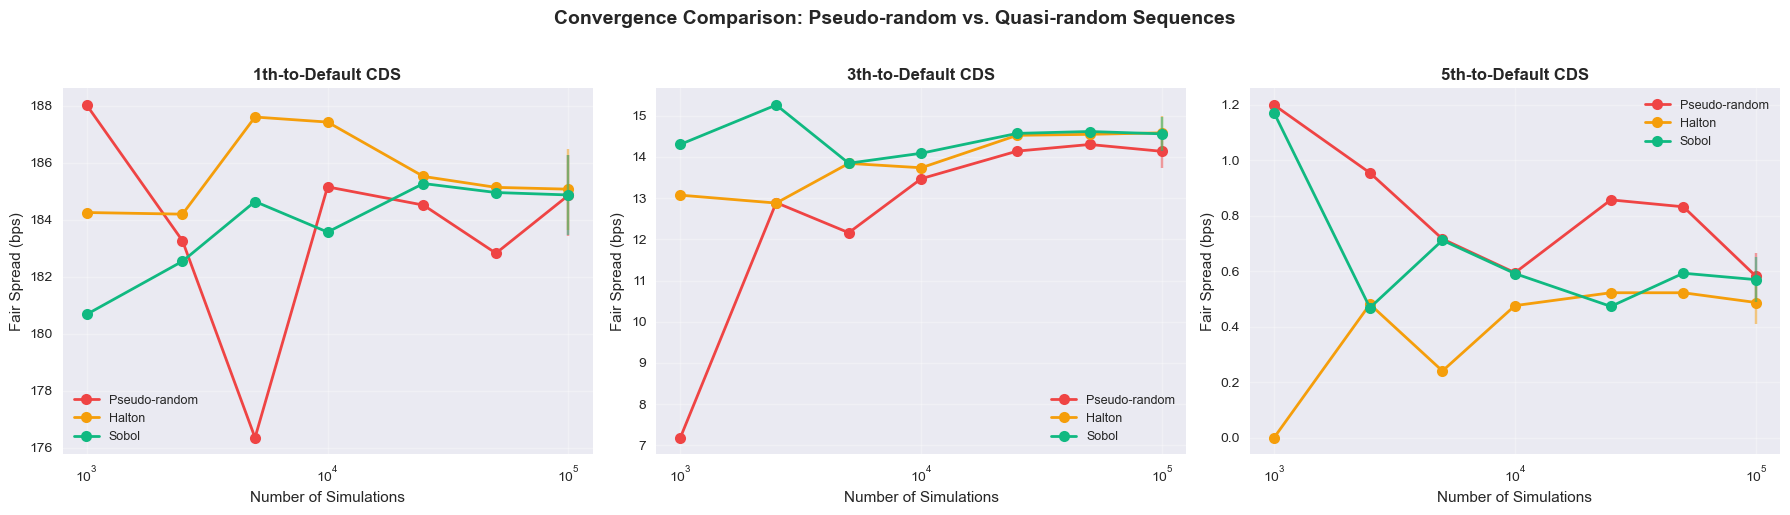

Plot saved as 'performance_summary.png'


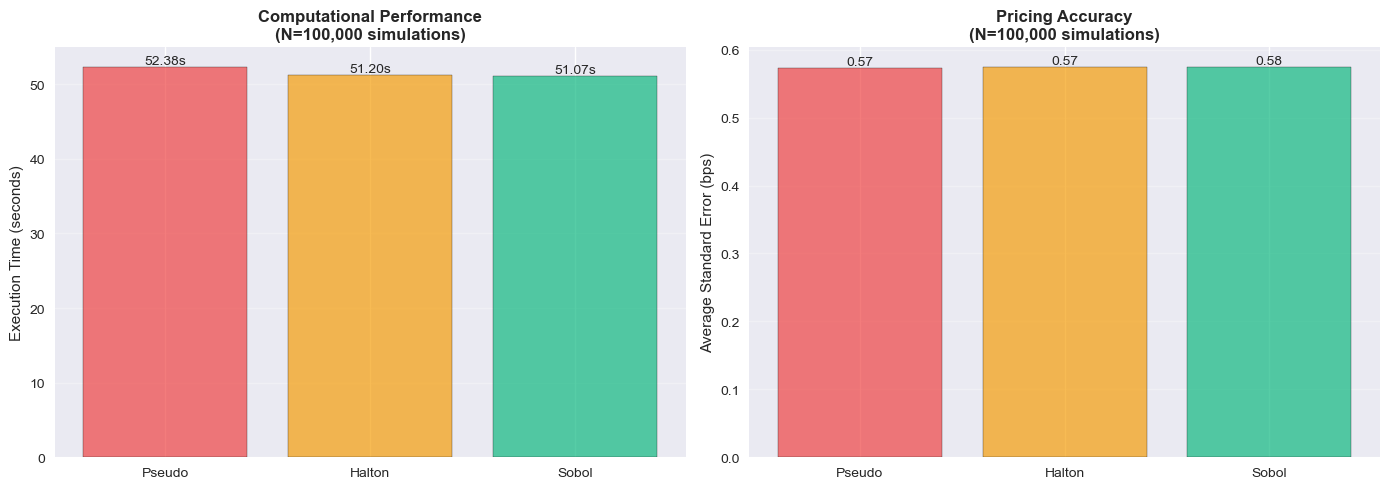


DETAILED COMPARISON AT N=100,000 SIMULATIONS


1th-to-Default CDS:
--------------------------------------------------------------------------------
Method          Fair Spread     Std Error       Time (s)    
--------------------------------------------------------------------------------
Pseudo            184.86 bps    ±  1.42 bps        52.38
Halton            185.08 bps    ±  1.42 bps        51.20
Sobol             184.87 bps    ±  1.42 bps        51.07
--------------------------------------------------------------------------------

2th-to-Default CDS:
--------------------------------------------------------------------------------
Method          Fair Spread     Std Error       Time (s)    
--------------------------------------------------------------------------------
Pseudo             49.01 bps    ±  0.75 bps        52.38
Halton             48.65 bps    ±  0.75 bps        51.20
Sobol              48.97 bps    ±  0.75 bps        51.07
------------------------------------------

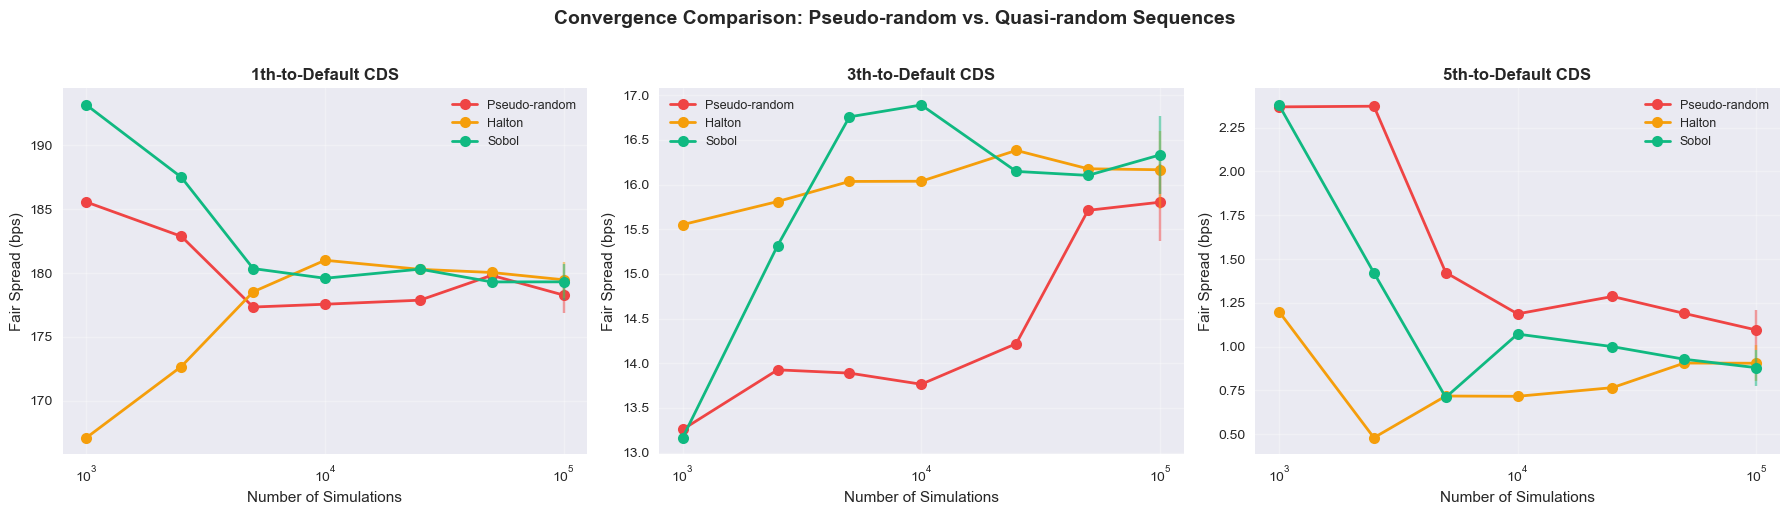

Plot saved as 'performance_summary.png'


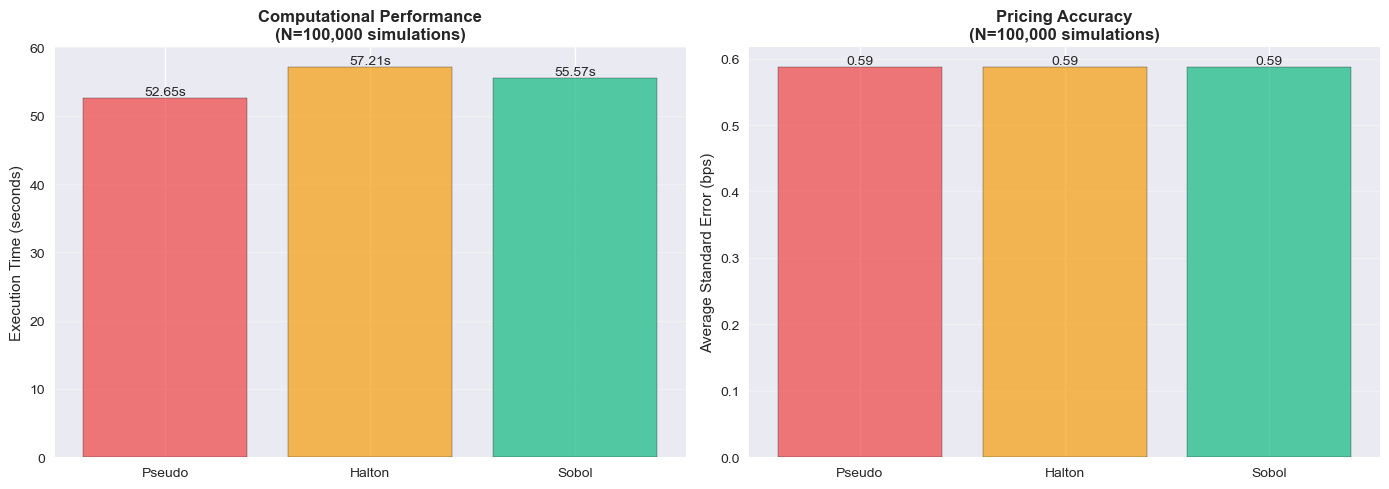


DETAILED COMPARISON AT N=100,000 SIMULATIONS


1th-to-Default CDS:
--------------------------------------------------------------------------------
Method          Fair Spread     Std Error       Time (s)    
--------------------------------------------------------------------------------
Pseudo            178.28 bps    ±  1.39 bps        52.65
Halton            179.47 bps    ±  1.40 bps        57.21
Sobol             179.31 bps    ±  1.40 bps        55.57
--------------------------------------------------------------------------------

2th-to-Default CDS:
--------------------------------------------------------------------------------
Method          Fair Spread     Std Error       Time (s)    
--------------------------------------------------------------------------------
Pseudo             49.92 bps    ±  0.76 bps        52.65
Halton             50.31 bps    ±  0.76 bps        57.21
Sobol              50.25 bps    ±  0.76 bps        55.57
------------------------------------------

In [42]:
def generate_halton_sequence(n_samples, n_dims, skip=1000):
    """
    Generate Halton low-discrepancy sequence
    """
    # Create Halton sampler
    halton = Halton(d=n_dims, scramble=True, seed=42)
    
    # Skip first 'skip' samples (optional, improves distribution)
    if skip > 0:
        _ = halton.random(skip)
    
    # Generate samples
    samples = halton.random(n_samples)
    
    return samples

class BasketCDSPricerComparison(BasketCDSPricer):
    """
    Extended pricer with support for Pseudo-random, Halton, and Sobol sequences
    """
    
    def generate_correlated_uniforms_gaussian(self, correlation_matrix, n_simulations, 
                                               sequence_type='pseudo', seed=42):
        """
        Generate correlated uniform random variables using Gaussian copula
        """
        np.random.seed(seed)
        
        # Cholesky decomposition
        try:
            L = np.linalg.cholesky(correlation_matrix)
        except np.linalg.LinAlgError:
            correlation_matrix = self._nearest_positive_definite(correlation_matrix)
            L = np.linalg.cholesky(correlation_matrix)
        
        # Generate base uniform samples based on sequence type
        if sequence_type.lower() == 'pseudo':
            # Standard pseudo-random
            uniform_base = np.random.uniform(0, 1, (n_simulations, self.n_names))
            standard_normals = norm.ppf(uniform_base)
            method_name = "Pseudo-random (Chi-square RNG)"
            
        elif sequence_type.lower() == 'halton':
            # Halton sequence
            uniform_base = generate_halton_sequence(n_simulations, self.n_names)
            standard_normals = norm.ppf(uniform_base)
            method_name = "Halton sequence"
            
        elif sequence_type.lower() == 'sobol':
            # Sobol sequence
            sobol = qmc.Sobol(d=self.n_names, scramble=True, seed=seed)
            uniform_base = sobol.random(n_simulations)
            standard_normals = norm.ppf(uniform_base)
            method_name = "Sobol sequence"
            
        else:
            raise ValueError(f"Unknown sequence_type: {sequence_type}")
        
        print(f"  Using {method_name} for uniform generation")
        
        # Apply correlation structure
        correlated_normals = standard_normals @ L.T
        
        # Transform to uniform
        uniform_samples = norm.cdf(correlated_normals)
        
        return uniform_samples
    
    def generate_correlated_uniforms_t(self, correlation_matrix, df, n_simulations,
                                       sequence_type='pseudo', seed=42):
        """
        Generate correlated uniform random variables using t-copula
        """
        np.random.seed(seed)
        
        # Cholesky decomposition
        try:
            L = np.linalg.cholesky(correlation_matrix)
        except np.linalg.LinAlgError:
            correlation_matrix = self._nearest_positive_definite(correlation_matrix)
            L = np.linalg.cholesky(correlation_matrix)
        
        # Generate base samples based on sequence type
        if sequence_type.lower() == 'pseudo':
            # Standard pseudo-random
            uniform_base = np.random.uniform(0, 1, (n_simulations, self.n_names + 1))
            standard_normals = norm.ppf(uniform_base[:, :self.n_names])
            chi2_samples = chi2.ppf(uniform_base[:, self.n_names], df)
            method_name = "Pseudo-random (Chi-square RNG)"
            
        elif sequence_type.lower() == 'halton':
            # Halton sequence (need n_names + 1 dimensions)
            uniform_base = generate_halton_sequence(n_simulations, self.n_names + 1)
            standard_normals = norm.ppf(uniform_base[:, :self.n_names])
            chi2_samples = chi2.ppf(uniform_base[:, self.n_names], df)
            method_name = "Halton sequence"
            
        elif sequence_type.lower() == 'sobol':
            # Sobol sequence
            sobol = qmc.Sobol(d=self.n_names + 1, scramble=True, seed=seed)
            uniform_base = sobol.random(n_simulations)
            standard_normals = norm.ppf(uniform_base[:, :self.n_names])
            chi2_samples = chi2.ppf(uniform_base[:, self.n_names], df)
            method_name = "Sobol sequence"
            
        else:
            raise ValueError(f"Unknown sequence_type: {sequence_type}")
        
        # Handle edge cases
        chi2_samples = np.clip(chi2_samples, 1e-10, 1e10)
        
        print(f"  Using {method_name} for uniform generation")
        
        # Apply correlation structure
        correlated_normals = standard_normals @ L.T
        
        # Transform to t-distributed
        correlated_t = correlated_normals / np.sqrt(chi2_samples / df)[:, np.newaxis]
        
        # Transform to uniform
        uniform_samples = t_dist.cdf(correlated_t, df=df)
        
        return uniform_samples
    
    def run_simulation(self, correlation_matrix, n_simulations=10000, 
                      copula_type='gaussian', t_df=None, sequence_type='pseudo',
                      maturity=5.0, seed=42):
        """
        Run complete Monte Carlo simulation with specified sequence type
        """
        print(f"\n{'='*60}")
        print(f"Running {copula_type.upper()} Copula Simulation")
        print(f"Sequence Type: {sequence_type.upper()}")
        print(f"{'='*60}")
        print(f"Number of simulations: {n_simulations:,}")
        print(f"Reference names: {self.n_names}")
        print(f"Maturity: {maturity} years")
        print(f"Recovery rate: {self.recovery_rate*100:.1f}%")
        print(f"{'='*60}\n")
        
        # Start timing
        start_time = time.time()
        
        # Generate correlated uniforms
        print("Generating correlated uniform variables...")
        if copula_type.lower() == 'gaussian':
            uniform_samples = self.generate_correlated_uniforms_gaussian(
                correlation_matrix, n_simulations, sequence_type, seed
            )
        elif copula_type.lower() == 't':
            if t_df is None:
                raise ValueError("Degrees of freedom must be specified for t-copula")
            uniform_samples = self.generate_correlated_uniforms_t(
                correlation_matrix, t_df, n_simulations, sequence_type, seed
            )
        else:
            raise ValueError("copula_type must be 'gaussian' or 't'")
        
        # Convert to default times
        print("\nConverting uniforms to default times...")
        default_times = self.uniform_to_default_time(uniform_samples)
        
        # Calculate premium and default legs
        print("\nCalculating premium and default legs...")
        basket_results = self.calculate_basket_cds_legs(default_times, maturity)
        
        # Calculate fair spreads
        print("\nCalculating fair spreads...")
        spreads = self.calculate_fair_spreads(basket_results)
        
        # End timing
        elapsed_time = time.time() - start_time
        
        # Print results
        print(f"\n{'='*60}")
        print("FAIR SPREADS (basis points)")
        print(f"{'='*60}")
        for k in range(1, self.n_names + 1):
            key = f'{k}th_to_default'
            spread = spreads[key]['fair_spread_bps']
            std_err = spreads[key]['std_default_leg'] / spreads[key]['avg_premium_leg'] * 10000 / np.sqrt(n_simulations)
            print(f"{k}th-to-default: {spread:8.2f} ± {std_err:5.2f} bps")
        print(f"{'='*60}")
        print(f"Elapsed time: {elapsed_time:.2f} seconds")
        print(f"{'='*60}\n")
        
        return {
            'uniform_samples': uniform_samples,
            'default_times': default_times,
            'basket_results': basket_results,
            'spreads': spreads,
            'correlation_matrix': correlation_matrix,
            'copula_type': copula_type,
            't_df': t_df if copula_type == 't' else None,
            'n_simulations': n_simulations,
            'sequence_type': sequence_type,
            'elapsed_time': elapsed_time
        }

def run_convergence_analysis(pricer, correlation_matrix, copula_type='gaussian', 
                            t_df=None, sim_counts=None, seed=42):
    """
    Run convergence analysis comparing all three methods
    """
    if sim_counts is None:
        sim_counts = [1000, 2500, 5000, 10000, 25000, 50000, 100000]
    
    results = {
        'pseudo': [],
        'halton': [],
        'sobol': []
    }
    
    sequence_types = ['pseudo', 'halton', 'sobol']
    
    for seq_type in sequence_types:
        print(f"\n{'#'*60}")
        print(f"CONVERGENCE ANALYSIS: {seq_type.upper()}")
        print(f"{'#'*60}")
        
        for n_sim in sim_counts:
            print(f"\nSimulations: {n_sim:,}")
            
            result = pricer.run_simulation(
                correlation_matrix=correlation_matrix,
                n_simulations=n_sim,
                copula_type=copula_type,
                t_df=t_df,
                sequence_type=seq_type,
                maturity=5.0,
                seed=seed
            )
            
            # Extract spreads
            spreads_dict = {
                'n_simulations': n_sim,
                'elapsed_time': result['elapsed_time'],
                'sequence_type': seq_type
            }
            
            for k in range(1, 6):
                key = f'{k}th_to_default'
                spreads_dict[f'spread_{k}'] = result['spreads'][key]['fair_spread_bps']
                spreads_dict[f'std_err_{k}'] = (
                    result['spreads'][key]['std_default_leg'] / 
                    result['spreads'][key]['avg_premium_leg'] * 
                    10000 / np.sqrt(n_sim)
                )
            
            results[seq_type].append(spreads_dict)
    
    # Convert to DataFrames
    df_results = {}
    for seq_type in sequence_types:
        df_results[seq_type] = pd.DataFrame(results[seq_type])
    
    return df_results

def plot_convergence_comparison(df_results, k_values=[1, 3, 5]):
    """
    Plot convergence comparison for selected k-th to default instruments
    """
    n_plots = len(k_values)
    fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))
    
    if n_plots == 1:
        axes = [axes]
    
    colors = {'pseudo': '#ef4444', 'halton': '#f59e0b', 'sobol': '#10b981'}
    labels = {'pseudo': 'Pseudo-random', 'halton': 'Halton', 'sobol': 'Sobol'}
    
    for idx, k in enumerate(k_values):
        ax = axes[idx]
        
        for seq_type in ['pseudo', 'halton', 'sobol']:
            df = df_results[seq_type]
            spread_col = f'spread_{k}'
            
            ax.plot(df['n_simulations'], df[spread_col], 
                   marker='o', linewidth=2, markersize=8,
                   color=colors[seq_type], label=labels[seq_type])
            
            # Add error bars for last point
            last_idx = len(df) - 1
            ax.errorbar(df.loc[last_idx, 'n_simulations'], 
                       df.loc[last_idx, spread_col],
                       yerr=df.loc[last_idx, f'std_err_{k}'],
                       fmt='none', ecolor=colors[seq_type], 
                       capsize=5, alpha=0.5)
        
        ax.set_xscale('log')
        ax.set_xlabel('Number of Simulations', fontsize=11)
        ax.set_ylabel('Fair Spread (bps)', fontsize=11)
        ax.set_title(f'{k}th-to-Default CDS', fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Convergence Comparison: Pseudo-random vs. Quasi-random Sequences', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('convergence_comparison.png', dpi=300, bbox_inches='tight')
    print("\nPlot saved as 'convergence_comparison.png'")
    plt.show()

def plot_performance_summary(df_results):
    """
    Plot performance summary comparing execution time and accuracy
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Extract data for N=100,000 simulations
    summary_data = []
    for seq_type in ['pseudo', 'halton', 'sobol']:
        df = df_results[seq_type]
        row = df[df['n_simulations'] == 100000].iloc[0]
        
        # Calculate average standard error across all k
        avg_std_err = np.mean([row[f'std_err_{k}'] for k in range(1, 6)])
        
        summary_data.append({
            'Method': seq_type.capitalize(),
            'Time (s)': row['elapsed_time'],
            'Avg Std Error (bps)': avg_std_err
        })
    
    df_summary = pd.DataFrame(summary_data)
    
    # Plot 1: Execution Time
    ax1 = axes[0]
    bars1 = ax1.bar(df_summary['Method'], df_summary['Time (s)'],
                    color=['#ef4444', '#f59e0b', '#10b981'], alpha=0.7, edgecolor='black')
    ax1.set_ylabel('Execution Time (seconds)', fontsize=11)
    ax1.set_title('Computational Performance\n(N=100,000 simulations)', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}s', ha='center', va='bottom', fontsize=10)
    
    # Plot 2: Standard Error
    ax2 = axes[1]
    bars2 = ax2.bar(df_summary['Method'], df_summary['Avg Std Error (bps)'],
                    color=['#ef4444', '#f59e0b', '#10b981'], alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Average Standard Error (bps)', fontsize=11)
    ax2.set_title('Pricing Accuracy\n(N=100,000 simulations)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('performance_summary.png', dpi=300, bbox_inches='tight')
    print("Plot saved as 'performance_summary.png'")
    plt.show()

def create_comparison_table(df_results, n_sim=100000):
    """
    Create detailed comparison table
    """
    print(f"\n{'='*80}")
    print(f"DETAILED COMPARISON AT N={n_sim:,} SIMULATIONS")
    print(f"{'='*80}\n")
    
    for k in range(1, 6):
        print(f"\n{k}th-to-Default CDS:")
        print(f"{'-'*80}")
        print(f"{'Method':<15} {'Fair Spread':<15} {'Std Error':<15} {'Time (s)':<12}")
        print(f"{'-'*80}")
        
        for seq_type in ['pseudo', 'halton', 'sobol']:
            df = df_results[seq_type]
            row = df[df['n_simulations'] == n_sim].iloc[0]
            
            spread = row[f'spread_{k}']
            std_err = row[f'std_err_{k}']
            time_val = row['elapsed_time']
            
            print(f"{seq_type.capitalize():<15} {spread:>8.2f} bps    ±{std_err:>6.2f} bps     {time_val:>8.2f}")
        
        print(f"{'-'*80}")


if __name__ == "__main__":
    # Initialize the extended pricer
    pricer = BasketCDSPricerComparison(df_bootstrap, discount_factor, recovery_rate=0.4)
    
    # Run convergence analysis for Gaussian Copula
    print("\n" + "="*80)
    print("STARTING COMPREHENSIVE NUMERICAL METHODS COMPARISON")
    print("="*80)
    
    df_results_gaussian = run_convergence_analysis(
        pricer=pricer,
        correlation_matrix=results_calibration['pearson_correlation'],
        copula_type='gaussian',
        sim_counts=[1000, 2500, 5000, 10000, 25000, 50000, 100000],
        seed=42
    )
    
    # Create visualizations
    plot_convergence_comparison(df_results_gaussian, k_values=[1, 3, 5])
    plot_performance_summary(df_results_gaussian)
    
    # Create comparison table
    create_comparison_table(df_results_gaussian, n_sim=100000)
    
    # Optional: Run for t-Copula as well
    print("\n\n" + "="*80)
    print("REPEATING ANALYSIS FOR T-COPULA")
    print("="*80)
    
    df_results_t = run_convergence_analysis(
        pricer=pricer,
        correlation_matrix=results_calibration['spearman_correlation'],
        copula_type='t',
        t_df=results_calibration['t_copula_df'],
        sim_counts=[1000, 2500, 5000, 10000, 25000, 50000, 100000],
        seed=42
    )
    
    plot_convergence_comparison(df_results_t, k_values=[1, 3, 5])
    plot_performance_summary(df_results_t)
    create_comparison_table(df_results_t, n_sim=100000)

### Risk & Sensitivity Analysis


                              BASKET CDS SENSITIVITY ANALYSIS
✓ Converted Pearson correlation from DataFrame to numpy array
✓ Converted Spearman correlation from DataFrame to numpy array

                                   PART 1: GAUSSIAN COPULA

[1/6] Running Correlation Sensitivity - Gaussian Copula...

CORRELATION SENSITIVITY ANALYSIS - GAUSSIAN COPULA

Correlation shock: -50%

Running GAUSSIAN Copula Simulation
Sequence Type: SOBOL
Number of simulations: 100,000
Reference names: 5
Maturity: 5.0 years
Recovery rate: 40.0%

Generating correlated uniform variables...
  Using Sobol sequence for uniform generation

Converting uniforms to default times...

Calculating premium and default legs...

Calculating fair spreads...

FAIR SPREADS (basis points)
1th-to-default:   222.69 ±  1.54 bps
2th-to-default:    29.62 ±  0.59 bps
3th-to-default:     3.44 ±  0.20 bps
4th-to-default:     0.25 ±  0.05 bps
5th-to-default:     0.02 ±  0.02 bps
Elapsed time: 51.74 seconds


Correlation shock: -25

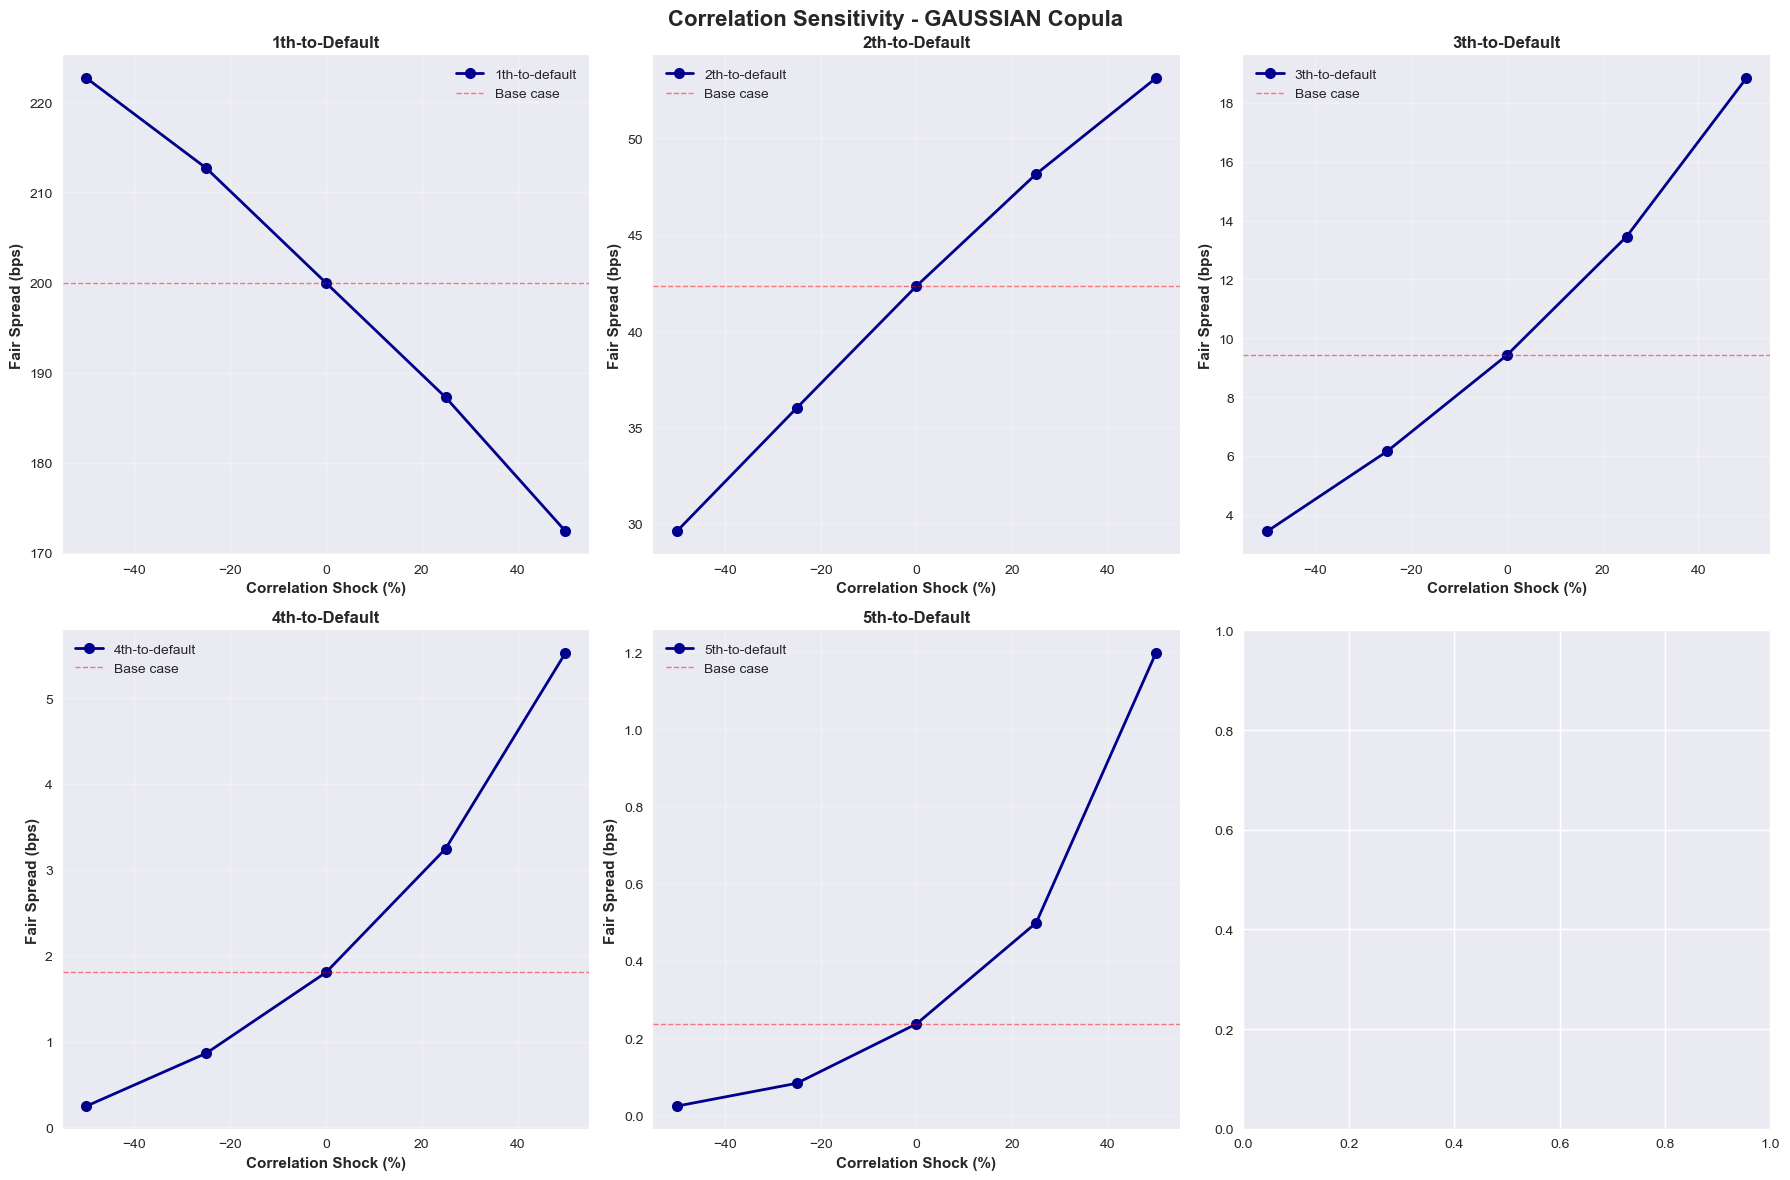

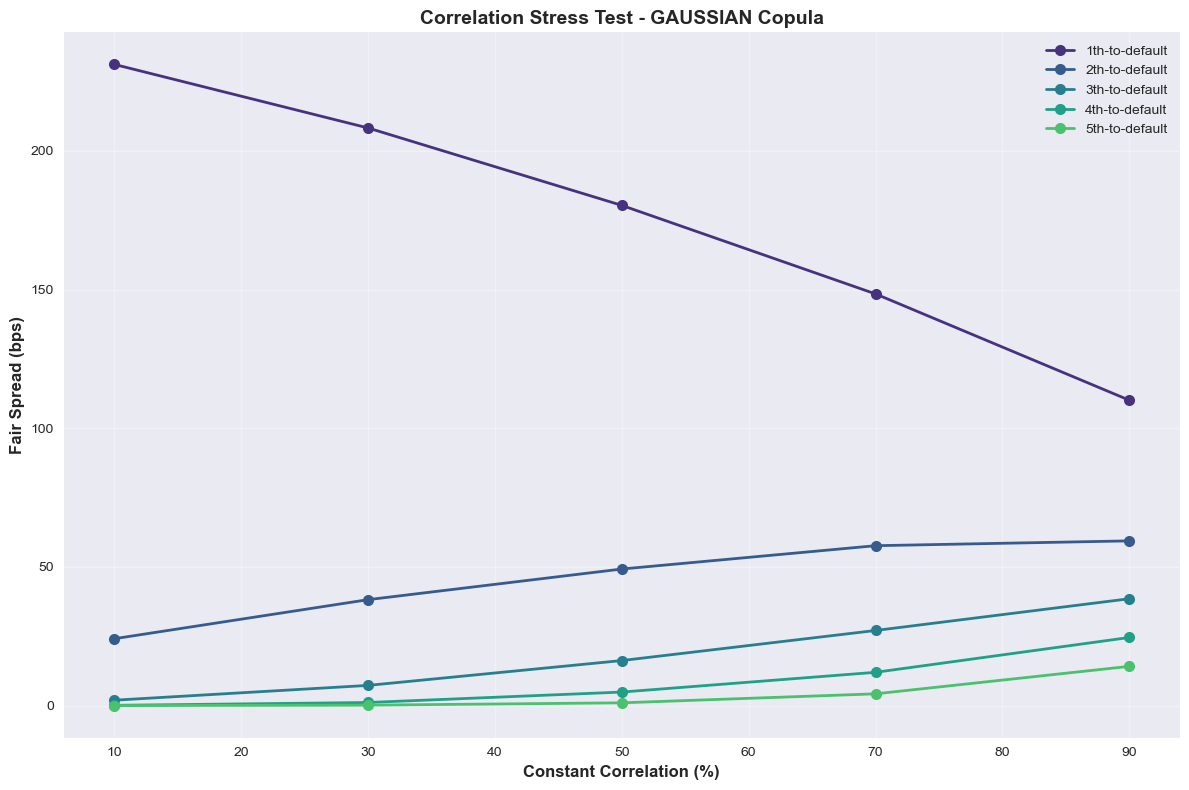

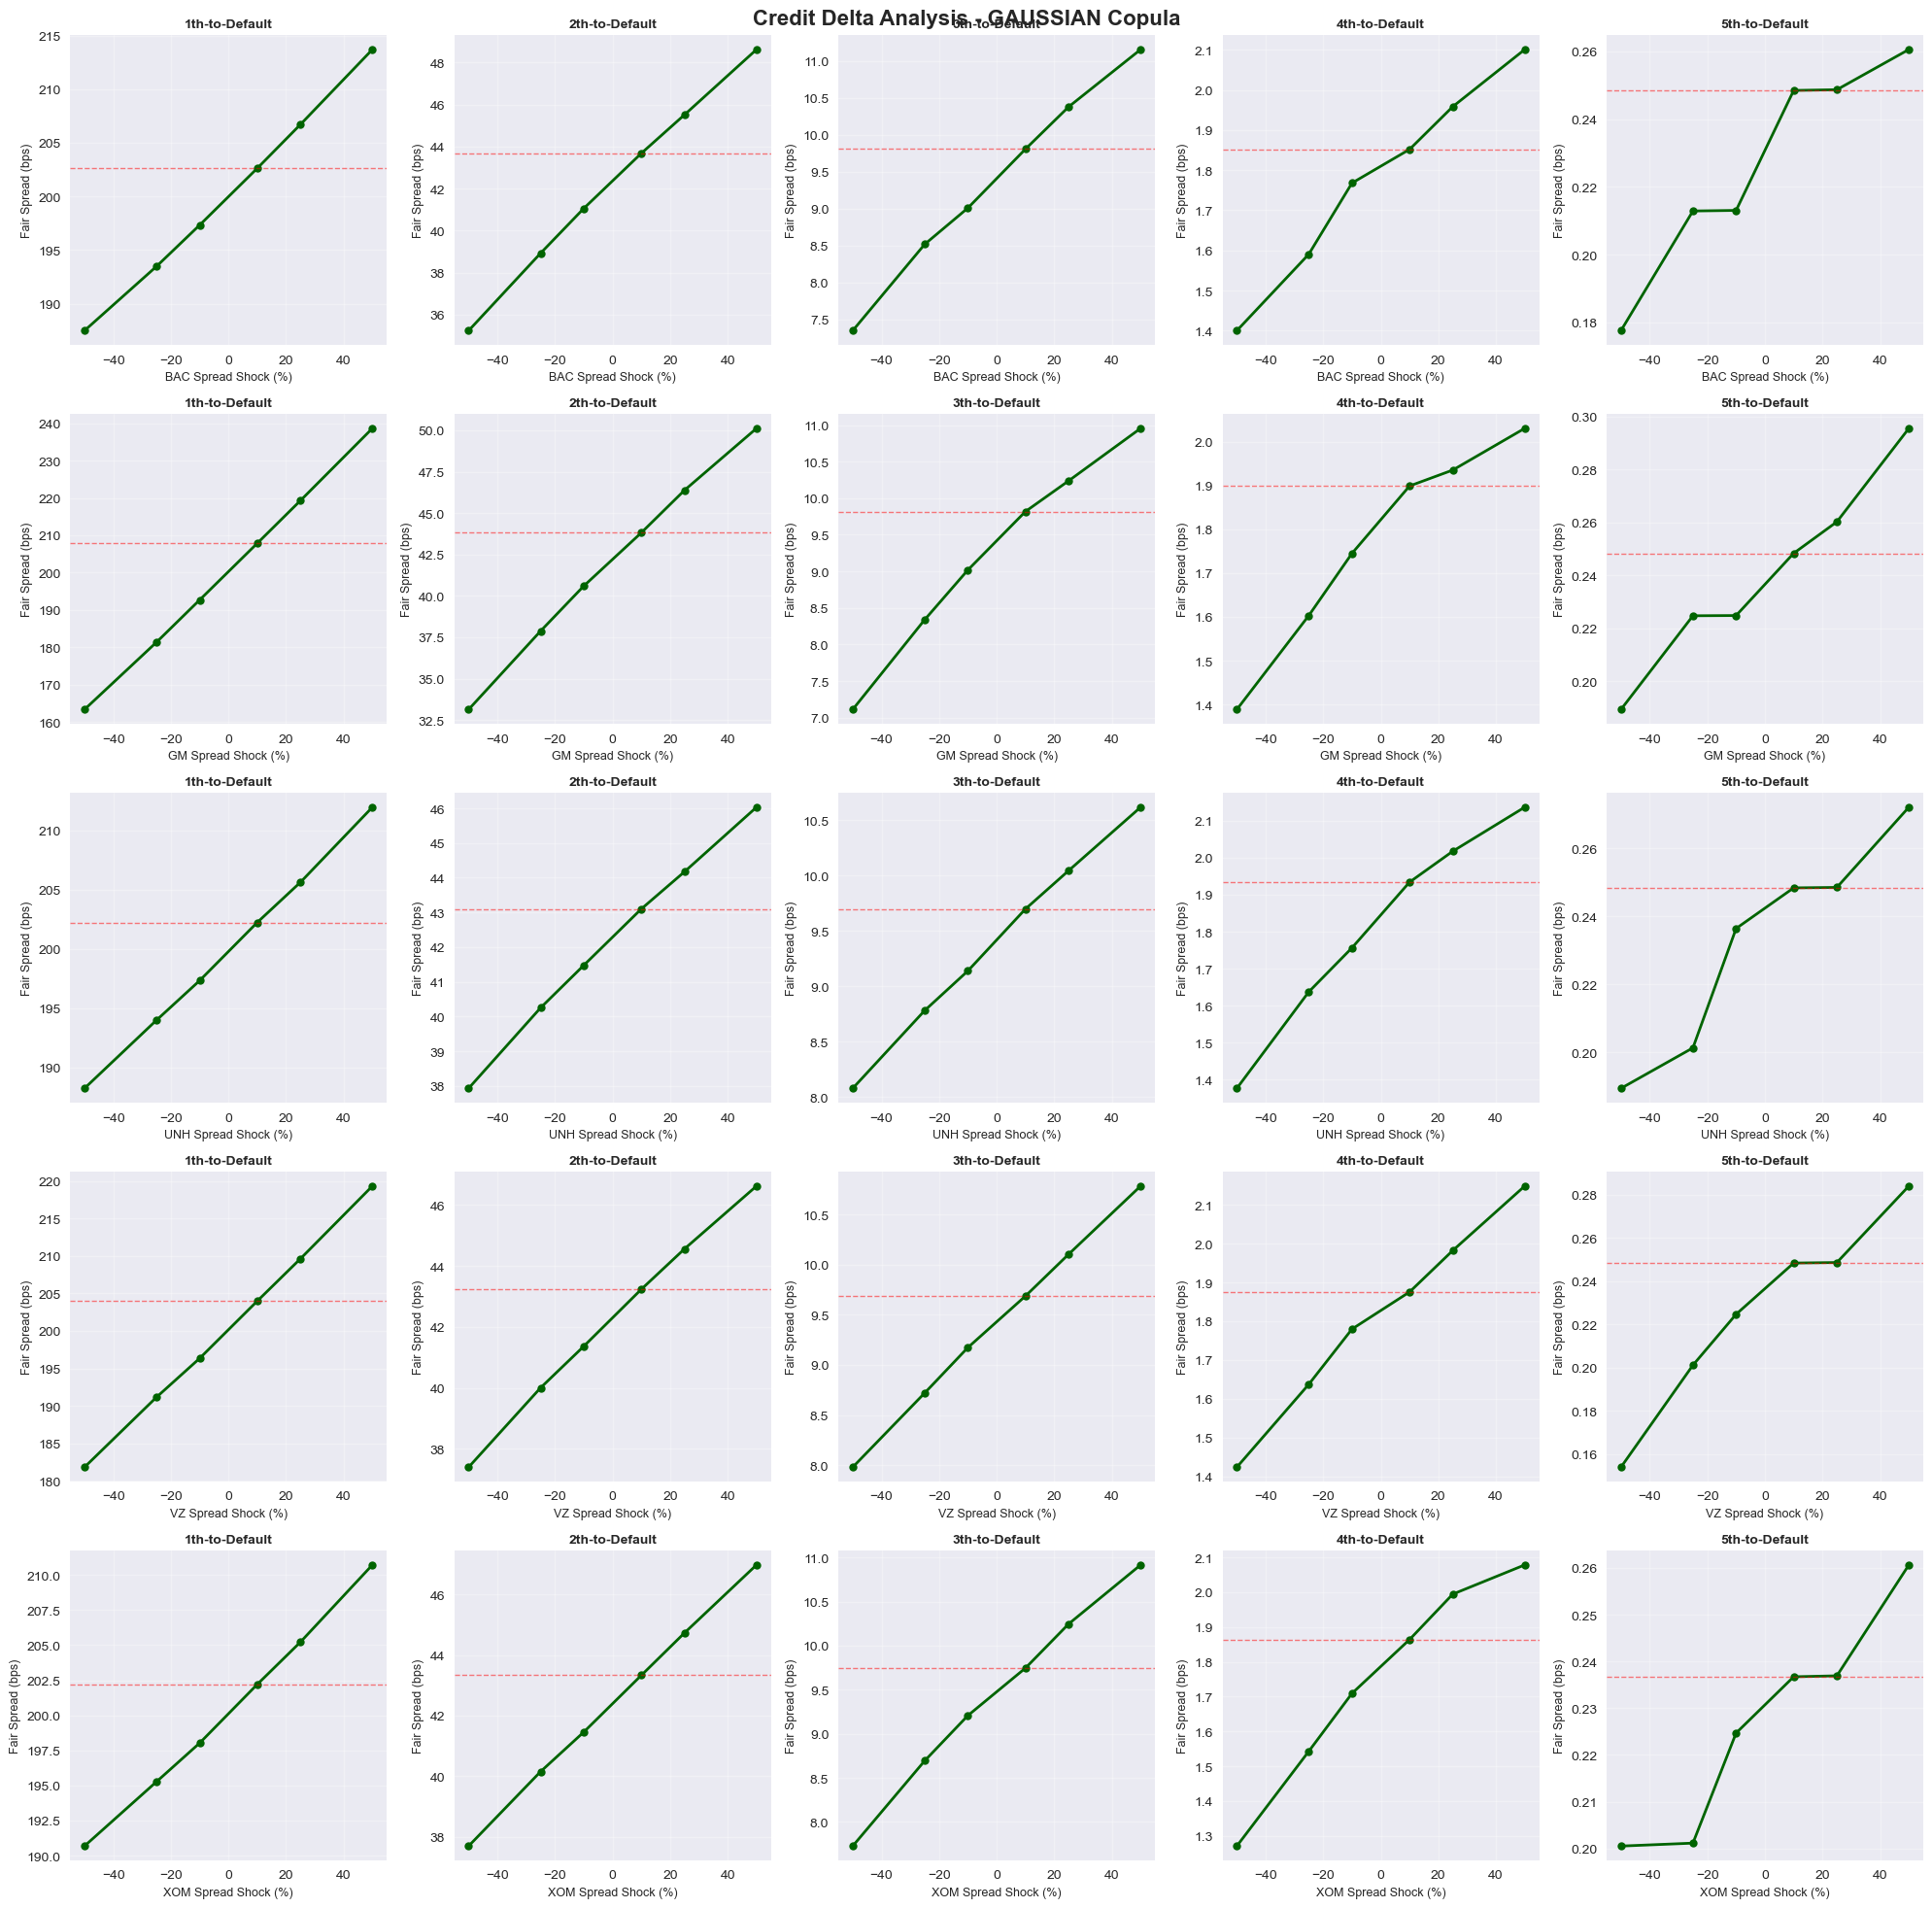

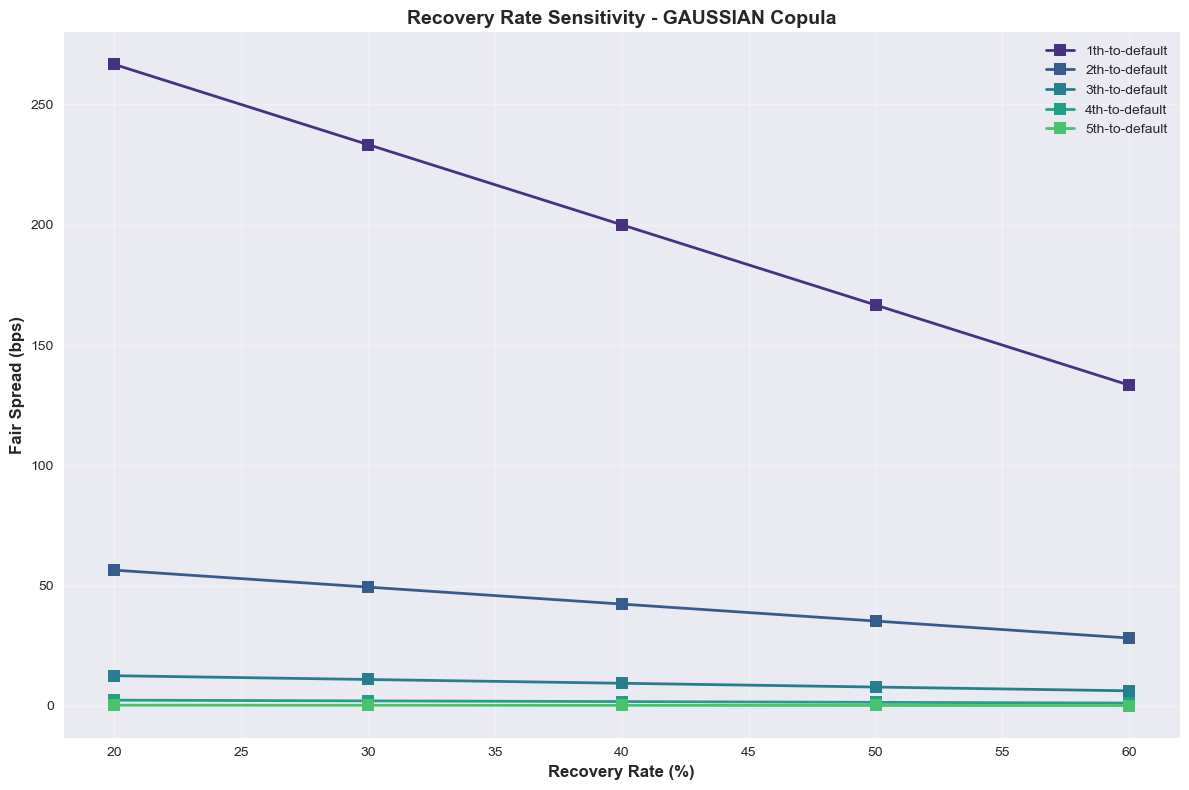


Generating plots for t-Copula...


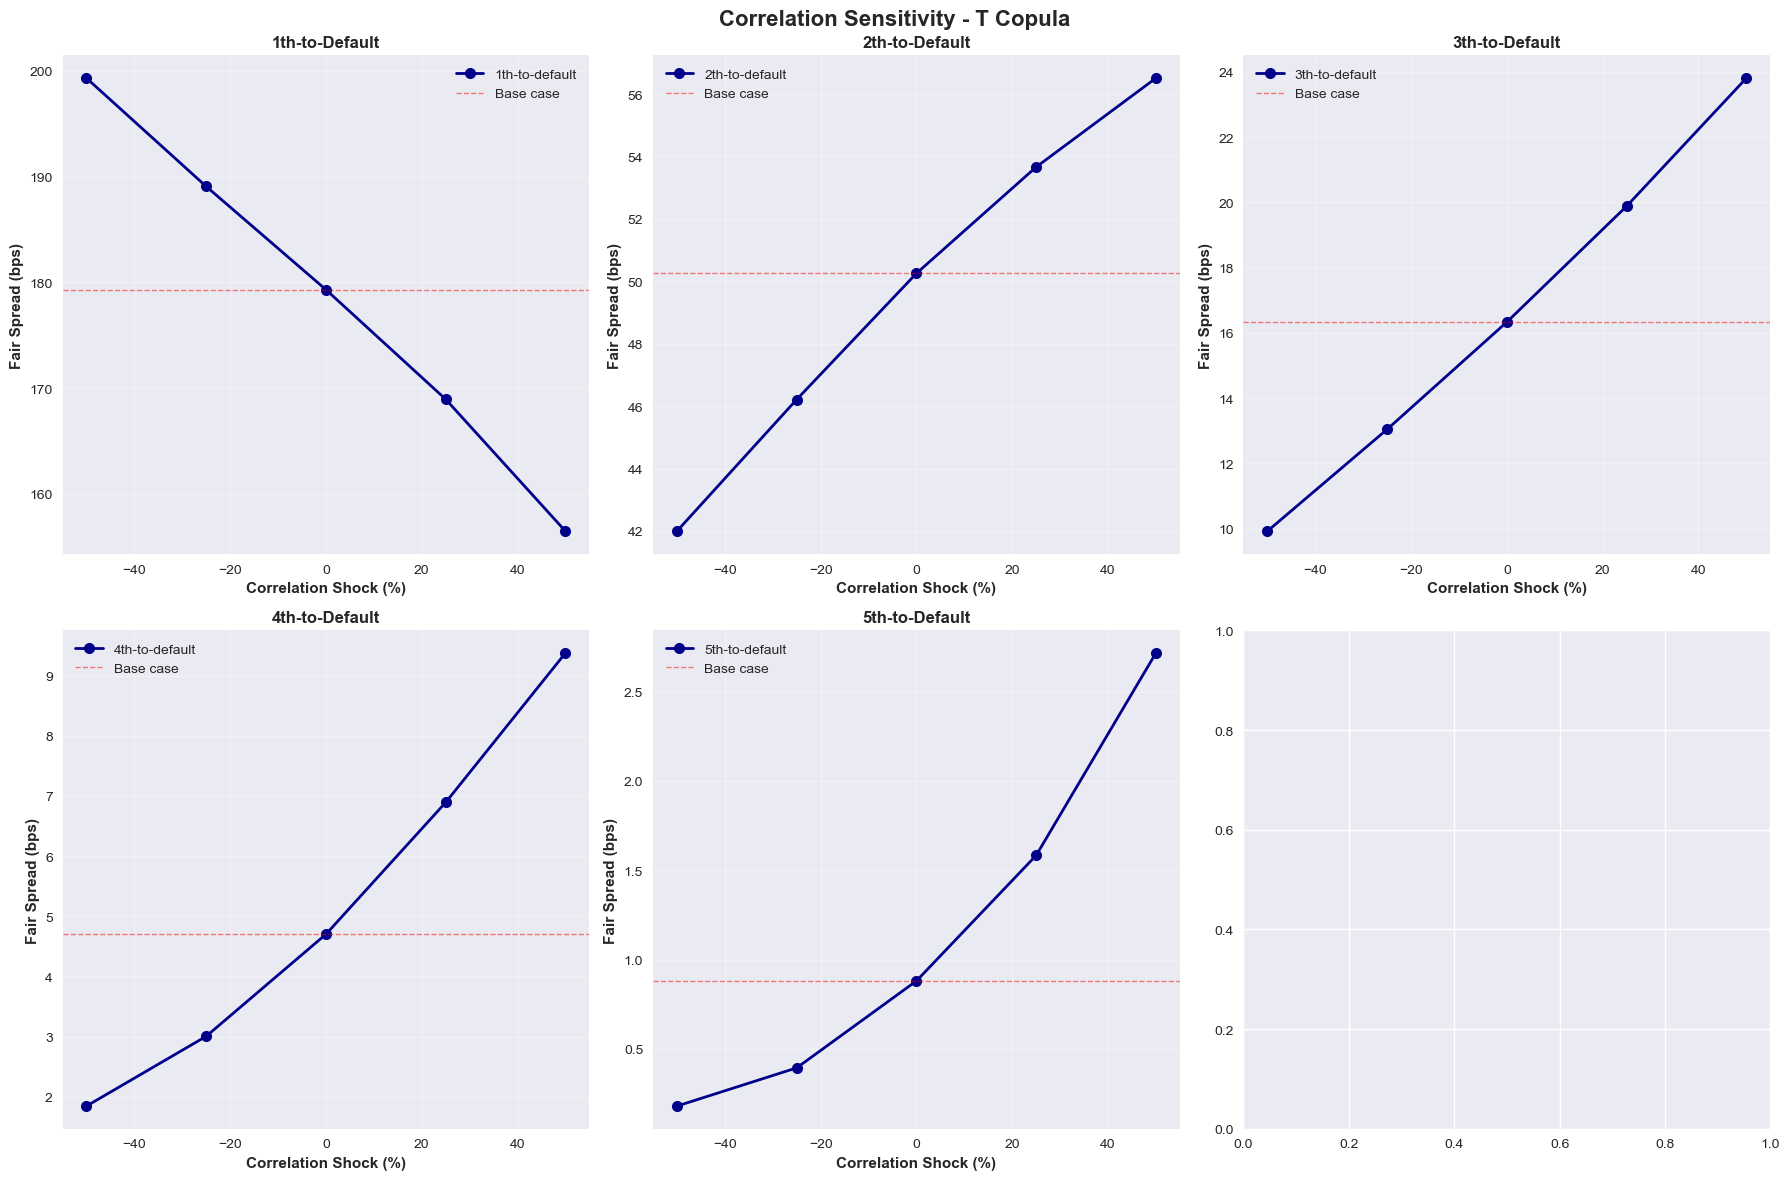

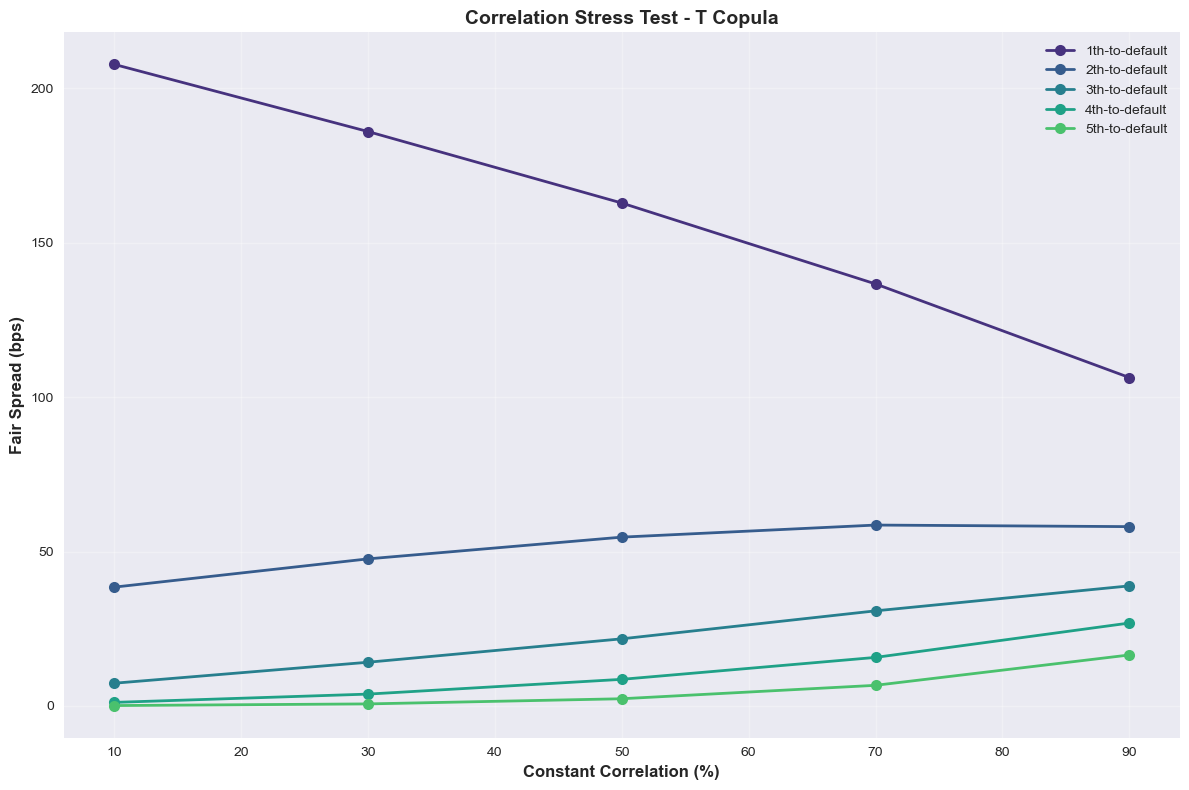

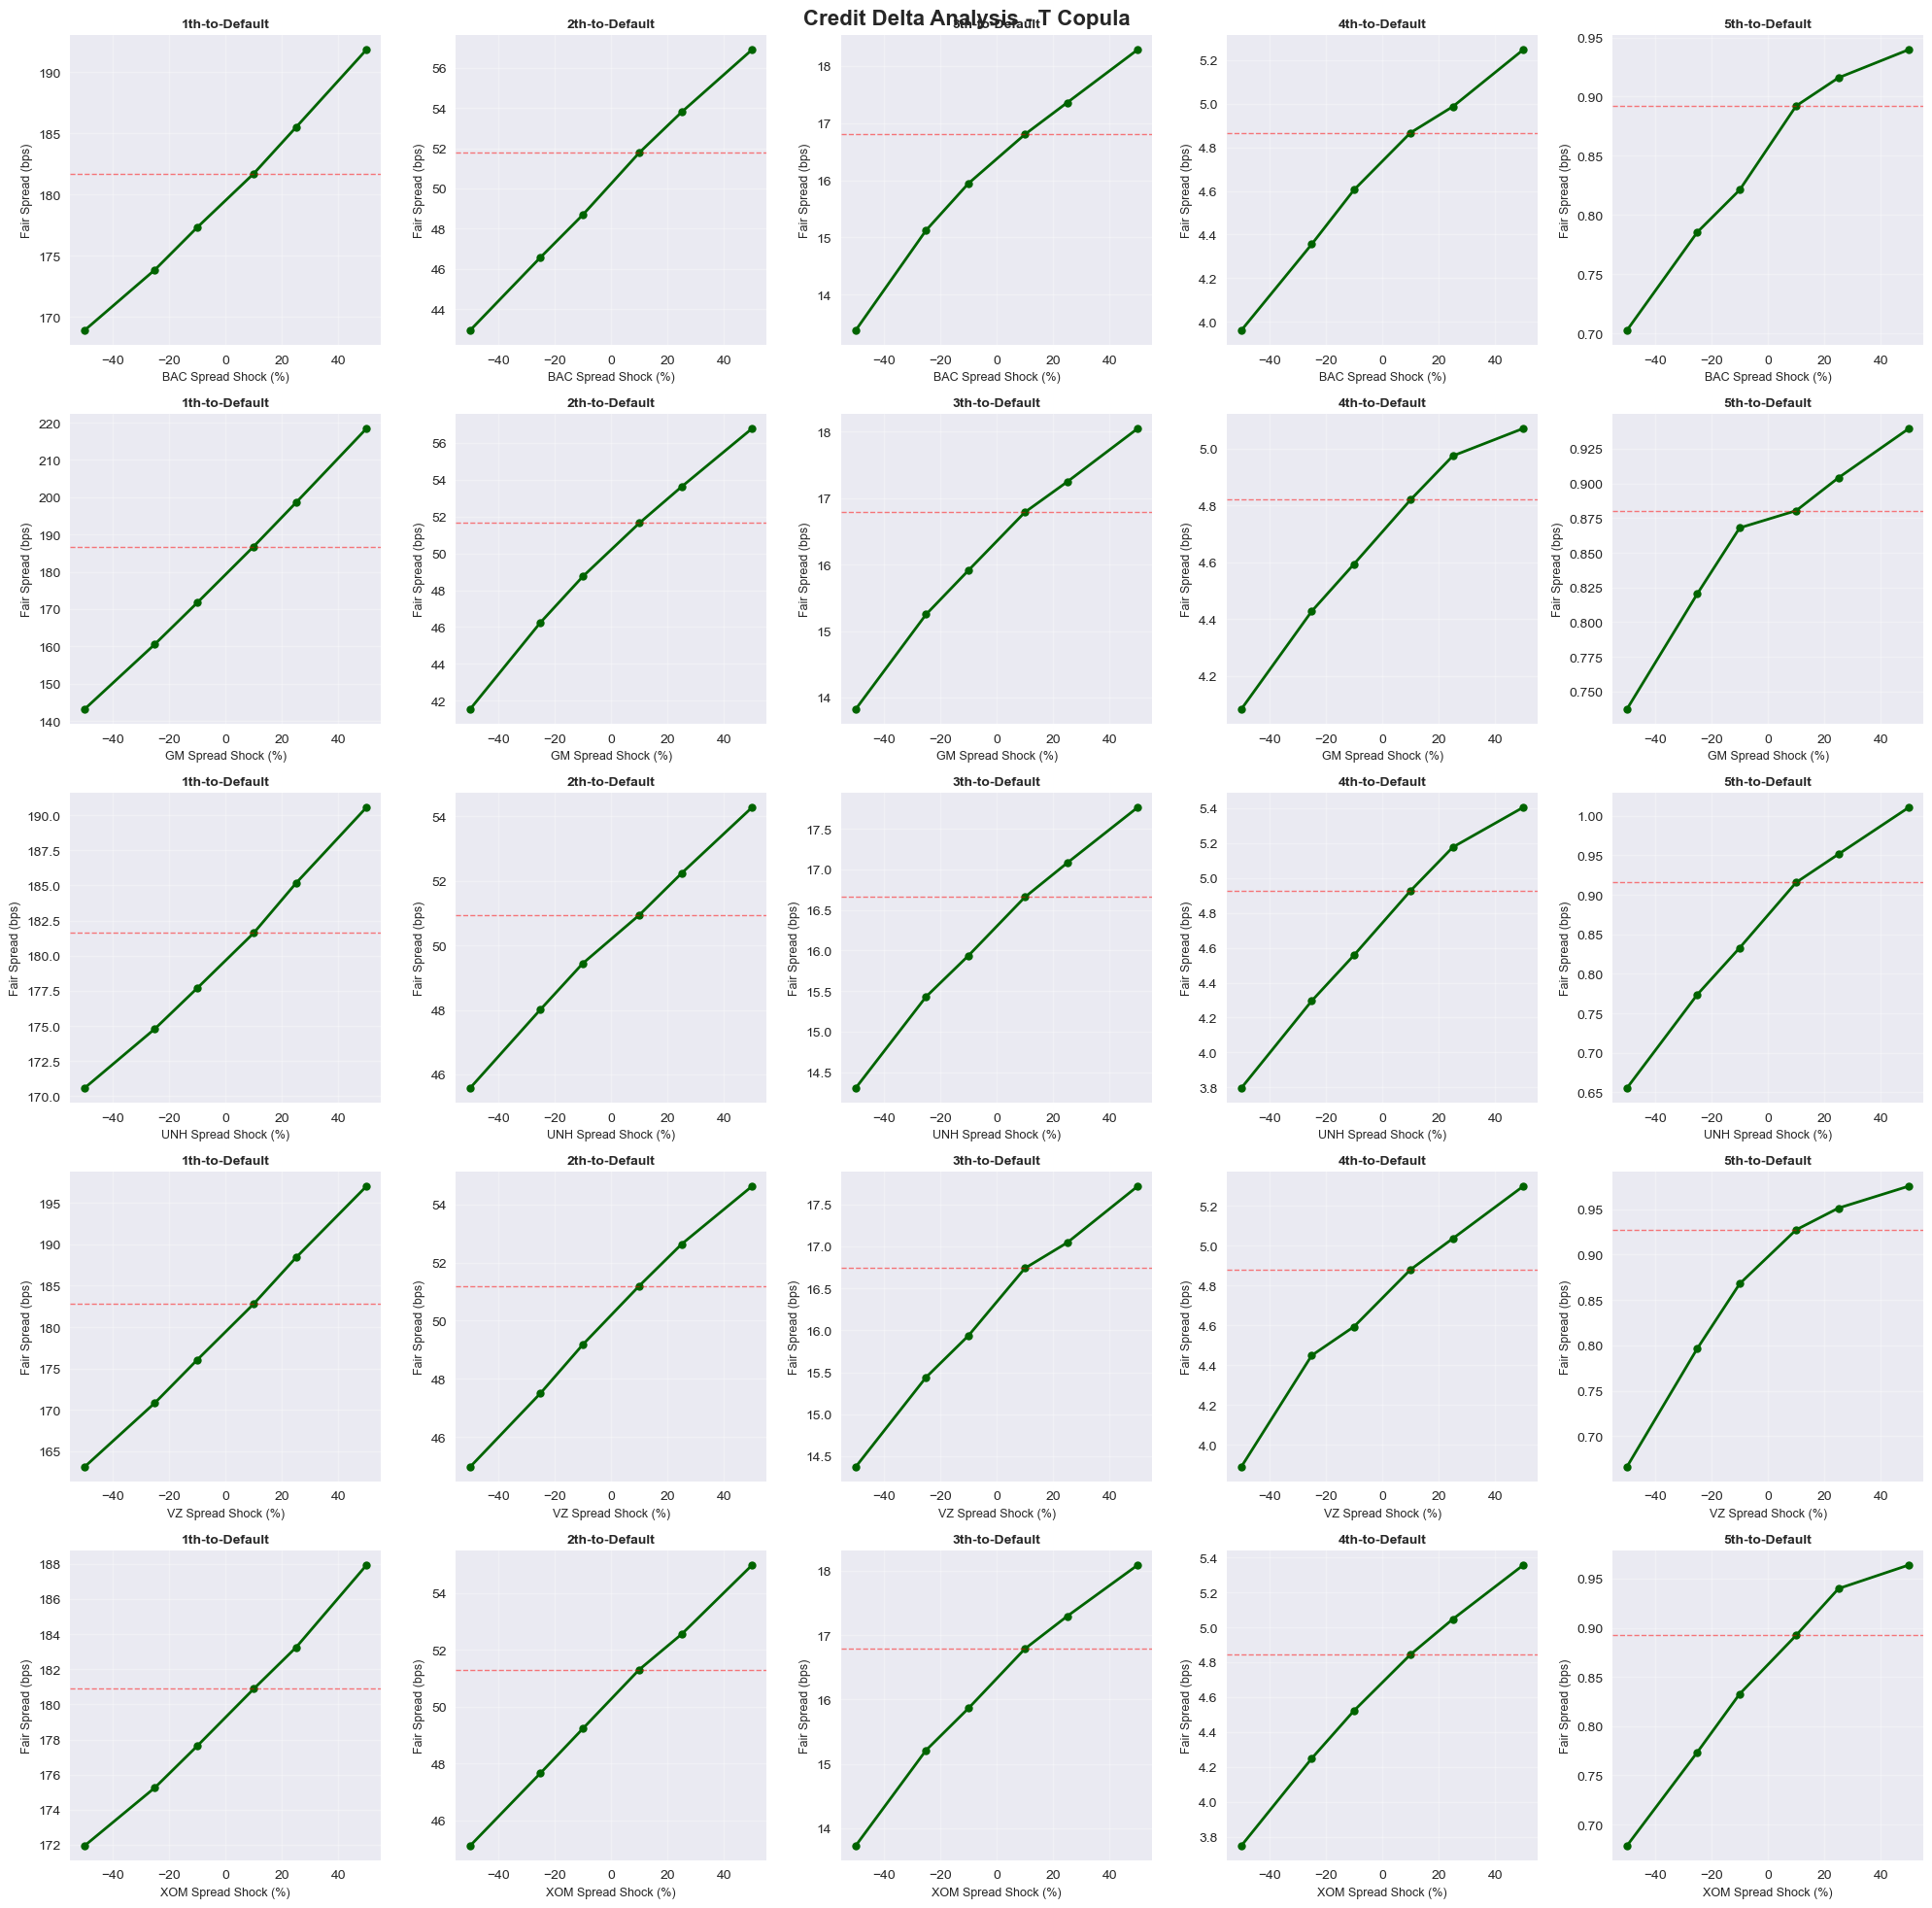

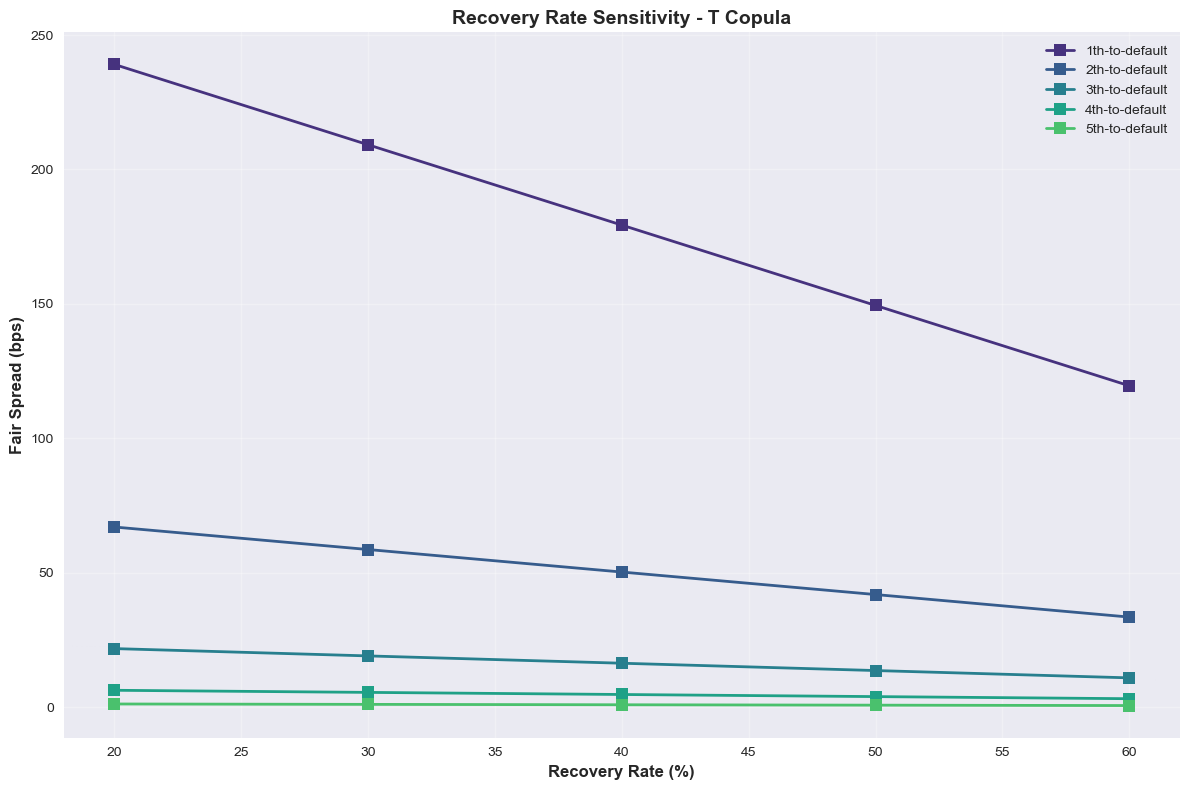


                              PART 4: COMPARATIVE ANALYSIS


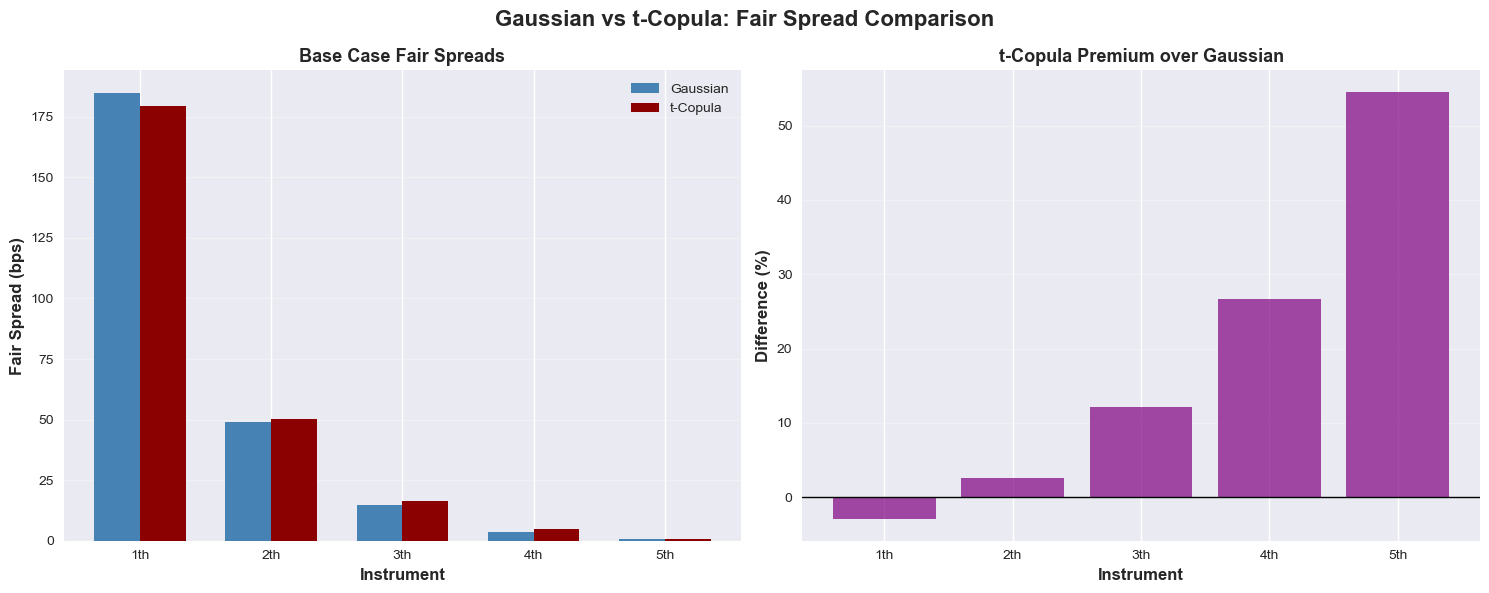

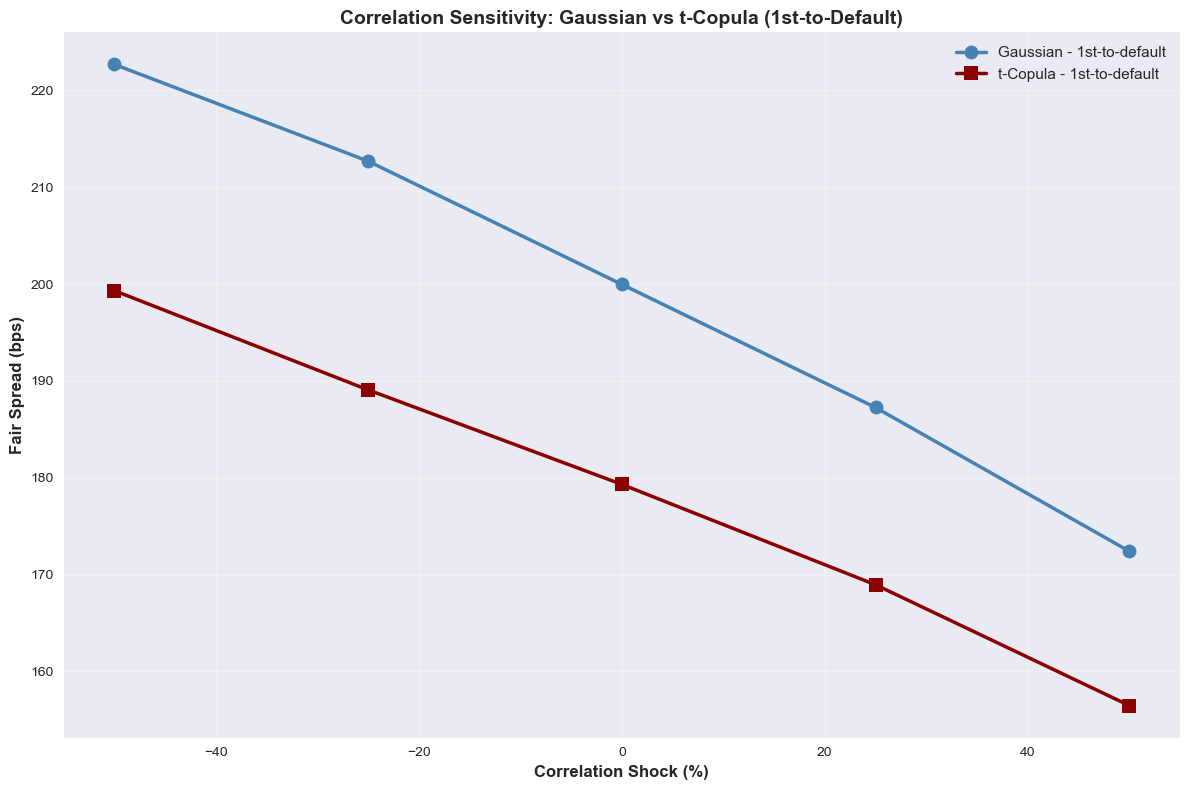

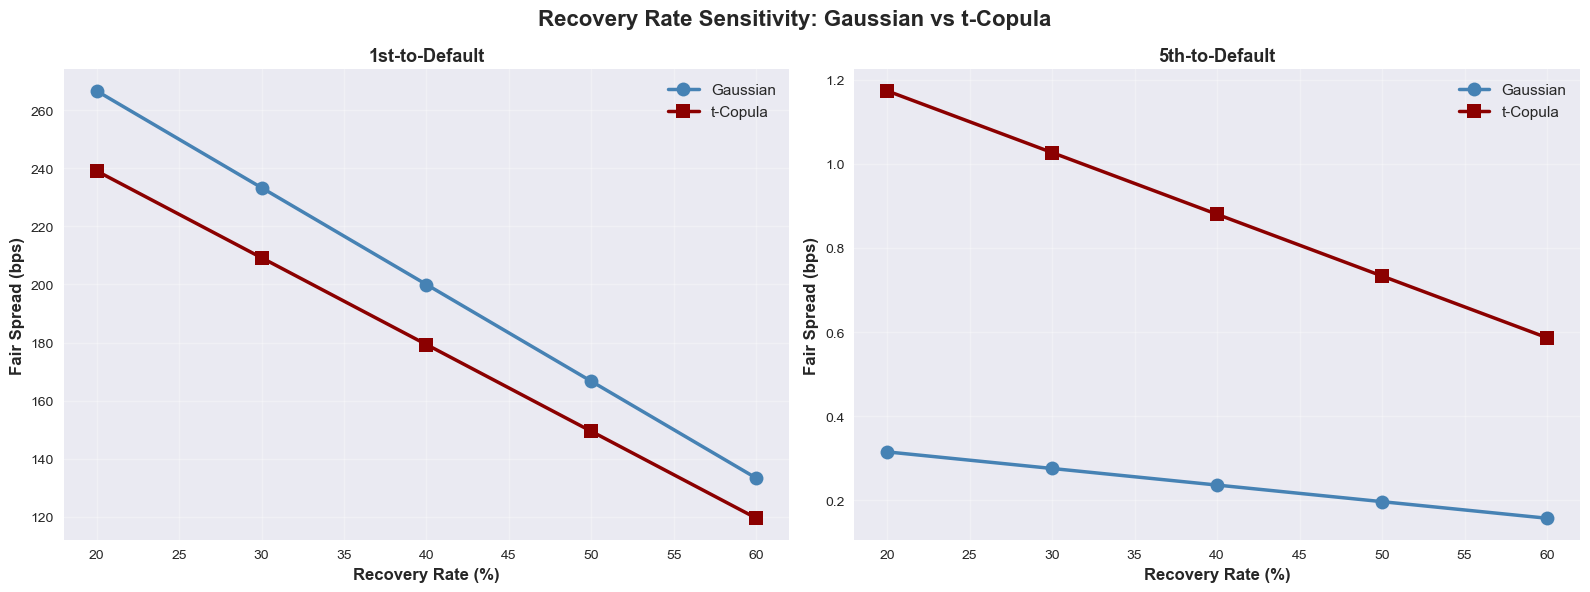


                                   PART 5: SUMMARY TABLES

Creating summary tables...

✓ Saved: sensitivity_summary_gaussian.csv
✓ Saved: sensitivity_summary_t.csv
✓ Saved: copula_comparison_summary.csv

                                   PART 6: FINAL SUMMARY

FINAL SUMMARY - BASKET CDS SENSITIVITY ANALYSIS

1. BASE CASE FAIR SPREADS:
--------------------------------------------------------------------------------
Instrument           Gaussian (bps)     t-Copula (bps)     Difference (bps)
--------------------------------------------------------------------------------
1th-to-default:<20           184.87            179.31             -5.56
2th-to-default:<20            48.97             50.25              1.28
3th-to-default:<20            14.56             16.33              1.77
4th-to-default:<20             3.71              4.70              0.99
5th-to-default:<20             0.57              0.88              0.31

2. KEY SENSITIVITY METRICS:
----------------------------------

In [43]:
class BasketCDSSensitivityAnalysis:
    """
    Comprehensive sensitivity analysis for Basket CDS pricing
    """
    
    def __init__(self, pricer, df_bootstrap, discount_factors, base_correlation_matrix, 
                 base_results_gaussian, base_results_t, t_df):
        """
        Initialize sensitivity analyzer
        """
        self.pricer = pricer
        self.df_bootstrap = df_bootstrap
        self.discount_factors = discount_factors
        if isinstance(base_correlation_matrix, pd.DataFrame):
            self.base_correlation = base_correlation_matrix.values  # Convert to numpy
        else:
            self.base_correlation = base_correlation_matrix
        self.base_gaussian = base_results_gaussian
        self.base_t = base_results_t
        self.t_df = t_df
        self.tickers = df_bootstrap['Ticker'].unique()
        self.n_names = len(self.tickers)
    
    def correlation_sensitivity(self, correlation_shocks, n_simulations=100000, 
                                copula_type='gaussian', sequence_type='sobol'):
        """
        Analyze sensitivity to correlation changes
        """
        print("\n" + "="*80)
        print(f"CORRELATION SENSITIVITY ANALYSIS - {copula_type.upper()} COPULA")
        print("="*80)
        
        results = {}
        
        for shock in correlation_shocks:
            print(f"\nCorrelation shock: {shock:+.0%}")
            
            # Create shocked correlation matrix
            shocked_corr = self._shock_correlation_matrix(self.base_correlation, shock)
            
            # Run simulation with shocked correlation
            sim_results = self.pricer.run_simulation(
                correlation_matrix=shocked_corr,
                n_simulations=n_simulations,
                copula_type=copula_type,
                t_df=self.t_df if copula_type == 't' else None,
                sequence_type=sequence_type,
                maturity=5.0,
                seed=42
            )
            
            results[shock] = sim_results['spreads']
        
        return results
    
    def correlation_stress_test(self, correlation_levels, n_simulations=100000,
                                copula_type='gaussian', sequence_type='sobol'):
        """
        Stress test with constant correlation levels
        """
        print("\n" + "="*80)
        print(f"CORRELATION STRESS TEST - {copula_type.upper()} COPULA")
        print("="*80)
        
        results = {}
        
        for corr_level in correlation_levels:
            print(f"\nConstant correlation: {corr_level:.1%}")
            
            # Create constant correlation matrix
            constant_corr = self._create_constant_correlation_matrix(corr_level)
            
            # Run simulation
            sim_results = self.pricer.run_simulation(
                correlation_matrix=constant_corr,
                n_simulations=n_simulations,
                copula_type=copula_type,
                t_df=self.t_df if copula_type == 't' else None,
                sequence_type=sequence_type,
                maturity=5.0,
                seed=42
            )
            
            results[corr_level] = sim_results['spreads']
        
        return results
    
    def _shock_correlation_matrix(self, corr_matrix, shock):
        """
        Apply proportional shock to correlation matrix
        Preserves positive definiteness
        """
        shocked = corr_matrix.copy()
        
        # Apply shock to off-diagonal elements
        for i in range(self.n_names):
            for j in range(i+1, self.n_names):
                new_corr = shocked[i, j] * (1 + shock)
                # Clip to valid correlation range
                new_corr = np.clip(new_corr, -0.99, 0.99)
                shocked[i, j] = new_corr
                shocked[j, i] = new_corr
        
        # Ensure positive definiteness
        shocked = self._nearest_positive_definite(shocked)
        
        return shocked
    
    def _create_constant_correlation_matrix(self, rho):
        """
        Create correlation matrix with constant off-diagonal correlation
        """
        corr_matrix = np.eye(self.n_names)
        corr_matrix[np.triu_indices(self.n_names, k=1)] = rho
        corr_matrix[np.tril_indices(self.n_names, k=-1)] = rho
        
        return self._nearest_positive_definite(corr_matrix)
    
    def credit_spread_sensitivity(self, spread_shocks, n_simulations=100000,
                                  copula_type='gaussian', sequence_type='sobol'):
        """
        Analyze sensitivity to individual name credit spread changes
        """
        print("\n" + "="*80)
        print(f"CREDIT SPREAD SENSITIVITY ANALYSIS - {copula_type.upper()} COPULA")
        print("="*80)
        
        results = {}
        
        for ticker in self.tickers:
            print(f"\n{'='*80}")
            print(f"Analyzing: {ticker}")
            print(f"{'='*80}")
            
            ticker_results = {}
            
            for shock in spread_shocks:
                print(f"\n  Spread shock: {shock:+.0%}")
                
                # Create shocked bootstrap dataframe
                shocked_bootstrap = self._shock_credit_spread(ticker, shock)
                
                # Create new pricer with shocked data
                shocked_pricer = BasketCDSPricerComparison(
                    shocked_bootstrap, 
                    self.discount_factors, 
                    recovery_rate=self.pricer.recovery_rate
                )
                
                # Run simulation
                sim_results = shocked_pricer.run_simulation(
                    correlation_matrix=self.base_correlation,
                    n_simulations=n_simulations,
                    copula_type=copula_type,
                    t_df=self.t_df if copula_type == 't' else None,
                    sequence_type=sequence_type,
                    maturity=5.0,
                    seed=42
                )
                
                ticker_results[shock] = sim_results['spreads']
            
            results[ticker] = ticker_results
        
        return results
    
    def parallel_spread_shift(self, shift_bps, n_simulations=100000,
                             copula_type='gaussian', sequence_type='sobol'):
        """
        Parallel shift of all credit spreads
        """
        print("\n" + "="*80)
        print(f"PARALLEL SPREAD SHIFT ANALYSIS - {copula_type.upper()} COPULA")
        print("="*80)
        
        results = {}
        
        for shift in shift_bps:
            print(f"\nParallel shift: {shift:+.0f} bps")
            
            # Create shifted bootstrap dataframe
            shifted_bootstrap = self._parallel_shift_spreads(shift)
            
            # Create new pricer
            shifted_pricer = BasketCDSPricerComparison(
                shifted_bootstrap,
                self.discount_factors,
                recovery_rate=self.pricer.recovery_rate
            )
            
            # Run simulation
            sim_results = shifted_pricer.run_simulation(
                correlation_matrix=self.base_correlation,
                n_simulations=n_simulations,
                copula_type=copula_type,
                t_df=self.t_df if copula_type == 't' else None,
                sequence_type=sequence_type,
                maturity=5.0,
                seed=42
            )
            
            results[shift] = sim_results['spreads']
        
        return results
    
    def _shock_credit_spread(self, ticker, shock):
        """
        Shock CDS spreads for a specific ticker and re-bootstrap
        """
        shocked_df = self.df_bootstrap.copy()
        
        # Apply shock to the specific ticker
        mask = shocked_df['Ticker'] == ticker
        shocked_df.loc[mask, 'CDS_Spread_bps'] *= (1 + shock)
        
        # Re-bootstrap hazard rates with shocked spreads
        shocked_df = self._rebootstrap_hazard_rates(shocked_df)
        
        return shocked_df
    
    def _parallel_shift_spreads(self, shift_bps):
        """
        Apply parallel shift to all spreads
        """
        shifted_df = self.df_bootstrap.copy()
        shifted_df['CDS_Spread_bps'] += shift_bps
        
        # Ensure no negative spreads
        shifted_df['CDS_Spread_bps'] = shifted_df['CDS_Spread_bps'].clip(lower=0.1)
        
        # Re-bootstrap
        shifted_df = self._rebootstrap_hazard_rates(shifted_df)
        
        return shifted_df
    
    def _rebootstrap_hazard_rates(self, df_with_shocked_spreads):
        """
        Re-bootstrap hazard rates with shocked CDS spreads
        """
        from scipy.optimize import fsolve
        
        bootstrap_calculator = CDSBootstrap(recovery_rate=self.pricer.recovery_rate)
        
        new_data = []
        
        for ticker in self.tickers:
            ticker_data = df_with_shocked_spreads[
                df_with_shocked_spreads['Ticker'] == ticker
            ].sort_values('Tenor')
            
            cds_spreads = ticker_data['CDS_Spread_bps'].values
            tenors = ticker_data['Tenor'].values
            discount_factors = self.discount_factors['DiscountFactor'].values
            
            # Bootstrap new hazard rates
            result = bootstrap_calculator.bootstrap_hazard_rates(
                cds_spreads, tenors, discount_factors
            )
            
            # Update dataframe
            for i, tenor in enumerate(tenors):
                row = ticker_data.iloc[i].copy()
                row['Hazard_Rate'] = result['hazard_rates'][i]
                row['Hazard_Rate_bps'] = result['hazard_rates'][i] * 10000
                row['Survival_Prob'] = result['survival_probs'][i]
                row['Default_Prob'] = result['default_probs'][i]
                new_data.append(row)
        
        return pd.DataFrame(new_data)
    
    def recovery_rate_sensitivity(self, recovery_rates, n_simulations=100000,
                                  copula_type='gaussian', sequence_type='sobol'):
        """
        Analyze sensitivity to recovery rate assumptions
        """
        print("\n" + "="*80)
        print(f"RECOVERY RATE SENSITIVITY ANALYSIS - {copula_type.upper()} COPULA")
        print("="*80)
        
        results = {}
        
        for rr in recovery_rates:
            print(f"\nRecovery rate: {rr:.0%}")
            
            # Create pricer with different recovery rate
            rr_pricer = BasketCDSPricerComparison(
                self.df_bootstrap,
                self.discount_factors,
                recovery_rate=rr
            )
            
            # Run simulation
            sim_results = rr_pricer.run_simulation(
                correlation_matrix=self.base_correlation,
                n_simulations=n_simulations,
                copula_type=copula_type,
                t_df=self.t_df if copula_type == 't' else None,
                sequence_type=sequence_type,
                maturity=5.0,
                seed=42
            )
            
            results[rr] = sim_results['spreads']
        
        return results
    
    def plot_correlation_sensitivity(self, corr_sensitivity_results, copula_type='gaussian'):
        """
        Plot correlation sensitivity results
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'Correlation Sensitivity - {copula_type.upper()} Copula', 
                     fontsize=16, fontweight='bold')
        
        shocks = sorted(corr_sensitivity_results.keys())
        
        for k in range(1, self.n_names + 1):
            ax = axes[(k-1)//3, (k-1)%3]
            
            spreads = [
                corr_sensitivity_results[shock][f'{k}th_to_default']['fair_spread_bps']
                for shock in shocks
            ]
            
            shock_pct = [s * 100 for s in shocks]
            
            ax.plot(shock_pct, spreads, marker='o', linewidth=2, markersize=8,
                   color='darkblue', label=f'{k}th-to-default')
            ax.axhline(y=spreads[len(shocks)//2], color='red', linestyle='--', 
                      linewidth=1, alpha=0.5, label='Base case')
            ax.set_xlabel('Correlation Shock (%)', fontsize=11, fontweight='bold')
            ax.set_ylabel('Fair Spread (bps)', fontsize=11, fontweight='bold')
            ax.set_title(f'{k}th-to-Default', fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        plt.tight_layout()
        plt.savefig(f'correlation_sensitivity_{copula_type}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_correlation_stress_test(self, stress_results, copula_type='gaussian'):
        """
        Plot correlation stress test results
        """
        fig, ax = plt.subplots(figsize=(12, 8))
        
        corr_levels = sorted(stress_results.keys())
        
        for k in range(1, self.n_names + 1):
            spreads = [
                stress_results[corr][f'{k}th_to_default']['fair_spread_bps']
                for corr in corr_levels
            ]
            
            corr_pct = [c * 100 for c in corr_levels]
            
            ax.plot(corr_pct, spreads, marker='o', linewidth=2, markersize=8,
                   label=f'{k}th-to-default')
        
        ax.set_xlabel('Constant Correlation (%)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Fair Spread (bps)', fontsize=12, fontweight='bold')
        ax.set_title(f'Correlation Stress Test - {copula_type.upper()} Copula',
                    fontsize=14, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'correlation_stress_test_{copula_type}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_credit_delta(self, credit_sensitivity_results, copula_type='gaussian'):
        """
        Plot credit delta (sensitivity to individual spread changes)
        """
        fig, axes = plt.subplots(self.n_names, 5, figsize=(20, 4*self.n_names))
        fig.suptitle(f'Credit Delta Analysis - {copula_type.upper()} Copula',
                     fontsize=16, fontweight='bold')
        
        for i, ticker in enumerate(self.tickers):
            ticker_results = credit_sensitivity_results[ticker]
            shocks = sorted(ticker_results.keys())
            
            for k in range(1, self.n_names + 1):
                ax = axes[i, k-1]
                
                spreads = [
                    ticker_results[shock][f'{k}th_to_default']['fair_spread_bps']
                    for shock in shocks
                ]
                
                shock_pct = [s * 100 for s in shocks]
                
                ax.plot(shock_pct, spreads, marker='o', linewidth=2, markersize=6,
                       color='darkgreen')
                ax.axhline(y=spreads[len(shocks)//2], color='red', linestyle='--',
                          linewidth=1, alpha=0.5)
                ax.set_xlabel(f'{ticker} Spread Shock (%)', fontsize=9)
                ax.set_ylabel('Fair Spread (bps)', fontsize=9)
                ax.set_title(f'{k}th-to-Default', fontsize=10, fontweight='bold')
                ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'credit_delta_{copula_type}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_recovery_rate_sensitivity(self, rr_results, copula_type='gaussian'):
        """
        Plot recovery rate sensitivity
        """
        fig, ax = plt.subplots(figsize=(12, 8))
        
        recovery_rates = sorted(rr_results.keys())
        
        for k in range(1, self.n_names + 1):
            spreads = [
                rr_results[rr][f'{k}th_to_default']['fair_spread_bps']
                for rr in recovery_rates
            ]
            
            rr_pct = [rr * 100 for rr in recovery_rates]
            
            ax.plot(rr_pct, spreads, marker='s', linewidth=2, markersize=8,
                   label=f'{k}th-to-default')
        
        ax.set_xlabel('Recovery Rate (%)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Fair Spread (bps)', fontsize=12, fontweight='bold')
        ax.set_title(f'Recovery Rate Sensitivity - {copula_type.upper()} Copula',
                    fontsize=14, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'recovery_rate_sensitivity_{copula_type}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_sensitivity_summary_table(self, all_results, base_results):
        """
        Create comprehensive summary table of all sensitivities
        """
        summary_data = []
        
        # Get base case spreads
        base_spreads = {
            k: base_results['spreads'][f'{k}th_to_default']['fair_spread_bps']
            for k in range(1, self.n_names + 1)
        }
        
        # Add rows for each sensitivity
        for sensitivity_type, results in all_results.items():
            for param, spread_dict in results.items():
                for k in range(1, self.n_names + 1):
                    spread = spread_dict[f'{k}th_to_default']['fair_spread_bps']
                    base_spread = base_spreads[k]
                    
                    summary_data.append({
                        'Sensitivity': sensitivity_type,
                        'Parameter': param,
                        'Instrument': f'{k}th-to-default',
                        'Fair_Spread_bps': spread,
                        'Base_Spread_bps': base_spread,
                        'Absolute_Change_bps': spread - base_spread,
                        'Relative_Change_pct': ((spread / base_spread) - 1) * 100
                    })
        
        return pd.DataFrame(summary_data)
    
    @staticmethod
    def _nearest_positive_definite(A):
        """Find nearest positive definite matrix"""
        B = (A + A.T) / 2
        _, s, V = np.linalg.svd(B)
        H = V.T @ np.diag(s) @ V
        A2 = (B + H) / 2
        A3 = (A2 + A2.T) / 2
        
        if np.all(np.linalg.eigvals(A3) > 0):
            return A3
        
        spacing = np.spacing(np.linalg.norm(A))
        I = np.eye(A.shape[0])
        k = 1
        while not np.all(np.linalg.eigvals(A3) > 0):
            mineig = np.min(np.real(np.linalg.eigvals(A3)))
            A3 += I * (-mineig * k**2 + spacing)
            k += 1
        
        return A3


def run_complete_sensitivity_analysis(pricer, df_bootstrap, discount_factor, 
                                      results_calibration, gaussian_results, t_results):
    """
    Run complete sensitivity analysis for both copulas
    """
    
    print("\n" + "="*100)
    print(" " * 30 + "BASKET CDS SENSITIVITY ANALYSIS")
    print("="*100)

    # Convert correlation matrices to numpy arrays if they're DataFrames
    pearson_corr = results_calibration['pearson_correlation']
    spearman_corr = results_calibration['spearman_correlation']

    if isinstance(pearson_corr, pd.DataFrame):
        pearson_corr_array = pearson_corr.values
        print("✓ Converted Pearson correlation from DataFrame to numpy array")
    else:
        pearson_corr_array = pearson_corr
        print("✓ Pearson correlation is already a numpy array")

    if isinstance(spearman_corr, pd.DataFrame):
        spearman_corr_array = spearman_corr.values
        print("✓ Converted Spearman correlation from DataFrame to numpy array")
    else:
        spearman_corr_array = spearman_corr
        print("✓ Spearman correlation is already a numpy array")
    
    # Initialize sensitivity analyzer
    sensitivity = BasketCDSSensitivityAnalysis(
        pricer=pricer,
        df_bootstrap=df_bootstrap,
        discount_factors=discount_factor,
        base_correlation_matrix=spearman_corr_array,
        base_results_gaussian=gaussian_results,
        base_results_t=t_results,
        t_df=results_calibration['t_copula_df']
    )
    
    # Storage for all results
    all_sensitivity_results = {
        'gaussian': {},
        't': {}
    }
    
    # ========================================================================
    # PART 1: GAUSSIAN COPULA SENSITIVITY ANALYSIS
    # ========================================================================
    
    print("\n" + "="*100)
    print(" " * 35 + "PART 1: GAUSSIAN COPULA")
    print("="*100)
    
    # 1A. Correlation Sensitivity - Gaussian
    print("\n[1/6] Running Correlation Sensitivity - Gaussian Copula...")
    corr_sensitivity_gaussian = sensitivity.correlation_sensitivity(
        correlation_shocks=[-0.50, -0.25, 0.0, 0.25, 0.50],
        n_simulations=100000,
        copula_type='gaussian',
        sequence_type='sobol'
    )
    all_sensitivity_results['gaussian']['correlation_shock'] = corr_sensitivity_gaussian
    
    # 1B. Correlation Stress Test - Gaussian
    print("\n[2/6] Running Correlation Stress Test - Gaussian Copula...")
    corr_stress_gaussian = sensitivity.correlation_stress_test(
        correlation_levels=[0.1, 0.3, 0.5, 0.7, 0.9],
        n_simulations=100000,
        copula_type='gaussian',
        sequence_type='sobol'
    )
    all_sensitivity_results['gaussian']['correlation_stress'] = corr_stress_gaussian
    
    # 1C. Credit Spread Sensitivity - Gaussian
    print("\n[3/6] Running Credit Spread Sensitivity - Gaussian Copula...")
    credit_sensitivity_gaussian = sensitivity.credit_spread_sensitivity(
        spread_shocks=[-0.5, -0.25, -0.1, 0.1, 0.25, 0.5],
        n_simulations=100000,
        copula_type='gaussian',
        sequence_type='sobol'
    )
    all_sensitivity_results['gaussian']['credit_shock'] = credit_sensitivity_gaussian
    
    # 1D. Parallel Spread Shift - Gaussian
    print("\n[4/6] Running Parallel Spread Shift - Gaussian Copula...")
    parallel_shift_gaussian = sensitivity.parallel_spread_shift(
        shift_bps=[-50, -25, 0, 25, 50],
        n_simulations=100000,
        copula_type='gaussian',
        sequence_type='sobol'
    )
    all_sensitivity_results['gaussian']['parallel_shift'] = parallel_shift_gaussian
    
    # 1E. Recovery Rate Sensitivity - Gaussian
    print("\n[5/6] Running Recovery Rate Sensitivity - Gaussian Copula...")
    recovery_sensitivity_gaussian = sensitivity.recovery_rate_sensitivity(
        recovery_rates=[0.2, 0.3, 0.4, 0.5, 0.6],
        n_simulations=100000,
        copula_type='gaussian',
        sequence_type='sobol'
    )
    all_sensitivity_results['gaussian']['recovery_rate'] = recovery_sensitivity_gaussian
    
    # ========================================================================
    # PART 2: T-COPULA SENSITIVITY ANALYSIS
    # ========================================================================
    
    print("\n" + "="*100)
    print(" " * 38 + "PART 2: T-COPULA")
    print("="*100)
    
    # 2A. Correlation Sensitivity - t-Copula
    print("\n[1/6] Running Correlation Sensitivity - t-Copula...")
    corr_sensitivity_t = sensitivity.correlation_sensitivity(
        correlation_shocks=[-0.50, -0.25, 0.0, 0.25, 0.50],
        n_simulations=100000,
        copula_type='t',
        sequence_type='sobol'
    )
    all_sensitivity_results['t']['correlation_shock'] = corr_sensitivity_t
    
    # 2B. Correlation Stress Test - t-Copula
    print("\n[2/6] Running Correlation Stress Test - t-Copula...")
    corr_stress_t = sensitivity.correlation_stress_test(
        correlation_levels=[0.1, 0.3, 0.5, 0.7, 0.9],
        n_simulations=100000,
        copula_type='t',
        sequence_type='sobol'
    )
    all_sensitivity_results['t']['correlation_stress'] = corr_stress_t
    
    # 2C. Credit Spread Sensitivity - t-Copula
    print("\n[3/6] Running Credit Spread Sensitivity - t-Copula...")
    credit_sensitivity_t = sensitivity.credit_spread_sensitivity(
        spread_shocks=[-0.5, -0.25, -0.1, 0.1, 0.25, 0.5],
        n_simulations=100000,
        copula_type='t',
        sequence_type='sobol'
    )
    all_sensitivity_results['t']['credit_shock'] = credit_sensitivity_t
    
    # 2D. Parallel Spread Shift - t-Copula
    print("\n[4/6] Running Parallel Spread Shift - t-Copula...")
    parallel_shift_t = sensitivity.parallel_spread_shift(
        shift_bps=[-50, -25, 0, 25, 50],
        n_simulations=100000,
        copula_type='t',
        sequence_type='sobol'
    )
    all_sensitivity_results['t']['parallel_shift'] = parallel_shift_t
    
    # 2E. Recovery Rate Sensitivity - t-Copula
    print("\n[5/6] Running Recovery Rate Sensitivity - t-Copula...")
    recovery_sensitivity_t = sensitivity.recovery_rate_sensitivity(
        recovery_rates=[0.2, 0.3, 0.4, 0.5, 0.6],
        n_simulations=100000,
        copula_type='t',
        sequence_type='sobol'
    )
    all_sensitivity_results['t']['recovery_rate'] = recovery_sensitivity_t
    
    print("\n[6/6] All sensitivity analyses completed!")
    
    # ========================================================================
    # PART 3: VISUALIZATION
    # ========================================================================
    
    print("\n" + "="*100)
    print(" " * 35 + "PART 3: VISUALIZATION")
    print("="*100)
    
    print("\nGenerating plots for Gaussian Copula...")
    sensitivity.plot_correlation_sensitivity(corr_sensitivity_gaussian, 'gaussian')
    sensitivity.plot_correlation_stress_test(corr_stress_gaussian, 'gaussian')
    sensitivity.plot_credit_delta(credit_sensitivity_gaussian, 'gaussian')
    sensitivity.plot_recovery_rate_sensitivity(recovery_sensitivity_gaussian, 'gaussian')
    
    print("\nGenerating plots for t-Copula...")
    sensitivity.plot_correlation_sensitivity(corr_sensitivity_t, 't')
    sensitivity.plot_correlation_stress_test(corr_stress_t, 't')
    sensitivity.plot_credit_delta(credit_sensitivity_t, 't')
    sensitivity.plot_recovery_rate_sensitivity(recovery_sensitivity_t, 't')
    
    # ========================================================================
    # PART 4: COMPARATIVE ANALYSIS
    # ========================================================================
    
    print("\n" + "="*100)
    print(" " * 30 + "PART 4: COMPARATIVE ANALYSIS")
    print("="*100)
    
    # Create comparison plots
    create_gaussian_vs_t_comparison(
        gaussian_results, t_results,
        corr_sensitivity_gaussian, corr_sensitivity_t,
        recovery_sensitivity_gaussian, recovery_sensitivity_t,
        sensitivity.n_names
    )
    
    # ========================================================================
    # PART 5: SUMMARY TABLES
    # ========================================================================
    
    print("\n" + "="*100)
    print(" " * 35 + "PART 5: SUMMARY TABLES")
    print("="*100)
    
    # Create comprehensive summary tables
    print("\nCreating summary tables...")
    
    # Gaussian summary
    summary_gaussian = create_comprehensive_summary(
        all_sensitivity_results['gaussian'],
        gaussian_results,
        'Gaussian'
    )
    
    # t-Copula summary
    summary_t = create_comprehensive_summary(
        all_sensitivity_results['t'],
        t_results,
        't-Copula'
    )
    
    # Save results
    summary_gaussian.to_csv('sensitivity_summary_gaussian.csv', index=False)
    summary_t.to_csv('sensitivity_summary_t.csv', index=False)
    
    print("\n✓ Saved: sensitivity_summary_gaussian.csv")
    print("✓ Saved: sensitivity_summary_t.csv")
    
    # Create comparison summary
    comparison_summary = create_copula_comparison_summary(
        gaussian_results, t_results,
        corr_sensitivity_gaussian, corr_sensitivity_t,
        recovery_sensitivity_gaussian, recovery_sensitivity_t
    )
    
    comparison_summary.to_csv('copula_comparison_summary.csv', index=False)
    print("✓ Saved: copula_comparison_summary.csv")
    
    # ========================================================================
    # PART 6: FINAL REPORT
    # ========================================================================
    
    print("\n" + "="*100)
    print(" " * 35 + "PART 6: FINAL SUMMARY")
    print("="*100)
    
    print_final_summary(gaussian_results, t_results, summary_gaussian, summary_t)
    
    return {
        'sensitivity_analyzer': sensitivity,
        'gaussian_results': all_sensitivity_results['gaussian'],
        't_results': all_sensitivity_results['t'],
        'summary_gaussian': summary_gaussian,
        'summary_t': summary_t,
        'comparison': comparison_summary
    }


# ============================================================================
# HELPER FUNCTIONS FOR COMPARATIVE ANALYSIS
# ============================================================================

def create_gaussian_vs_t_comparison(gaussian_base, t_base, 
                                    gauss_corr_sens, t_corr_sens,
                                    gauss_rr_sens, t_rr_sens, n_names):
    """
    Create side-by-side comparison plots for Gaussian vs t-Copula
    """
    
    # Plot 1: Base Case Comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Gaussian vs t-Copula: Fair Spread Comparison', 
                 fontsize=16, fontweight='bold')
    
    # Base case spreads
    instruments = [f'{k}th' for k in range(1, n_names + 1)]
    gauss_spreads = [gaussian_base['spreads'][f'{k}th_to_default']['fair_spread_bps'] 
                     for k in range(1, n_names + 1)]
    t_spreads = [t_base['spreads'][f'{k}th_to_default']['fair_spread_bps'] 
                 for k in range(1, n_names + 1)]
    
    x = np.arange(len(instruments))
    width = 0.35
    
    axes[0].bar(x - width/2, gauss_spreads, width, label='Gaussian', color='steelblue')
    axes[0].bar(x + width/2, t_spreads, width, label='t-Copula', color='darkred')
    axes[0].set_xlabel('Instrument', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Fair Spread (bps)', fontsize=12, fontweight='bold')
    axes[0].set_title('Base Case Fair Spreads', fontsize=13, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(instruments)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Percentage difference
    pct_diff = [(t - g) / g * 100 for g, t in zip(gauss_spreads, t_spreads)]
    axes[1].bar(x, pct_diff, color='purple', alpha=0.7)
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
    axes[1].set_xlabel('Instrument', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Difference (%)', fontsize=12, fontweight='bold')
    axes[1].set_title('t-Copula Premium over Gaussian', fontsize=13, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(instruments)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('gaussian_vs_t_base_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot 2: Correlation Sensitivity Comparison (1st-to-default only)
    fig, ax = plt.subplots(figsize=(12, 8))
    
    shocks = sorted(gauss_corr_sens.keys())
    shock_pct = [s * 100 for s in shocks]
    
    gauss_1st = [gauss_corr_sens[s]['1th_to_default']['fair_spread_bps'] for s in shocks]
    t_1st = [t_corr_sens[s]['1th_to_default']['fair_spread_bps'] for s in shocks]
    
    ax.plot(shock_pct, gauss_1st, marker='o', linewidth=2.5, markersize=10,
           label='Gaussian - 1st-to-default', color='steelblue')
    ax.plot(shock_pct, t_1st, marker='s', linewidth=2.5, markersize=10,
           label='t-Copula - 1st-to-default', color='darkred')
    
    ax.set_xlabel('Correlation Shock (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Fair Spread (bps)', fontsize=12, fontweight='bold')
    ax.set_title('Correlation Sensitivity: Gaussian vs t-Copula (1st-to-Default)',
                fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('correlation_sensitivity_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot 3: Recovery Rate Sensitivity Comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Recovery Rate Sensitivity: Gaussian vs t-Copula',
                 fontsize=16, fontweight='bold')
    
    rr_levels = sorted(gauss_rr_sens.keys())
    rr_pct = [rr * 100 for rr in rr_levels]
    
    # 1st-to-default
    gauss_1st_rr = [gauss_rr_sens[rr]['1th_to_default']['fair_spread_bps'] for rr in rr_levels]
    t_1st_rr = [t_rr_sens[rr]['1th_to_default']['fair_spread_bps'] for rr in rr_levels]
    
    axes[0].plot(rr_pct, gauss_1st_rr, marker='o', linewidth=2.5, markersize=10,
                label='Gaussian', color='steelblue')
    axes[0].plot(rr_pct, t_1st_rr, marker='s', linewidth=2.5, markersize=10,
                label='t-Copula', color='darkred')
    axes[0].set_xlabel('Recovery Rate (%)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Fair Spread (bps)', fontsize=12, fontweight='bold')
    axes[0].set_title('1st-to-Default', fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # 5th-to-default
    gauss_5th_rr = [gauss_rr_sens[rr][f'{n_names}th_to_default']['fair_spread_bps'] for rr in rr_levels]
    t_5th_rr = [t_rr_sens[rr][f'{n_names}th_to_default']['fair_spread_bps'] for rr in rr_levels]
    
    axes[1].plot(rr_pct, gauss_5th_rr, marker='o', linewidth=2.5, markersize=10,
                label='Gaussian', color='steelblue')
    axes[1].plot(rr_pct, t_5th_rr, marker='s', linewidth=2.5, markersize=10,
                label='t-Copula', color='darkred')
    axes[1].set_xlabel('Recovery Rate (%)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Fair Spread (bps)', fontsize=12, fontweight='bold')
    axes[1].set_title(f'{n_names}th-to-Default', fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('recovery_rate_sensitivity_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


def create_comprehensive_summary(sensitivity_results, base_results, copula_name):
    """
    Create comprehensive summary table for all sensitivities
    """
    summary_data = []
    
    # Base case spreads
    base_spreads = {
        k: base_results['spreads'][f'{k}th_to_default']['fair_spread_bps']
        for k in range(1, 6)
    }
    
    # Process each sensitivity type
    for sens_type, sens_data in sensitivity_results.items():
        if sens_type == 'credit_shock':
            # Handle nested structure for credit shocks
            for ticker, shock_results in sens_data.items():
                for shock_level, spreads_dict in shock_results.items():
                    for k in range(1, 6):
                        spread = spreads_dict[f'{k}th_to_default']['fair_spread_bps']
                        summary_data.append({
                            'Copula': copula_name,
                            'Sensitivity_Type': 'Credit_Spread',
                            'Parameter': f'{ticker}_{shock_level:+.0%}',
                            'Instrument': f'{k}th-to-default',
                            'Fair_Spread_bps': spread,
                            'Base_Spread_bps': base_spreads[k],
                            'Absolute_Change_bps': spread - base_spreads[k],
                            'Relative_Change_pct': ((spread / base_spreads[k]) - 1) * 100
                        })
        else:
            # Handle standard structure
            for param_level, spreads_dict in sens_data.items():
                for k in range(1, 6):
                    spread = spreads_dict[f'{k}th_to_default']['fair_spread_bps']
                    summary_data.append({
                        'Copula': copula_name,
                        'Sensitivity_Type': sens_type.replace('_', ' ').title(),
                        'Parameter': str(param_level),
                        'Instrument': f'{k}th-to-default',
                        'Fair_Spread_bps': spread,
                        'Base_Spread_bps': base_spreads[k],
                        'Absolute_Change_bps': spread - base_spreads[k],
                        'Relative_Change_pct': ((spread / base_spreads[k]) - 1) * 100
                    })
    
    return pd.DataFrame(summary_data)


def create_copula_comparison_summary(gauss_base, t_base,
                                    gauss_corr, t_corr,
                                    gauss_rr, t_rr):
    """
    Create summary comparing Gaussian vs t-Copula
    """
    comparison_data = []
    
    # Base case comparison
    for k in range(1, 6):
        gauss_spread = gauss_base['spreads'][f'{k}th_to_default']['fair_spread_bps']
        t_spread = t_base['spreads'][f'{k}th_to_default']['fair_spread_bps']
        
        comparison_data.append({
            'Scenario': 'Base Case',
            'Parameter': 'N/A',
            'Instrument': f'{k}th-to-default',
            'Gaussian_Spread_bps': gauss_spread,
            't_Spread_bps': t_spread,
            'Difference_bps': t_spread - gauss_spread,
            'Relative_Difference_pct': ((t_spread / gauss_spread) - 1) * 100
        })
    
    # Correlation shocks comparison
    for shock in [0.25, 0.50]:  # Positive shocks
        for k in range(1, 6):
            gauss_spread = gauss_corr[shock][f'{k}th_to_default']['fair_spread_bps']
            t_spread = t_corr[shock][f'{k}th_to_default']['fair_spread_bps']
            
            comparison_data.append({
                'Scenario': 'Correlation Shock',
                'Parameter': f'+{shock:.0%}',
                'Instrument': f'{k}th-to-default',
                'Gaussian_Spread_bps': gauss_spread,
                't_Spread_bps': t_spread,
                'Difference_bps': t_spread - gauss_spread,
                'Relative_Difference_pct': ((t_spread / gauss_spread) - 1) * 100
            })
    
    return pd.DataFrame(comparison_data)


def print_final_summary(gauss_base, t_base, summary_gauss, summary_t):
    """
    Print comprehensive final summary
    """
    print("\n" + "="*100)
    print("FINAL SUMMARY - BASKET CDS SENSITIVITY ANALYSIS")
    print("="*100)
    
    print("\n1. BASE CASE FAIR SPREADS:")
    print("-" * 80)
    print(f"{'Instrument':<20} {'Gaussian (bps)':<18} {'t-Copula (bps)':<18} {'Difference (bps)'}")
    print("-" * 80)
    
    for k in range(1, 6):
        gauss = gauss_base['spreads'][f'{k}th_to_default']['fair_spread_bps']
        t = t_base['spreads'][f'{k}th_to_default']['fair_spread_bps']
        diff = t - gauss
        print(f"{k}th-to-default:<20 {gauss:>16.2f}  {t:>16.2f}  {diff:>16.2f}")
    
    print("\n2. KEY SENSITIVITY METRICS:")
    print("-" * 80)
    
    # Find max sensitivity for each type
    for sens_type in ['Correlation Shock', 'Recovery Rate']:
        gauss_subset = summary_gauss[summary_gauss['Sensitivity_Type'] == sens_type]
        t_subset = summary_t[summary_t['Sensitivity_Type'] == sens_type]
        
        if not gauss_subset.empty:
            max_gauss = gauss_subset.loc[gauss_subset['Relative_Change_pct'].abs().idxmax()]
            max_t = t_subset.loc[t_subset['Relative_Change_pct'].abs().idxmax()]
            
            print(f"\n{sens_type}:")
            print(f"  Gaussian - Max sensitivity: {max_gauss['Instrument']} at "
                  f"{max_gauss['Parameter']}: {max_gauss['Relative_Change_pct']:+.2f}%")
            print(f"  t-Copula - Max sensitivity: {max_t['Instrument']} at "
                  f"{max_t['Parameter']}: {max_t['Relative_Change_pct']:+.2f}%")
    
    print("\n3. FILES GENERATED:")
    print("-" * 80)
    files = [
        'sensitivity_summary_gaussian.csv',
        'sensitivity_summary_t.csv',
        'copula_comparison_summary.csv',
        'correlation_sensitivity_gaussian.png',
        'correlation_stress_test_gaussian.png',
        'credit_delta_gaussian.png',
        'recovery_rate_sensitivity_gaussian.png',
        'correlation_sensitivity_t.png',
        'correlation_stress_test_t.png',
        'credit_delta_t.png',
        'recovery_rate_sensitivity_t.png',
        'gaussian_vs_t_base_comparison.png',
        'correlation_sensitivity_comparison.png',
        'recovery_rate_sensitivity_comparison.png'
    ]
    for i, f in enumerate(files, 1):
        print(f"  {i:2d}. {f}")


if __name__ == "__main__":
    results = run_complete_sensitivity_analysis(
        pricer=pricer,
        df_bootstrap=df_bootstrap,
        discount_factor=discount_factor,
        results_calibration=results_calibration,
        gaussian_results=gaussian_results,
        t_results=t_results
    )

In [3]:
sensitivity_summary_gaussian = pd.read_csv('sensitivity_summary_gaussian.csv')
sensitivity_summary_t = pd.read_csv('sensitivity_summary_t.csv')
copula_comparison_summary = pd.read_csv('copula_comparison_summary.csv')

In [4]:
sensitivity_summary_gaussian

Copula   Sensitivity_Type Parameter      Instrument  Fair_Spread_bps  \
0    Gaussian  Correlation Shock      -0.5  1th-to-default       222.686097   
1    Gaussian  Correlation Shock      -0.5  2th-to-default        29.620201   
2    Gaussian  Correlation Shock      -0.5  3th-to-default         3.440292   
3    Gaussian  Correlation Shock      -0.5  4th-to-default         0.249003   
4    Gaussian  Correlation Shock      -0.5  5th-to-default         0.023781   
..        ...                ...       ...             ...              ...   
245  Gaussian      Recovery Rate       0.6  1th-to-default       133.313377   
246  Gaussian      Recovery Rate       0.6  2th-to-default        28.222957   
247  Gaussian      Recovery Rate       0.6  3th-to-default         6.282649   
248  Gaussian      Recovery Rate       0.6  4th-to-default         1.202852   
249  Gaussian      Recovery Rate       0.6  5th-to-default         0.157697   

     Base_Spread_bps  Absolute_Change_bps  Relative_Change_pct  
0         184.873244            37.812853            20.453394  
1          48.971653           -19.351452           -39.515620  
2          14.559365           -11.119072           -76.370587  
3           3.709867            -3.460864           -93.288085  
4           0.569371            -0.545591           -95.823341  
..               ...                  ...                  ...  
245       184.873244           -51.559867           -27.889307  
246        48.971653           -20.748696           -42.368788  
247        14.559365            -8.276716           -56.848057  
248         3.709867            -2.507015           -67.576954  
249         0.569371            -0.411674           -72.303326  

[250 rows x 8 columns]

In [5]:
sensitivity_summary_t

Copula   Sensitivity_Type Parameter      Instrument  Fair_Spread_bps  \
0    t-Copula  Correlation Shock      -0.5  1th-to-default       199.322530   
1    t-Copula  Correlation Shock      -0.5  2th-to-default        41.994233   
2    t-Copula  Correlation Shock      -0.5  3th-to-default         9.919034   
3    t-Copula  Correlation Shock      -0.5  4th-to-default         1.846011   
4    t-Copula  Correlation Shock      -0.5  5th-to-default         0.179328   
..        ...                ...       ...             ...              ...   
245  t-Copula      Recovery Rate       0.6  1th-to-default       119.541772   
246  t-Copula      Recovery Rate       0.6  2th-to-default        33.502366   
247  t-Copula      Recovery Rate       0.6  3th-to-default        10.887971   
248  t-Copula      Recovery Rate       0.6  4th-to-default         3.134115   
249  t-Copula      Recovery Rate       0.6  5th-to-default         0.586694   

     Base_Spread_bps  Absolute_Change_bps  Relative_Change_pct  
0         179.312658            20.009871            11.159207  
1          50.253549            -8.259316           -16.435289  
2          16.331956            -6.412923           -39.266102  
3           4.701172            -2.855161           -60.732967  
4           0.880041            -0.700714           -79.622813  
..               ...                  ...                  ...  
245       179.312658           -59.770886           -33.333333  
246        50.253549           -16.751183           -33.333333  
247        16.331956            -5.443985           -33.333333  
248         4.701172            -1.567057           -33.333333  
249         0.880041            -0.293347           -33.333333  

[250 rows x 8 columns]

In [6]:
copula_comparison_summary

Scenario Parameter      Instrument  Gaussian_Spread_bps  \
0           Base Case       NaN  1th-to-default           184.873244   
1           Base Case       NaN  2th-to-default            48.971653   
2           Base Case       NaN  3th-to-default            14.559365   
3           Base Case       NaN  4th-to-default             3.709867   
4           Base Case       NaN  5th-to-default             0.569371   
5   Correlation Shock      +25%  1th-to-default           187.251490   
6   Correlation Shock      +25%  2th-to-default            48.152401   
7   Correlation Shock      +25%  3th-to-default            13.457495   
8   Correlation Shock      +25%  4th-to-default             3.246359   
9   Correlation Shock      +25%  5th-to-default             0.498463   
10  Correlation Shock      +50%  1th-to-default           172.408542   
11  Correlation Shock      +50%  2th-to-default            53.127369   
12  Correlation Shock      +50%  3th-to-default            18.843933   
13  Correlation Shock      +50%  4th-to-default             5.523453   
14  Correlation Shock      +50%  5th-to-default             1.197389   

    t_Spread_bps  Difference_bps  Relative_Difference_pct  
0     179.312658       -5.560586                -3.007783  
1      50.253549        1.281896                 2.617629  
2      16.331956        1.772592                12.174925  
3       4.701172        0.991306                26.720792  
4       0.880041        0.310670                54.563637  
5     168.945304      -18.306187                -9.776257  
6      53.661857        5.509456                11.441707  
7      19.882677        6.425182                47.744265  
8       6.891118        3.644759               112.272221  
9       1.582855        1.084392               217.547025  
10    156.469505      -15.939037                -9.244923  
11     56.510753        3.383384                 6.368439  
12     23.809223        4.965290                26.349543  
13      9.373258        3.849806                69.699263  
14      2.715882        1.518494               126.817096